# 2.1 Analyses of patterns per trial type

In [7]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability
from plotting_functions import align_bin_design_matrix, states_per_trial_phase, broader_label, traces_over_few_sates

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [8]:
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

num_train_batches = 5
threshold = 0.05
sticky = False

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

num_states = 2

## Get data

In [9]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

## Plot combined states per animal

In [11]:
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y']]
# use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

## Plot concatenated sessions

In [5]:
# Loop through animals

for m, mouse_name in enumerate(np.unique(mouse_names)):
    
    try:
        # mouse_name = 'CSHL051'
        var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']
        
        # Get mouse data
        session_trials = collapsed_trials[mouse_name].copy()
        design_matrix = collapsed_matrices[mouse_name][:,0:3].copy()  # TODO: find a way for this not to be hardcoded
        unnorm_mat = collapsed_unnorm[mouse_name][var_names].copy()
        unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin'].copy()
            
        # Get states per variable and concatenate
        states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
        os.chdir(states_path)

        c_states = []
        for s, set in enumerate(use_sets):
            
            most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name, "rb"))
            # Save
            if len(c_states) == 0:
                c_states = most_likely_states
            else:
                c_states = np.vstack((c_states, most_likely_states))      
        
        combined_states = remove_states_str(c_states.T, threshold)
            
        # Change states back to integer
        state_labels = np.unique(combined_states)
        int_state = np.arange(0, len(state_labels), 1).astype(float)
        if state_labels[-1] == 'nan':
            int_state[-1] = np.nan
        # Define the mapping as a dictionary
        mapping = {unique: key for unique, key in zip(state_labels, int_state)}

        # Use np.vectorize to apply the mapping
        replace_func = np.vectorize(mapping.get)
        new_states = replace_func(combined_states)

        " Plots "
        # Prepare data 
        num_timesteps = np.shape(design_matrix)[0]
        num_states = len(np.unique(new_states))
        
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(new_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
        # Fix discontinuities
        cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
        
        # Align bins
        init = -1 * multiplier
        end = 1.5 * multiplier
        empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


        # """ Stack trial states """
        # trial_init = 30  # First trial to plot
        # trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
        # plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

        # " Plot states stacked and aligned per trial type "
        # # event_type_name = ['Feedback time']
        # plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        # """ Plot states per trial epoch """
        # colors = sns.color_palette("viridis", num_states)
        # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
        # plt.figure(figsize=[7, 5])
        # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
        #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        # plt.xlabel('Trial phase')
        # plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.title(mouse_name)
        # plt.show()
        
        """ Plot raw traces over states """
        init = 250 * multiplier # First bin
        inter = 10 * multiplier
        traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
        # traces_over_sates(init, inter, empirical_data, cont_trials)
    
    except:
        print(mouse_name)

CSHL045
CSHL047
CSHL049
CSHL051
CSHL052
CSHL054
CSHL058
CSHL059
CSHL060
DY_008
DY_009
DY_013
DY_014
DY_016
DY_018
KS014
KS022
KS023
KS044
KS051
KS084
KS086
KS091
KS096
NR_0020
NYU-45
PL015
PL016
PL017
SWC_038
SWC_043
SWC_052
SWC_053
SWC_054
SWC_058
SWC_061
SWC_065
SWC_066
UCLA012
UCLA033
UCLA034
UCLA035
UCLA037
ZFM-01592
ZFM-01935
ZFM-01936
ZFM-02369
ZFM-02370
ZFM-02372
ZFM-02373
ZM_1898
ZM_2240
ZM_2241
ZM_2245
ZM_3003
ibl_witten_25
ibl_witten_26
ibl_witten_29


## Loop through sessions and get state info

In [12]:
exclude_sessions = ['f1db6257-85ef-4385-b415-2d078ec75df2',
'259927fd-7563-4b03-bc5d-17b4d0fa7a55',
'e49d8ee7-24b9-416a-9d04-9be33b655f40',
'6f6d2c8e-28be-49f4-ae4d-06be2d3148c1',
'193fe7a8-4eb5-4f3e-815a-0c45864ddd77',
'f8d5c8b0-b931-4151-b86c-c471e2e80e5d',
'ebc9392c-1ecb-4b4b-a545-4e3d70d23611',
'537677fe-1e24-4755-948c-fa4a4e8ecce5',
'a4747ac8-6a75-444f-b99b-696fff0243fd',
'7be8fec4-406b-4e74-8548-d2885dcc3d5e',
'a71175be-d1fd-47a3-aa93-b830ea3634a1',
'53738f95-bd08-4d9d-9133-483fdb19e8da',
'd901aff5-2250-467a-b4a1-0cb9729df9e2',
'7939711b-8b4d-4251-b698-b97c1eaa846e',
'510b1a50-825d-44ce-86f6-9678f5396e02',
'aad23144-0e52-4eac-80c5-c4ee2decb198',
'd839491f-55d8-4cbe-a298-7839208ba12b',
'72cb5550-43b4-4ef0-add5-e4adfdfb5e02']

In [13]:
states_trial_type = pd.DataFrame(columns=['mouse_name', 'session', 'correct', 'choice', 'contrast', 
                                          'reaction', 'response', 'elongation', 'most_likely_states', 
                                          'identifiable_states', 'Bin', 'label'])
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        # try:
        mouse_name = mat[37:]
        session = mat[0:36]
        
        if session not in exclude_sessions:
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'left_Y', 'right_X', 'right_Y']

            # Get mouse data          
            session_trials = session_all[mouse_name][session]
            session_trials = session_trials.reset_index()
            design_matrix = matrix_all[mouse_name][session][:,0:7]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            # Get states per variable and concatenate
            # states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

            os.chdir(states_path)

            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
            
            " Prepare data "
            num_timesteps = np.shape(design_matrix)[0]
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(combined_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            
            # Transform states into identifiable states
            identifiable_states = state_identifiability(combined_states, design_matrix_heading, use_sets)
            
            # Change states back to integer
            state_labels = np.unique(identifiable_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}
            inverted_mapping = {v: k for k, v in mapping.items()}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(identifiable_states)
            # num_states = len(np.unique(new_states))

            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)
            empirical_data = empirical_data.drop(columns=['new_bin'])
            empirical_data['identifiable_states'] = identifiable_states
            
            """ Trial types """
            # Split in trial types
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            states_trial['mouse_name'] = mouse_name
            states_trial['session'] = session
            replace_func = np.vectorize(inverted_mapping.get)
            str_states = replace_func(np.array(states_trial['most_likely_states']))
            states_trial['identifiable_states'] = str_states
            states_trial = broader_label(states_trial)
            
            # Save to big df
            if len(states_trial_type) == 0:
                states_trial_type = states_trial.copy()
            else:
                states_trial_type = states_trial_type.append(states_trial)
                
        else:
            print(session)


/tmp/ipykernel_981742/208353698.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

72cb5550-43b4-4ef0-add5-e4adfdfb5e02


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

d839491f-55d8-4cbe-a298-7839208ba12b


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

aad23144-0e52-4eac-80c5-c4ee2decb198


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

510b1a50-825d-44ce-86f6-9678f5396e02


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

7939711b-8b4d-4251-b698-b97c1eaa846e


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

d901aff5-2250-467a-b4a1-0cb9729df9e2
53738f95-bd08-4d9d-9133-483fdb19e8da


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

a71175be-d1fd-47a3-aa93-b830ea3634a1


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

a71175be-d1fd-47a3-aa93-b830ea3634a1


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

7be8fec4-406b-4e74-8548-d2885dcc3d5e


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

a4747ac8-6a75-444f-b99b-696fff0243fd


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

537677fe-1e24-4755-948c-fa4a4e8ecce5


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

ebc9392c-1ecb-4b4b-a545-4e3d70d23611


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

f8d5c8b0-b931-4151-b86c-c471e2e80e5d


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

193fe7a8-4eb5-4f3e-815a-0c45864ddd77


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

6f6d2c8e-28be-49f4-ae4d-06be2d3148c1


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

e49d8ee7-24b9-416a-9d04-9be33b655f40


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

259927fd-7563-4b03-bc5d-17b4d0fa7a55


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

f1db6257-85ef-4385-b415-2d078ec75df2


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

In [7]:
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
states_trial_type.to_pickle("./states_trial_type_w_paws_15oct2024.pkl")  

In [7]:
states_trial_type

correct choice  contrast  reaction   response  elongation wsls  \
131       1.0  right     0.125  0.006891   0.217558   10.822048  wst   
132       1.0  right     0.125  0.006891   0.217558   10.822048  wst   
133       1.0  right     0.125  0.006891   0.217558   10.822048  wst   
134       1.0  right     0.125  0.006891   0.217558   10.822048  wst   
135       1.0  right     0.125  0.006891   0.217558   10.822048  wst   
...       ...    ...       ...       ...        ...         ...  ...   
4759      1.0   left     1.000  0.104521   0.290878    0.076819  wst   
4760      1.0   left     1.000  0.104521   0.290878    0.076819  wst   
463       1.0  right     1.000  0.134955   0.272130    0.075855  lsh   
1445      1.0   left     1.000  0.116040   0.295994    0.065282  lsh   
2382      0.0   left     0.000  7.129716  10.248095    0.081439   ls   

      most_likely_states     Bin  trial_id          label mouse_name  \
131                  0.0   655.0       1.0     Quiescence    SWC_052   
132                  0.0   656.0       1.0     Quiescence    SWC_052   
133                  0.0   657.0       1.0     Quiescence    SWC_052   
134                  0.0   658.0       1.0     Quiescence    SWC_052   
135                  1.0   659.0       1.0     Quiescence    SWC_052   
...                  ...     ...       ...            ...        ...   
4759                 2.0  4871.0      83.0    ITI_correct     DY_008   
4760                 2.0  4872.0      83.0    ITI_correct     DY_008   
463                  0.0   572.0      13.0  ITI_incorrect     DY_008   
1445                 0.0  1554.0      28.0  ITI_incorrect     DY_008   
2382                 2.0  2491.0      43.0  ITI_incorrect     DY_008   

                                   session identifiable_states broader_label  
131   7416f387-b302-4ca3-8daf-03b585a1b7ec                 000    Quiescence  
132   7416f387-b302-4ca3-8daf-03b585a1b7ec                 000    Quiescence  
133   7416f387-b302-4ca3-8daf-03b585a1b7ec                 000    Quiescence  
134   7416f387-b302-4ca3-8daf-03b585a1b7ec                 000    Quiescence  
135   7416f387-b302-4ca3-8daf-03b585a1b7ec                 001    Quiescence  
...                                    ...                 ...           ...  
4759  ee13c19e-2790-4418-97ca-48f02e8013bb                 101           ITI  
4760  ee13c19e-2790-4418-97ca-48f02e8013bb                 101           ITI  
463   ee13c19e-2790-4418-97ca-48f02e8013bb                 000           ITI  
1445  ee13c19e-2790-4418-97ca-48f02e8013bb                 000           ITI  
2382  ee13c19e-2790-4418-97ca-48f02e8013bb                 101           ITI  

[192492 rows x 15 columns]

In [20]:
    reduced_design_matrix = empirical_data.copy()
    
    # Split session into trial phases and gather most likely states of those trial phases
    use_data = reduced_design_matrix.dropna()
    trial_num = len(session_trials)

    # Pre-quiescence 
    pre_qui_init = session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod'] - session_trials['intervals_0']
    pre_qui_end = session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']
    pre_quiescence_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                              'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    
    
    # Quiescence
    qui_init = session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']
    qui_end = session_trials['goCueTrigger_times']
    # qui_end = session_trials['stimOn_times']
    quiescence_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                              'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    
    # ITI
    iti_init_correct = session_trials['feedback_times'] + 1
    iti_init_incorrect = session_trials['feedback_times'] + 2
    iti_end = session_trials['intervals_1']
    ITI_states_correct = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                               'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    ITI_states_incorrect = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                                 'wsls', 'most_likely_states', 'Bin', 'trial_id'])

    # Feedback
    feedback_init = session_trials['feedback_times']
    correct_end = session_trials['feedback_times'] + 1
    incorrect_end = session_trials['feedback_times'] + 2
    correct_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                           'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    incorrect_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                             'wsls', 'most_likely_states', 'Bin', 'trial_id'])

    # Reaction time 
    rt_init = session_trials['goCueTrigger_times']
    rt_end = session_trials['firstMovement_times']
    stim_left_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                             'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    stim_right_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                              'wsls', 'most_likely_states', 'Bin', 'trial_id'])

    # Movement time 
    move_init = session_trials['firstMovement_times']
    move_end = session_trials['feedback_times']
    left_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                        'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    right_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                         'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    

    for t, trial in enumerate(range(trial_num)):
        
        # Pre-quiescence
        pre_quiescence_data = use_data.loc[(use_data['Bin'] < pre_qui_end[t]*multiplier) & (use_data['Bin'] > pre_qui_init[t]*multiplier)]
        pre_quiescence_states = pre_quiescence_states.append(pre_quiescence_data[['correct', 'choice', 'contrast', 
                                                                                  'reaction', 'response', 'elongation', 'wsls', 
                                                                                  'most_likely_states', 'Bin', 'trial_id']])
        
        # Quiescence
        quiescence_data = use_data.loc[(use_data['Bin'] < qui_end[t]*multiplier) & (use_data['Bin'] > qui_init[t]*multiplier)]
        quiescence_states = quiescence_states.append(quiescence_data[['correct', 'choice', 'contrast', 
                                                                      'reaction', 'response', 'elongation', 'wsls', 
                                                                      'most_likely_states', 'Bin', 'trial_id']])
        
        # Feedback        
        if session_trials['feedbackType'][t] == 1.:
            
            correct_data = use_data.loc[(use_data['Bin'] < correct_end[t]*multiplier) & (use_data['Bin'] > feedback_init[t]*multiplier)]
            correct_states = correct_states.append(correct_data[['correct', 'choice', 'contrast', 
                                                                 'reaction', 'response', 'elongation', 'wsls', 
                                                                 'most_likely_states', 'Bin', 'trial_id']])
            
            # ITI correct
            ITI_data_correct = use_data.loc[(use_data['Bin'] < iti_end[t]*multiplier) & (use_data['Bin'] > iti_init_correct[t]*multiplier)]
            ITI_states_correct = ITI_states_correct.append(ITI_data_correct[['correct', 'choice', 
                                                                             'reaction', 'response', 'elongation', 'wsls', 
                                                                             'contrast', 'most_likely_states', 'Bin', 'trial_id']])

        elif session_trials['feedbackType'][t] == -1.:
            incorrect_data = use_data.loc[(use_data['Bin'] < incorrect_end[t]*multiplier) & (use_data['Bin'] > feedback_init[t]*multiplier)]
            incorrect_states =incorrect_states.append(incorrect_data[['correct', 'choice', 'contrast', 
                                                                      'reaction', 'response', 'elongation', 'wsls', 
                                                                      'most_likely_states', 'Bin', 'trial_id']])

            # ITI incorrect
            ITI_data_incorrect = use_data.loc[(use_data['Bin'] < iti_end[t]*multiplier) & (use_data['Bin'] > iti_init_incorrect[t]*multiplier)]
            ITI_states_incorrect = ITI_states_incorrect.append(ITI_data_incorrect[['correct', 'choice', 
                                                                                   'reaction', 'response', 'elongation', 'wsls', 
                                                                                   'contrast', 'most_likely_states', 'Bin', 'trial_id']])

        # Move
        move_data = use_data.loc[(use_data['Bin'] < move_end[t]*multiplier) & (use_data['Bin'] > move_init[t]*multiplier)]
        
        if session_trials['choice'][t] == -1:
            left_states = left_states.append(move_data[['correct', 'choice', 'contrast', 
                                                        'reaction', 'response', 'elongation', 'wsls', 
                                                        'most_likely_states', 'Bin', 'trial_id']])
        elif session_trials['choice'][t] == 1.:
            right_states = right_states.append(move_data[['correct', 'choice', 'contrast', 
                                                          'reaction', 'response', 'elongation', 
                                                          'wsls', 'most_likely_states', 'Bin', 'trial_id']])
            
        # React
        react_data = use_data.loc[(use_data['Bin'] <= rt_end[t]*multiplier) & (use_data['Bin'] > rt_init[t]*multiplier)]
        
        if prepro(session_trials)['signed_contrast'][t] < 0:
            stim_left_states = stim_left_states.append(react_data[['correct', 'choice', 'contrast', 
                                                                   'reaction', 'response', 'elongation', 'wsls', 
                                                                   'most_likely_states', 'Bin', 'trial_id']])
        elif prepro(session_trials)['signed_contrast'][t] > 0:
            stim_right_states = stim_right_states.append(react_data[['correct', 'choice', 'contrast', 
                                                                     'reaction', 'response', 'elongation', 'wsls', 
                                                                     'most_likely_states', 'Bin', 'trial_id']])

    # Save all in a dataframe
    pre_quiescence_df = pd.DataFrame(pre_quiescence_states)
    pre_quiescence_df['label'] = 'Pre-quiescence'

    quiescence_df = pd.DataFrame(quiescence_states)
    quiescence_df['label'] = 'Quiescence'

    left_stim_df = pd.DataFrame(stim_left_states)
    left_stim_df['label'] = 'Stimulus left'

    right_stim_df = pd.DataFrame(stim_right_states)
    right_stim_df['label'] = 'Stimulus right'
    
    iti_df_correct = pd.DataFrame(ITI_states_correct)
    iti_df_correct['label'] = 'ITI_correct'

    iti_df_incorrect = pd.DataFrame(ITI_states_incorrect)
    iti_df_incorrect['label'] = 'ITI_incorrect'

    correct_df = pd.DataFrame(correct_states)
    correct_df['label'] = 'Correct feedback'

    incorrect_df = pd.DataFrame(incorrect_states)
    incorrect_df['label'] = 'Incorrect feedback'

    left_df = pd.DataFrame(left_states)
    left_df['label'] = 'Left choice'

    right_df = pd.DataFrame(right_states)
    right_df['label'] = 'Right choice'

    all_df = quiescence_df.append(pre_quiescence_df)
    all_df = all_df.append(left_stim_df)
    all_df = all_df.append(right_stim_df)
    all_df = all_df.append(left_df)
    all_df = all_df.append(right_df)
    all_df = all_df.append(correct_df)
    all_df = all_df.append(incorrect_df)
    all_df = all_df.append(iti_df_correct)
    all_df = all_df.append(iti_df_incorrect)

/tmp/ipykernel_14756/1991372881.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quiescence_states = quiescence_states.append(quiescence_data[['correct', 'choice', 'contrast',
/tmp/ipykernel_14756/1991372881.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correct_states = correct_states.append(correct_data[['correct', 'choice', 'contrast',
/tmp/ipykernel_14756/1991372881.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ITI_states_correct = ITI_states_correct.append(ITI_data_correct[['correct', 'choice',
/tmp/ipykernel_14756/1991372881.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  right_states = right_states.append(mo

In [21]:
quiescence_data

Empty DataFrame
Columns: [avg_wheel_vel, Lick count, whisker_me, Bin, most_likely_states, new_bin, correct, choice, contrast, reaction, response, elongation, wsls, trial_id, identifiable_states]
Index: []

In [19]:

def prepro(trials):

    """ Performance """
    # Some preprocessing
    trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
    trials['contrastRight'] = trials['contrastRight'].fillna(0)
    trials['signed_contrast'] = - trials['contrastLeft'] + trials['contrastRight']
    trials['contrast'] = trials['contrastLeft'] + trials['contrastRight']
    trials['correct_easy'] = trials['feedbackType']
    trials.loc[trials['correct_easy']==-1, 'correct_easy'] = 0
    trials['correct'] = trials['feedbackType']
    trials.loc[trials['contrast']<.5, 'correct_easy'] = np.nan
    trials.loc[trials['correct']==-1, 'correct'] = 0

    """ Response/ reaction times """
    trials['response'] = trials['response_times'] - trials['goCue_times']
    trials['reaction'] = trials['firstMovement_times'] - trials['goCue_times']
    """ Quiescence elongation """
    trials['elongation'] = trials['goCue_times'] - trials['quiescencePeriod'] - trials['intervals_0']
    """ Win stay lose shift """
    trials['prev_choice'] = trials['choice'] * np.nan
    trials['prev_choice'][1:] = trials['choice'][:-1]
    trials['prev_feedback'] = trials['feedbackType'] * np.nan
    trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
    trials['wsls'] = trials['choice'] * np.nan
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'wst'
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'wsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'lsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'ls'
    #TODO : trials['days_to_trained'] = trials['training_time']

    return trials


def states_per_trial_phase(reduced_design_matrix, session_trials, multiplier):
    
    # Split session into trial phases and gather most likely states of those trial phases
    use_data = reduced_design_matrix.dropna()
    trial_num = len(session_trials)

    # Quiescence
    qui_init = session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']
    qui_end = session_trials['goCueTrigger_times']
    qui_end = session_trials['stimOn_times']
    quiescence_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                              'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    
    # ITI
    iti_init_correct = session_trials['feedback_times'] + 1
    iti_init_incorrect = session_trials['feedback_times'] + 2
    iti_end = session_trials['intervals_1']
    ITI_states_correct = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                               'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    ITI_states_incorrect = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                                 'wsls', 'most_likely_states', 'Bin', 'trial_id'])

    # Feedback
    feedback_init = session_trials['feedback_times']
    correct_end = session_trials['feedback_times'] + 1
    incorrect_end = session_trials['feedback_times'] + 2
    correct_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                           'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    incorrect_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                             'wsls', 'most_likely_states', 'Bin', 'trial_id'])

    # Reaction time 
    rt_init = session_trials['goCueTrigger_times']
    rt_end = session_trials['firstMovement_times']
    stim_left_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                             'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    stim_right_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                              'wsls', 'most_likely_states', 'Bin', 'trial_id'])

    # Movement time 
    move_init = session_trials['firstMovement_times']
    move_end = session_trials['feedback_times']
    left_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                        'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    right_states = pd.DataFrame(columns=['correct', 'choice', 'contrast', 'reaction', 'response', 'elongation', 
                                         'wsls', 'most_likely_states', 'Bin', 'trial_id'])
    

    for t, trial in enumerate(range(trial_num)):
        
        # Quiescence
        quiescence_data = use_data.loc[(use_data['Bin'] < qui_end[t]*multiplier) & (use_data['Bin'] > qui_init[t]*multiplier)]
        quiescence_states = quiescence_states.append(quiescence_data[['correct', 'choice', 'contrast', 
                                                                      'reaction', 'response', 'elongation', 'wsls', 
                                                                      'most_likely_states', 'Bin', 'trial_id']])
        
        # Feedback        
        if session_trials['feedbackType'][t] == 1.:
            
            correct_data = use_data.loc[(use_data['Bin'] < correct_end[t]*multiplier) & (use_data['Bin'] > feedback_init[t]*multiplier)]
            correct_states = correct_states.append(correct_data[['correct', 'choice', 'contrast', 
                                                                 'reaction', 'response', 'elongation', 'wsls', 
                                                                 'most_likely_states', 'Bin', 'trial_id']])
            
            # ITI correct
            ITI_data_correct = use_data.loc[(use_data['Bin'] < iti_end[t]*multiplier) & (use_data['Bin'] > iti_init_correct[t]*multiplier)]
            ITI_states_correct = ITI_states_correct.append(ITI_data_correct[['correct', 'choice', 
                                                                             'reaction', 'response', 'elongation', 'wsls', 
                                                                             'contrast', 'most_likely_states', 'Bin', 'trial_id']])

        elif session_trials['feedbackType'][t] == -1.:
            incorrect_data = use_data.loc[(use_data['Bin'] < incorrect_end[t]*multiplier) & (use_data['Bin'] > feedback_init[t]*multiplier)]
            incorrect_states =incorrect_states.append(incorrect_data[['correct', 'choice', 'contrast', 
                                                                      'reaction', 'response', 'elongation', 'wsls', 
                                                                      'most_likely_states', 'Bin', 'trial_id']])

            # ITI incorrect
            ITI_data_incorrect = use_data.loc[(use_data['Bin'] < iti_end[t]*multiplier) & (use_data['Bin'] > iti_init_incorrect[t]*multiplier)]
            ITI_states_incorrect = ITI_states_incorrect.append(ITI_data_incorrect[['correct', 'choice', 
                                                                                   'reaction', 'response', 'elongation', 'wsls', 
                                                                                   'contrast', 'most_likely_states', 'Bin', 'trial_id']])

        # Move
        move_data = use_data.loc[(use_data['Bin'] < move_end[t]*multiplier) & (use_data['Bin'] > move_init[t]*multiplier)]
        
        if session_trials['choice'][t] == -1:
            left_states = left_states.append(move_data[['correct', 'choice', 'contrast', 
                                                        'reaction', 'response', 'elongation', 'wsls', 
                                                        'most_likely_states', 'Bin', 'trial_id']])
        elif session_trials['choice'][t] == 1.:
            right_states = right_states.append(move_data[['correct', 'choice', 'contrast', 
                                                          'reaction', 'response', 'elongation', 
                                                          'wsls', 'most_likely_states', 'Bin', 'trial_id']])
            
        # React
        react_data = use_data.loc[(use_data['Bin'] <= rt_end[t]*multiplier) & (use_data['Bin'] > rt_init[t]*multiplier)]
        
        if prepro(session_trials)['signed_contrast'][t] < 0:
            stim_left_states = stim_left_states.append(react_data[['correct', 'choice', 'contrast', 
                                                                   'reaction', 'response', 'elongation', 'wsls', 
                                                                   'most_likely_states', 'Bin', 'trial_id']])
        elif prepro(session_trials)['signed_contrast'][t] > 0:
            stim_right_states = stim_right_states.append(react_data[['correct', 'choice', 'contrast', 
                                                                     'reaction', 'response', 'elongation', 'wsls', 
                                                                     'most_likely_states', 'Bin', 'trial_id']])

    # Save all in a dataframe
    quiescence_df = pd.DataFrame(quiescence_states)
    quiescence_df['label'] = 'Quiescence'

    left_stim_df = pd.DataFrame(stim_left_states)
    left_stim_df['label'] = 'Stimulus left'

    right_stim_df = pd.DataFrame(stim_right_states)
    right_stim_df['label'] = 'Stimulus right'
    
    iti_df_correct = pd.DataFrame(ITI_states_correct)
    iti_df_correct['label'] = 'ITI_correct'

    iti_df_incorrect = pd.DataFrame(ITI_states_incorrect)
    iti_df_incorrect['label'] = 'ITI_incorrect'

    correct_df = pd.DataFrame(correct_states)
    correct_df['label'] = 'Correct feedback'

    incorrect_df = pd.DataFrame(incorrect_states)
    incorrect_df['label'] = 'Incorrect feedback'

    left_df = pd.DataFrame(left_states)
    left_df['label'] = 'Left choice'

    right_df = pd.DataFrame(right_states)
    right_df['label'] = 'Right choice'

    all_df = quiescence_df.append(left_stim_df)
    all_df = all_df.append(right_stim_df)
    all_df = all_df.append(left_df)
    all_df = all_df.append(right_df)
    all_df = all_df.append(correct_df)
    all_df = all_df.append(incorrect_df)
    all_df = all_df.append(iti_df_correct)
    all_df = all_df.append(iti_df_incorrect)
        
    return all_df


In [6]:
def groupby(vars, use_data):
    # Step 1: Group and count occurrences
    count = pd.DataFrame(use_data.groupby(vars)['identifiable_states'].count())  #  'correct',

    # Step 2: Reset index to bring the grouping columns back into the DataFrame
    count = count.reset_index(level=list(np.arange(0, len(vars)-1, 1)))

    # Rename the count column
    count.rename(columns={'identifiable_states': 'count'}, inplace=True)

    # Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'

    # Step 4: Compute the relative frequency
    count['relative_frequency'] = count['count'] / count['total']

    # Drop the 'total' column if it's no longer needed
    count = count.drop(columns=['total'])

    return count


def plot_states_binned(count):
    trial_epoch = np.unique(count['broader_label'])
    epoch ='Quiescence'
    # contrasts = count.contrast.unique()
    use = count.dropna()
    for epoch in trial_epoch:

        data = use.loc[(use['broader_label']==epoch) & (use['correct']==1.)]
        # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
        plt.figure(figsize=[20, 4])
        sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                    hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
        plt.xlabel('States')
        plt.ylabel('Frequency in trial type/epoch')
        plt.title('Correct - ' + epoch)
        plt.show()

        data = use.loc[(use['broader_label']==epoch) & (use['correct']==0.)]
        # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
        plt.figure(figsize=[20, 4])
        sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                    hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
        plt.xlabel('States')
        plt.ylabel('Frequency in trial type/epoch')
        plt.title('Incorrect - '+epoch)
        plt.show()

## Prepare data for plotting

In [8]:
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        # try:
        mouse_name = mat[37:]
        session = mat[0:36]
        
        if session not in exclude_sessions:
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']

            # Get mouse data          
            session_trials = session_all[mouse_name][session]
            design_matrix = matrix_all[mouse_name][session][:,0:3]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            # Get states per variable and concatenate
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
            os.chdir(states_path)

            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
            
            " Prepare data "
            num_timesteps = np.shape(design_matrix)[0]
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(combined_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            
            # Transform states into identifiable states
            identifiable_states = state_identifiability(combined_states, design_matrix_heading)
            
            # Change states back to integer
            state_labels = np.unique(identifiable_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}
            inverted_mapping = {v: k for k, v in mapping.items()}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(identifiable_states)
            num_states = len(np.unique(new_states))

            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)
            empirical_data['identifiable_states'] = identifiable_states
            
            """ Trial types """
            # Split in trial types
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            states_trial['mouse_name'] = mouse_name
            states_trial['session'] = session
            replace_func = np.vectorize(inverted_mapping.get)
            str_states = replace_func(np.array(states_trial['most_likely_states']))
            states_trial['identifiable_states'] = str_states
            states_trial = broader_label(states_trial)
            
            """ Plot  """
            vars = ['contrast', 'time_bin', 'broader_label', 'correct']
            extended_vars = ['contrast', 'time_bin', 'broader_label', 'correct', 'identifiable_states']
            use_data = states_trial.loc[states_trial['elongation']<=1]
            use_data['time_bin'] = pd.cut(use_data['elongation'], 5)
            count = groupby(extended_vars, use_data)
            plot_states_binned(count)
            
        else:
            print(session)


/tmp/ipykernel_7403/2373399546.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

KeyError: 'index'

<AxesSubplot:xlabel='reaction_bin', ylabel='relative_frequency'>

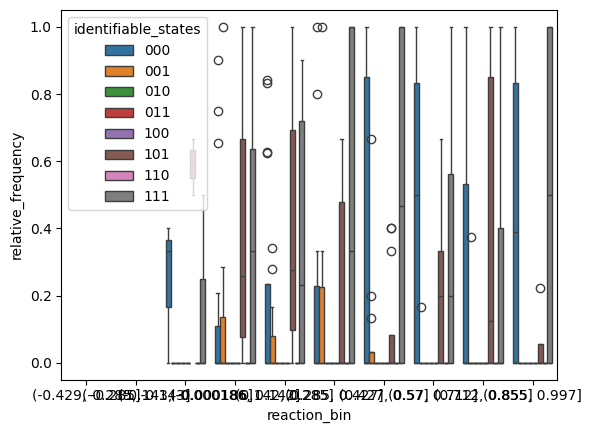

In [76]:
data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae')].dropna()
sns.boxplot(x='time_bin', y='relative_frequency', hue='identifiable_states', data=data)

/tmp/ipykernel_15261/3384389889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['time_bin'] = pd.cut(use_data['reaction'], 10)


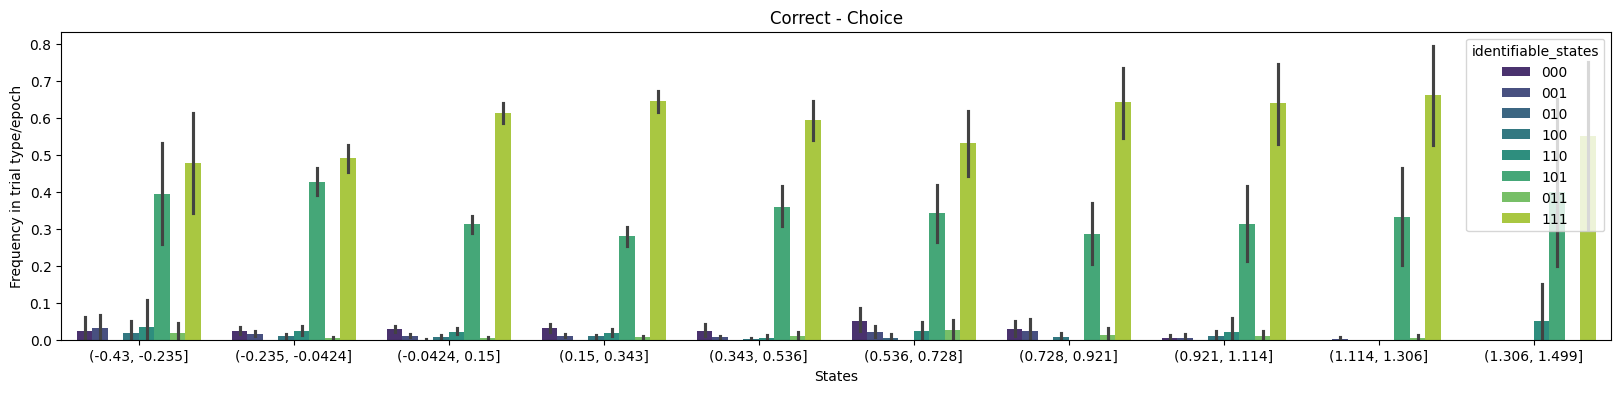

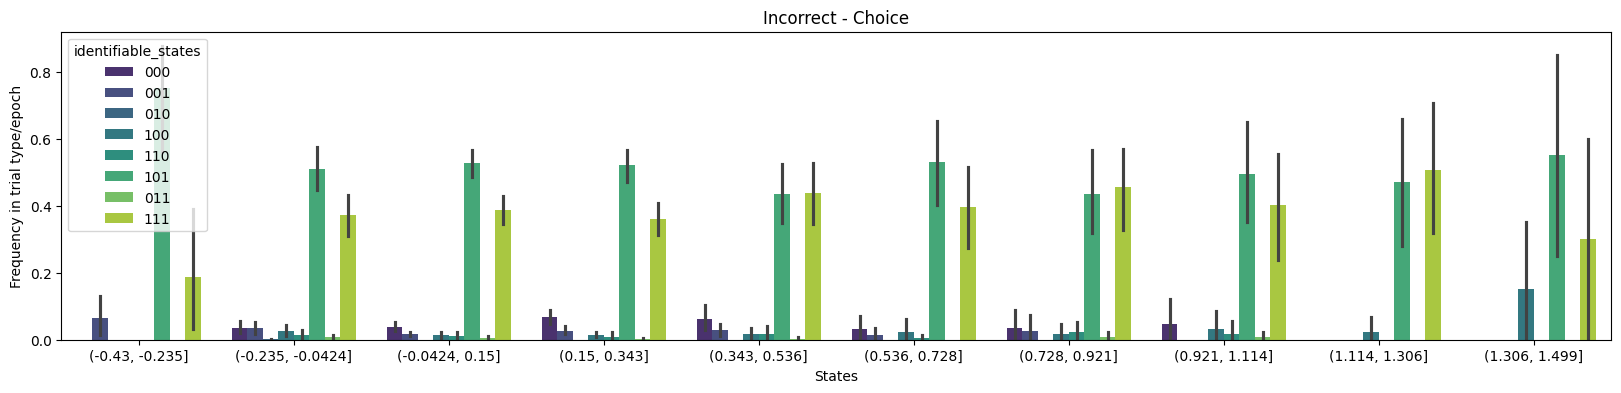

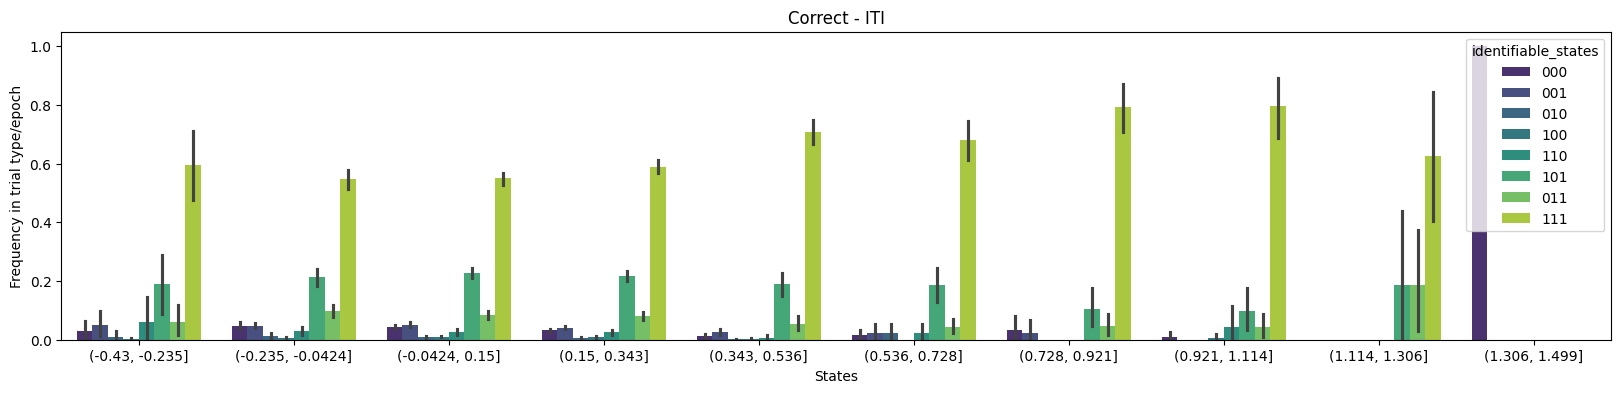

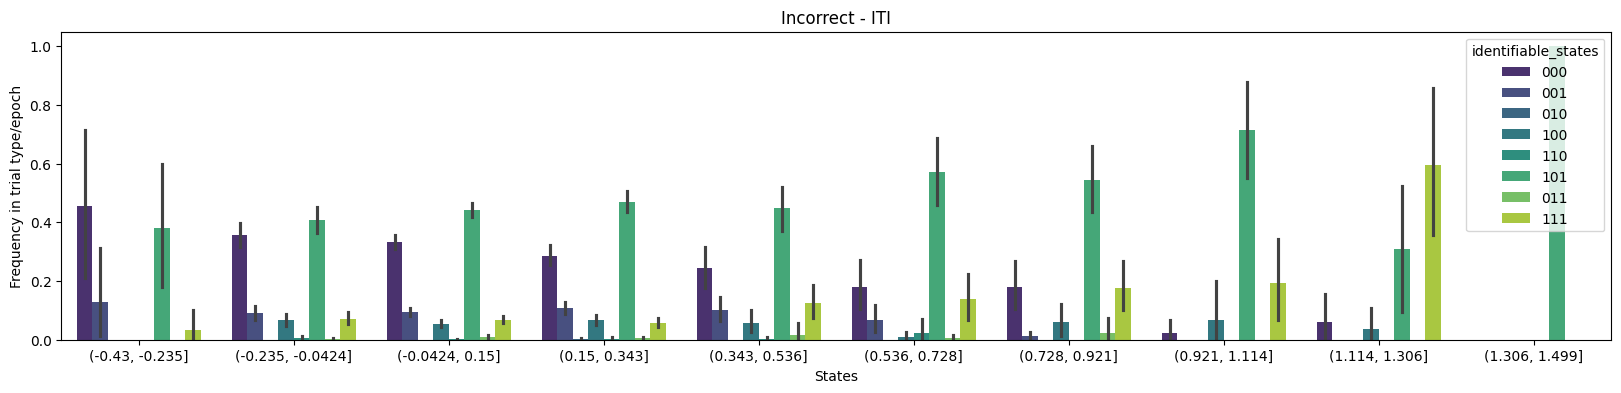

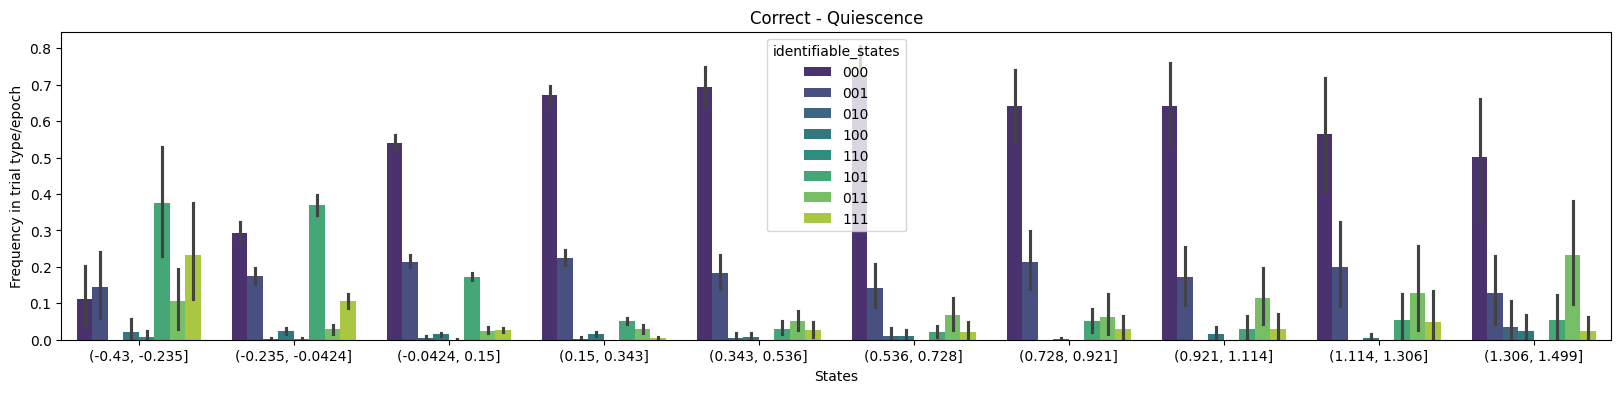

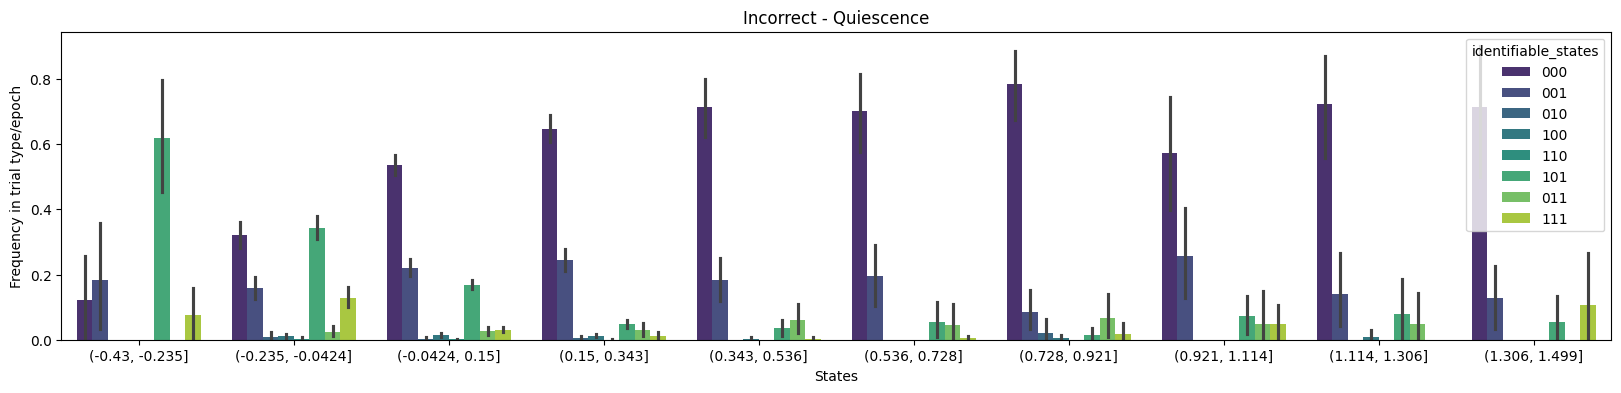

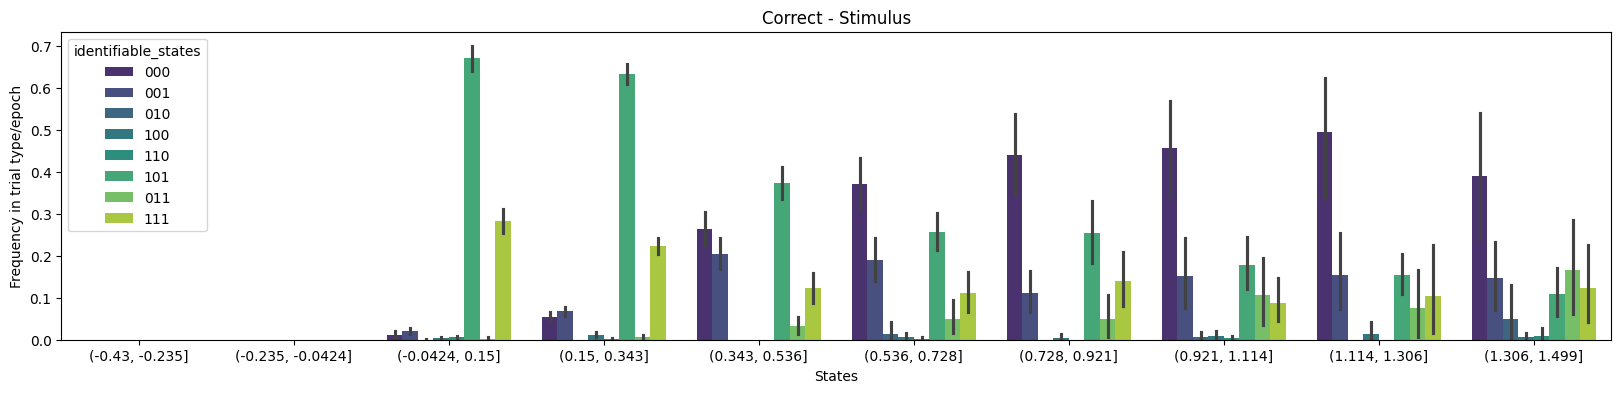

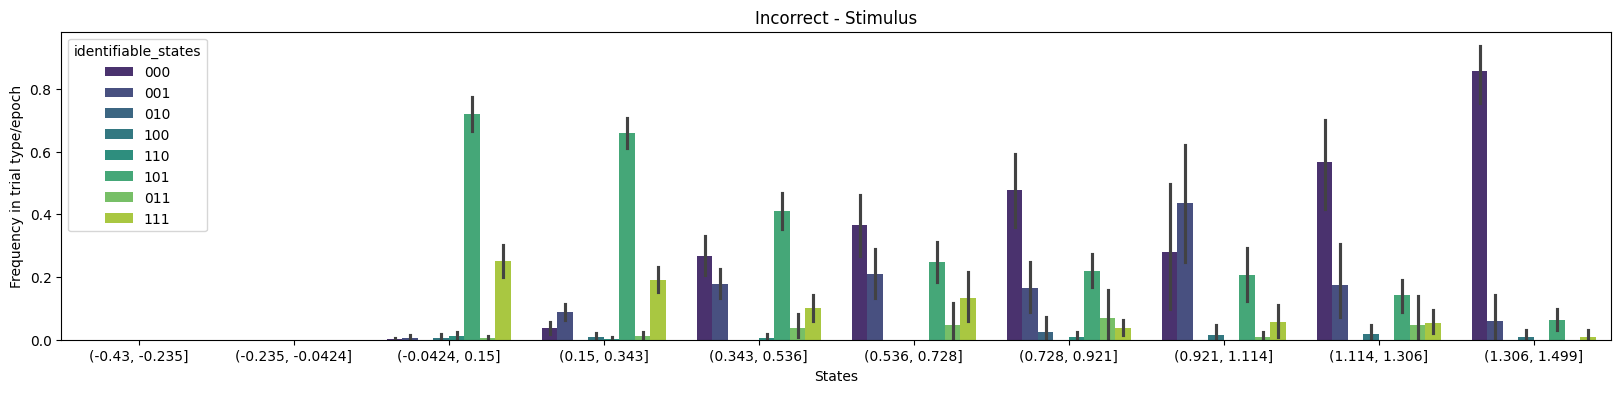

In [145]:
vars = ['mouse_name', 'session', 'contrast', 'time_bin', 'broader_label', 'correct']
extended_vars = ['mouse_name', 'session', 'contrast', 'time_bin', 'broader_label', 'correct', 'identifiable_states']
use_data = states_trial_type.loc[states_trial_type['reaction']<=1.5]
use_data['time_bin'] = pd.cut(use_data['reaction'], 10)
count = groupby(extended_vars, use_data)

trial_epoch = np.unique(count['broader_label'])
use = count.dropna()
for epoch in trial_epoch:

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==1.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Correct - '+epoch)
    plt.show()

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==0.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Incorrect - '+epoch)
    plt.show()


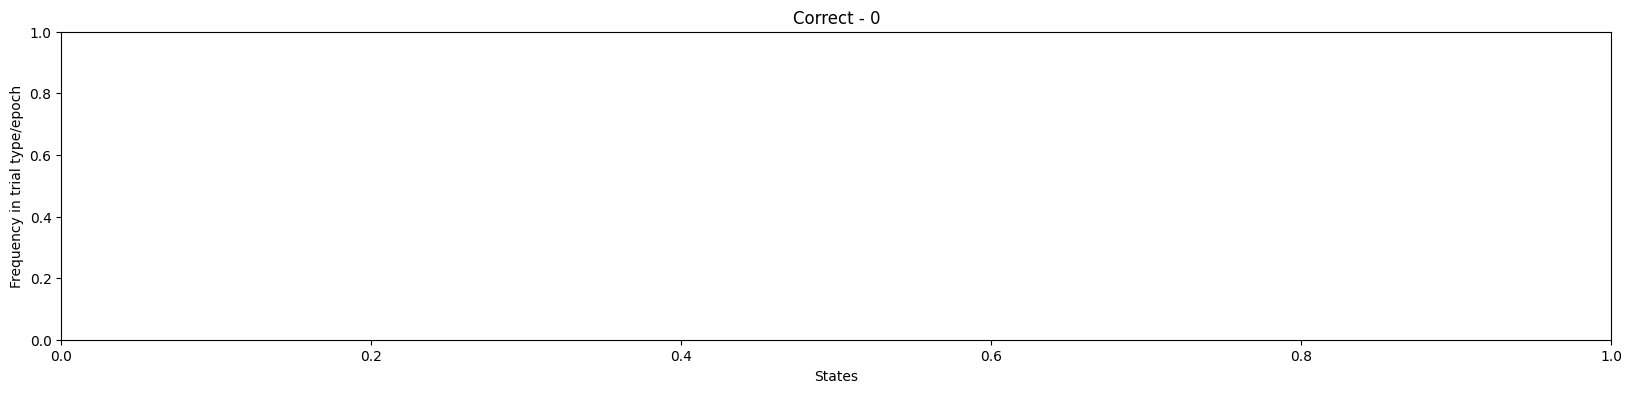

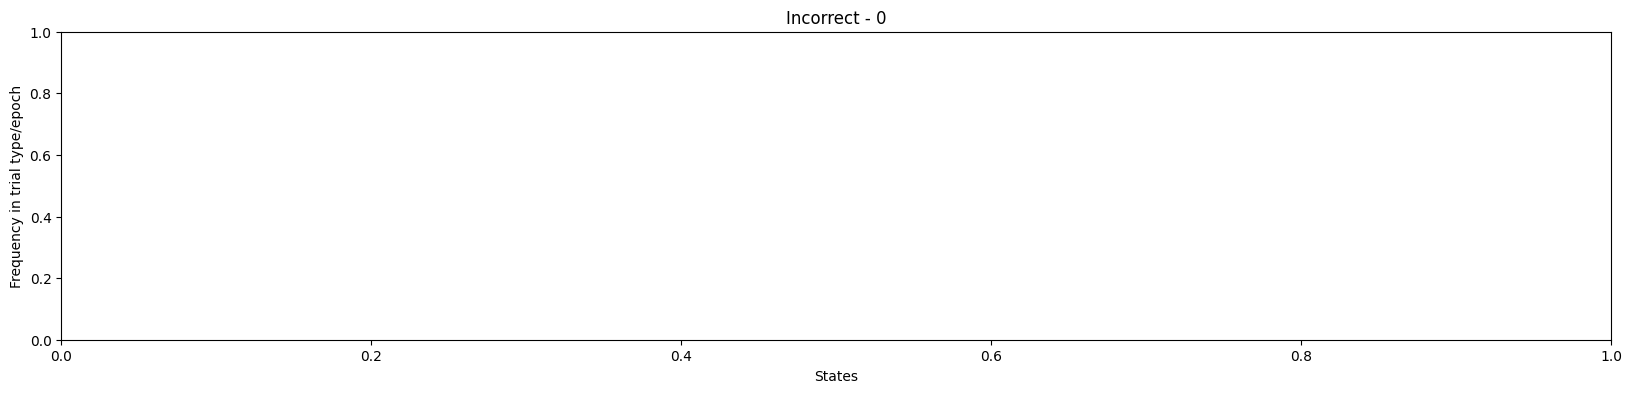

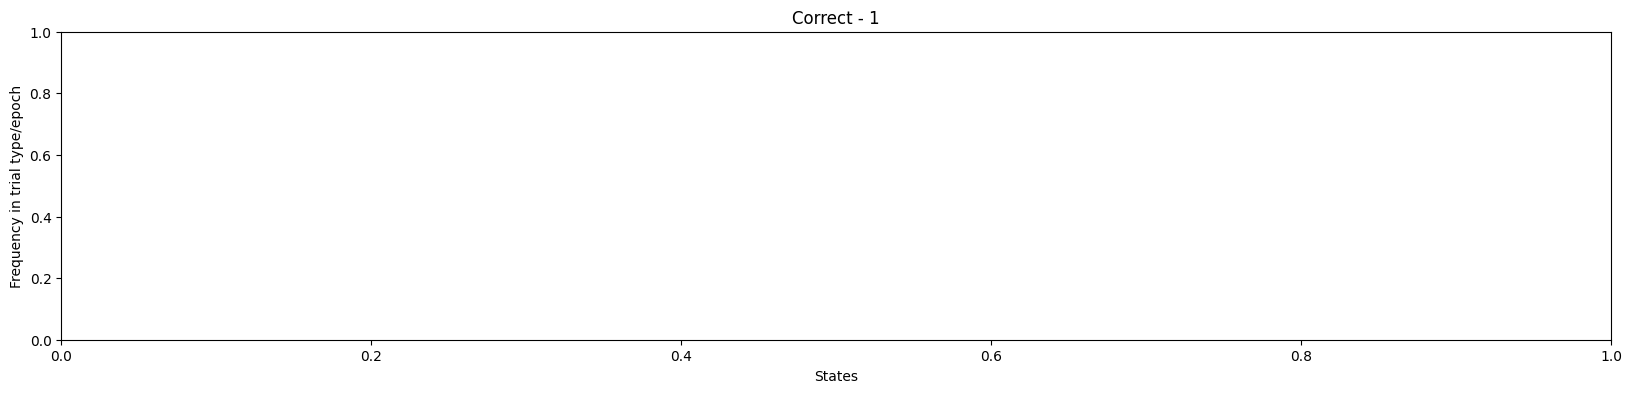

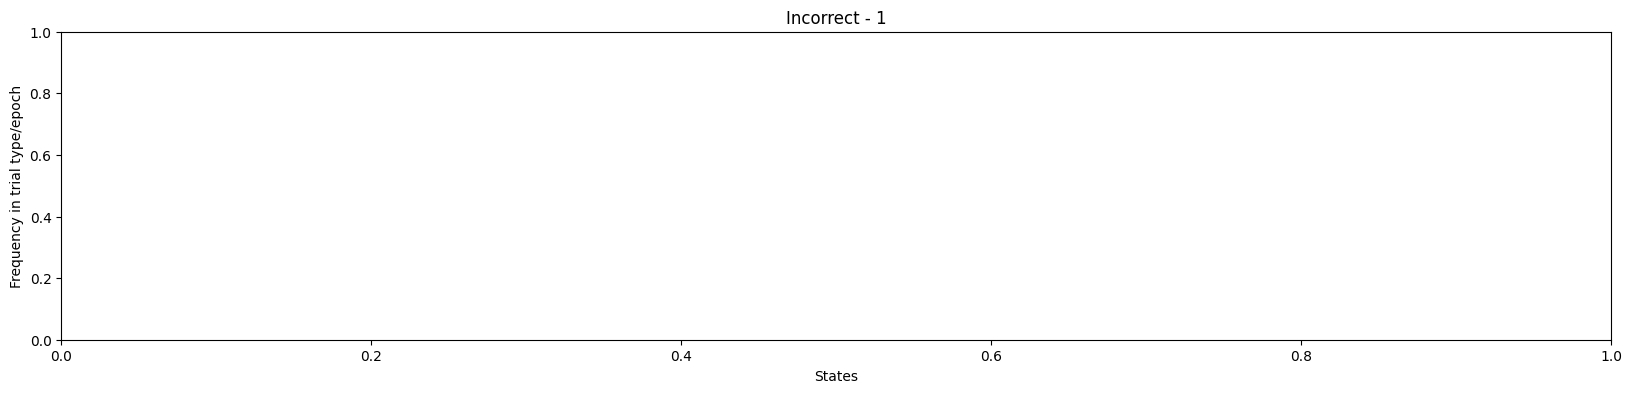

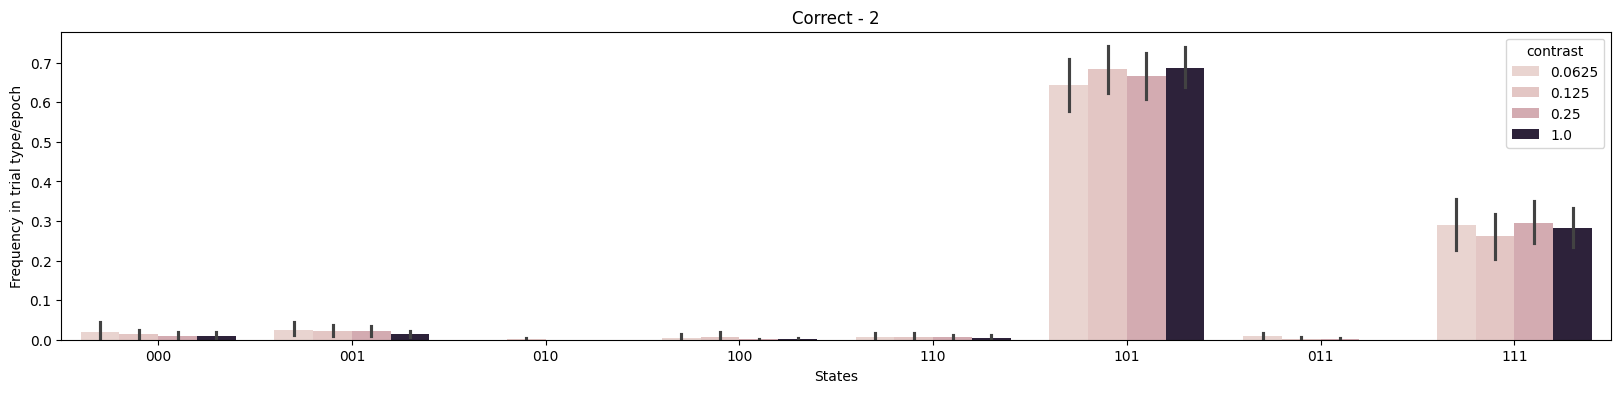

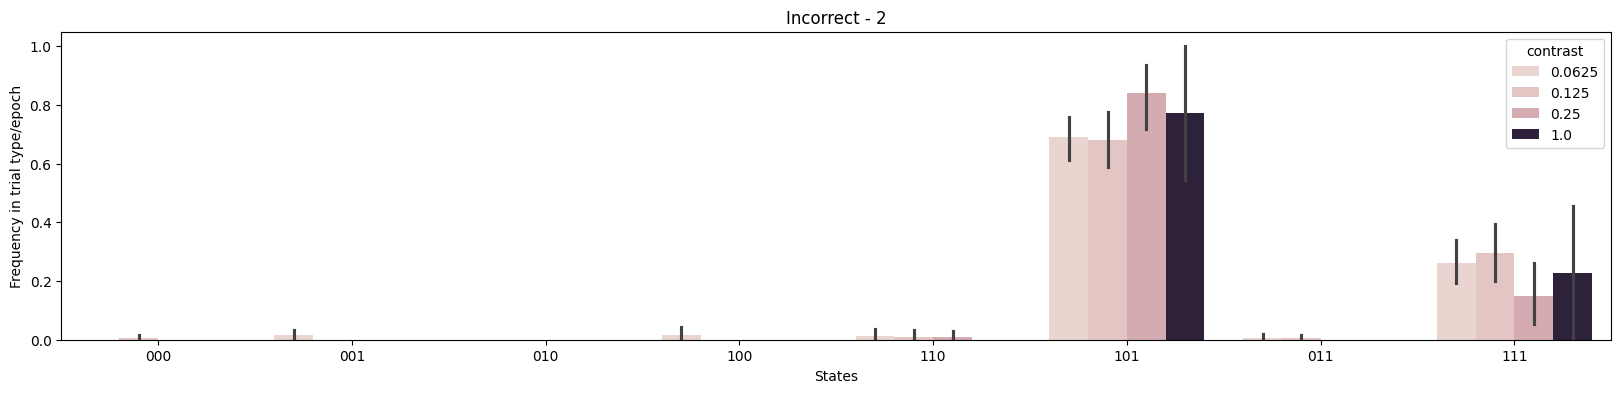

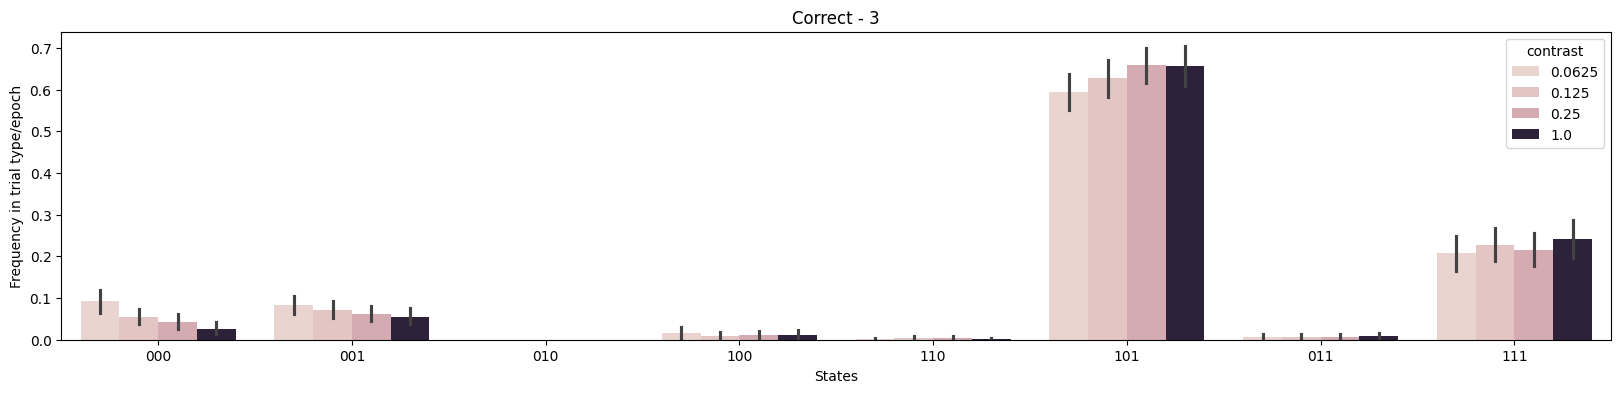

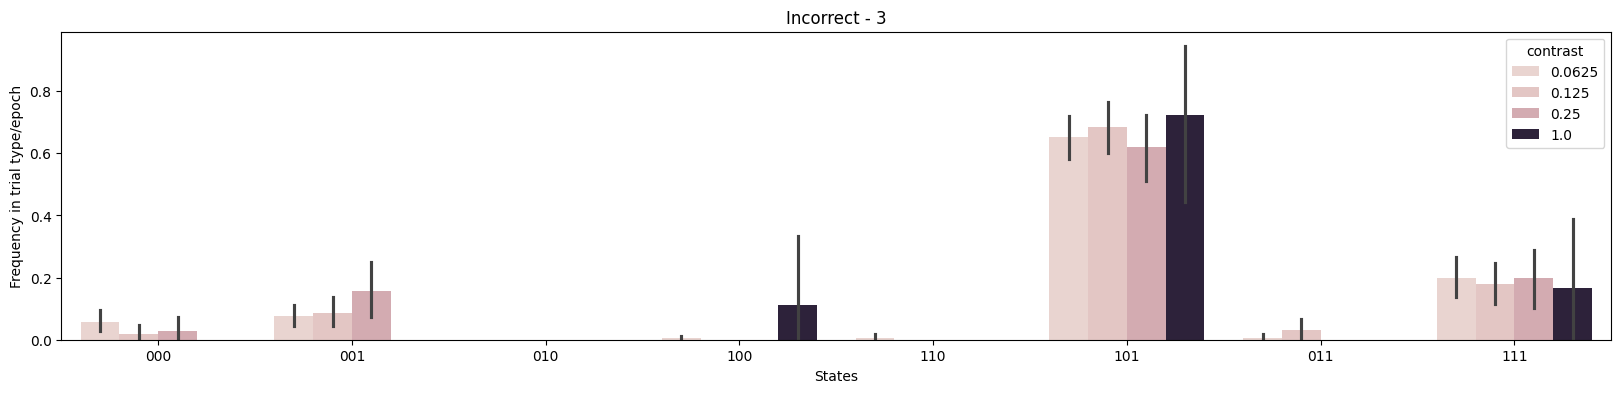

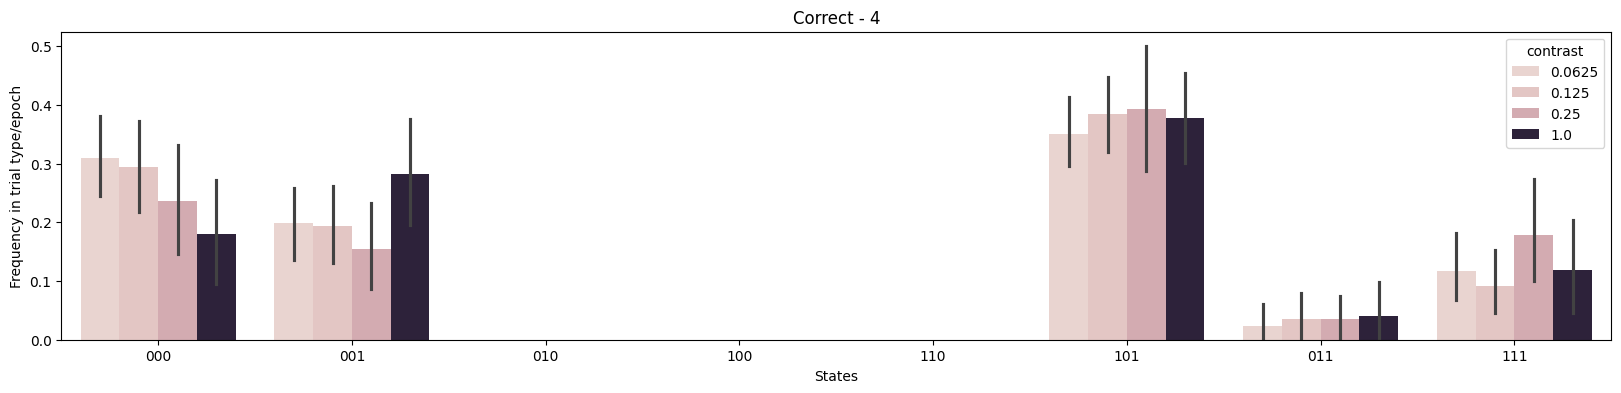

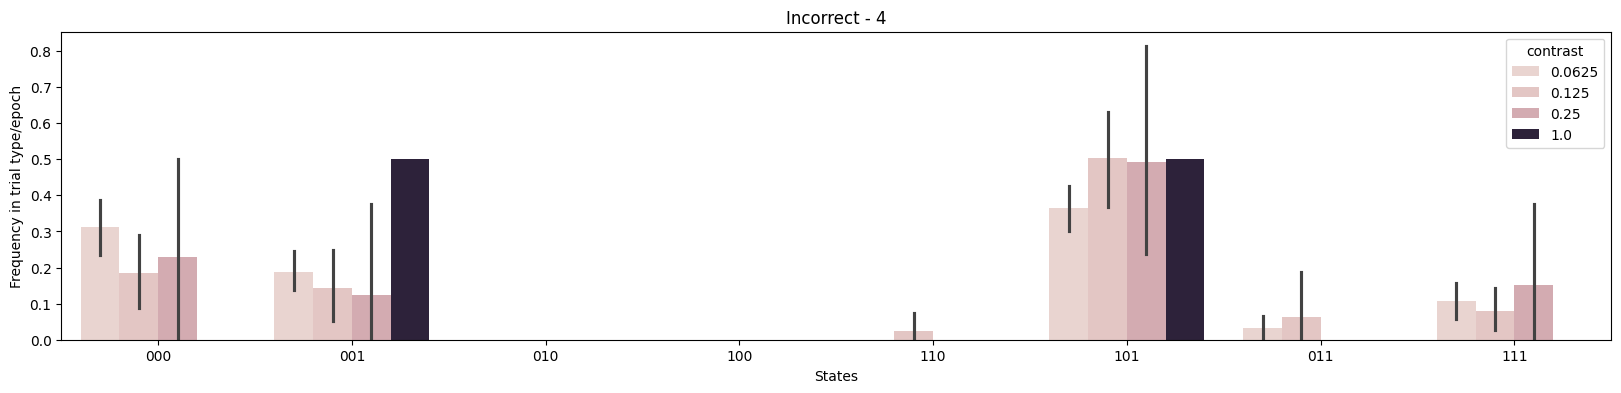

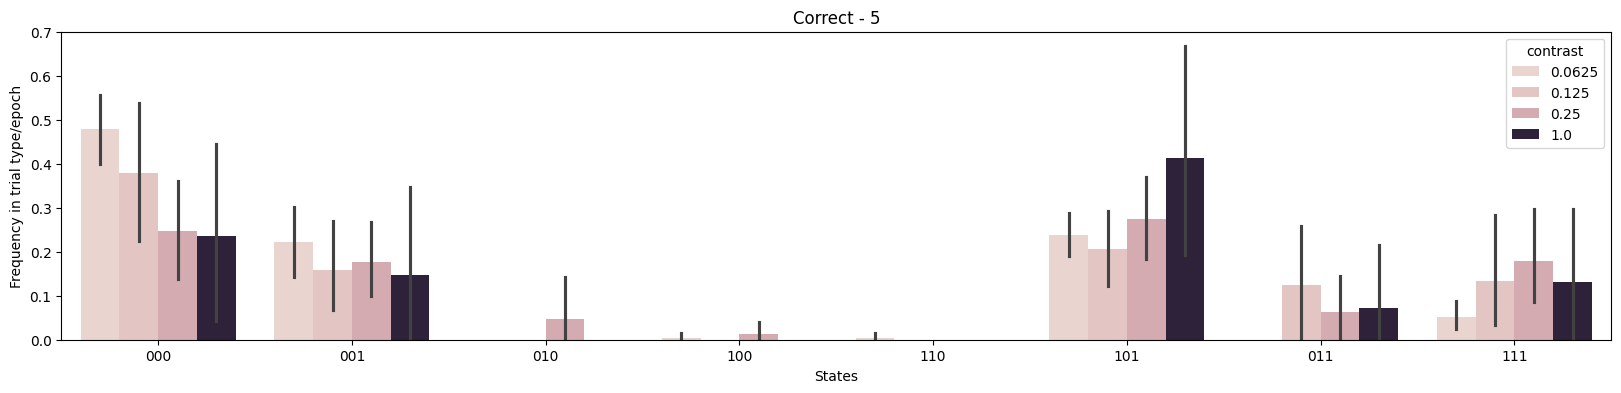

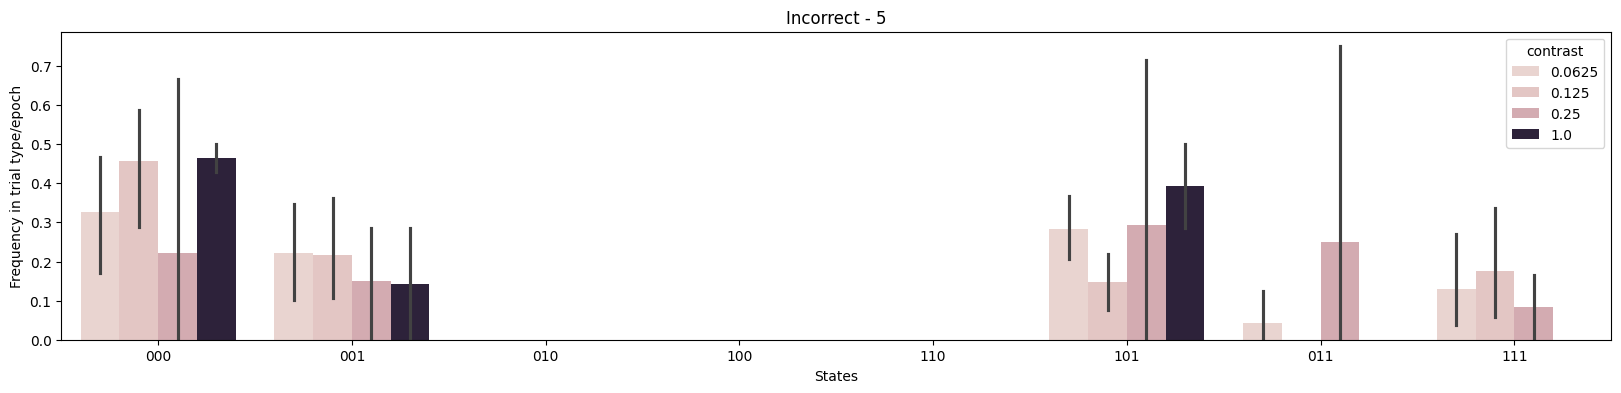

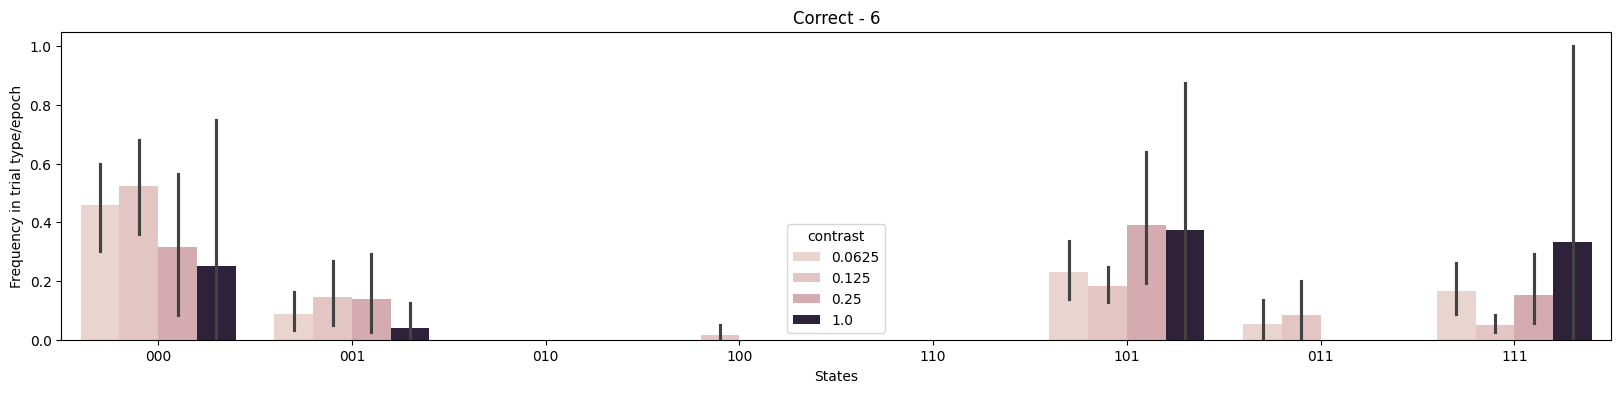

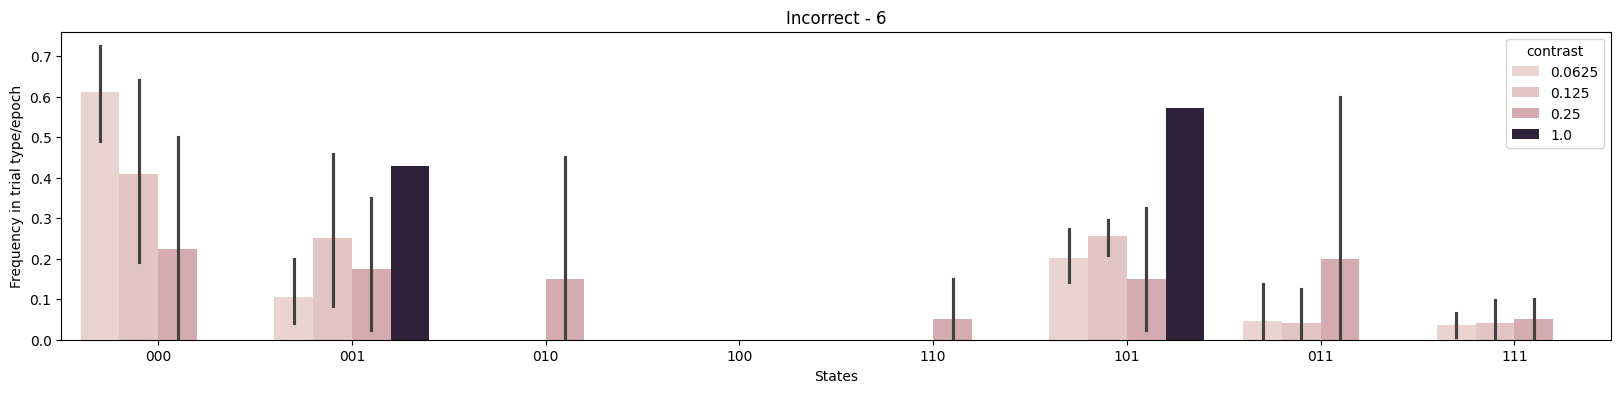

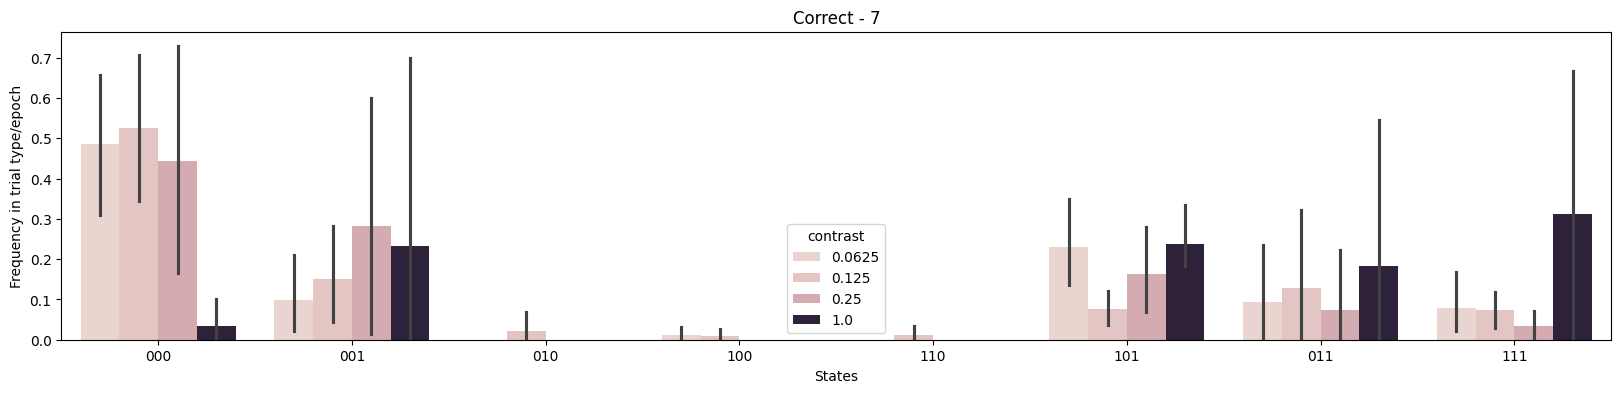

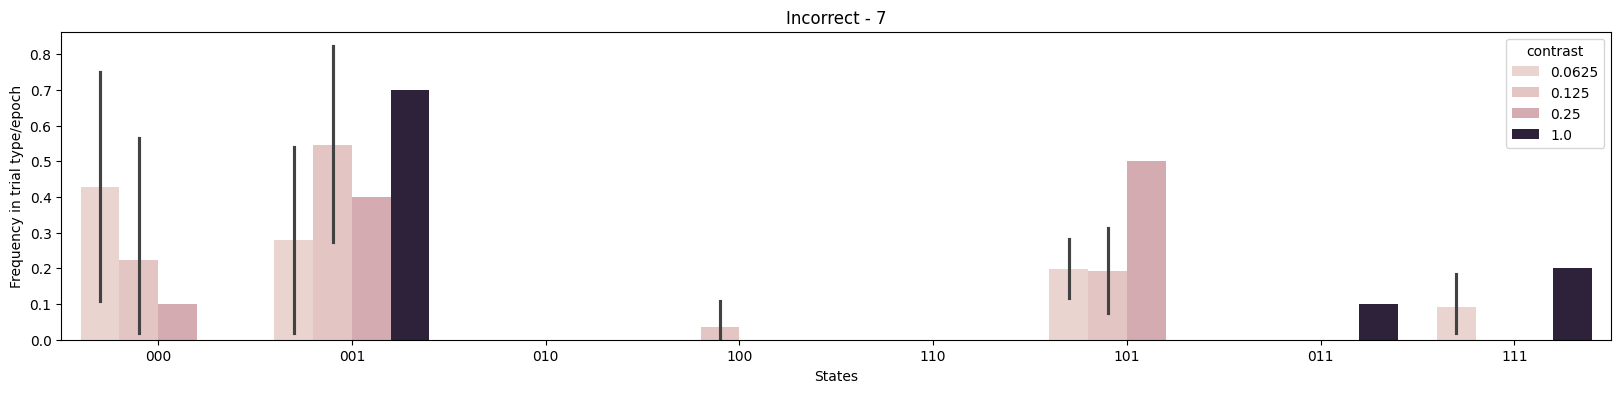

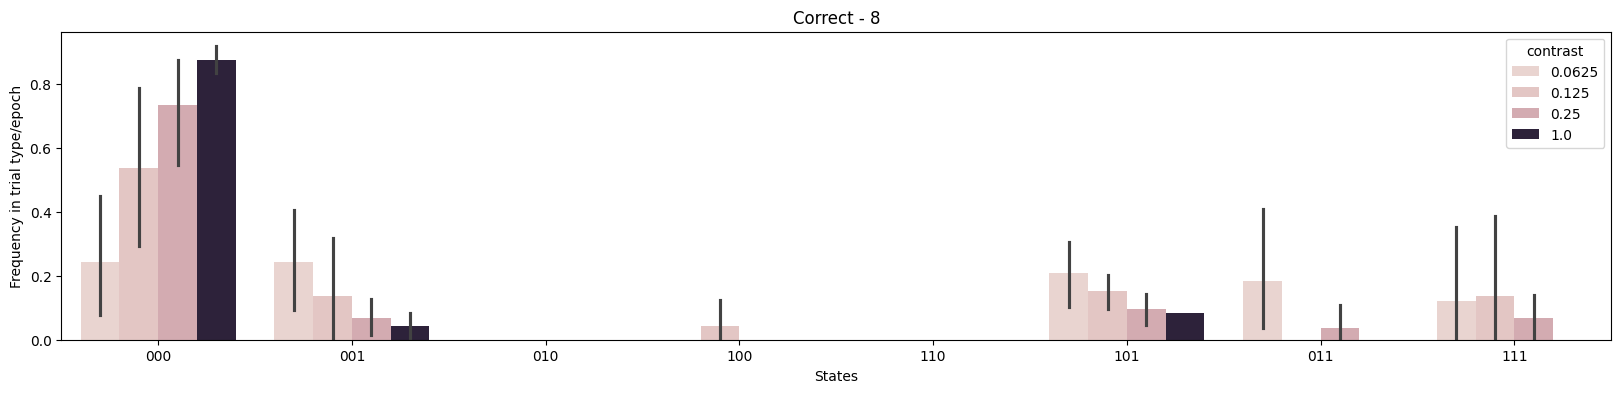

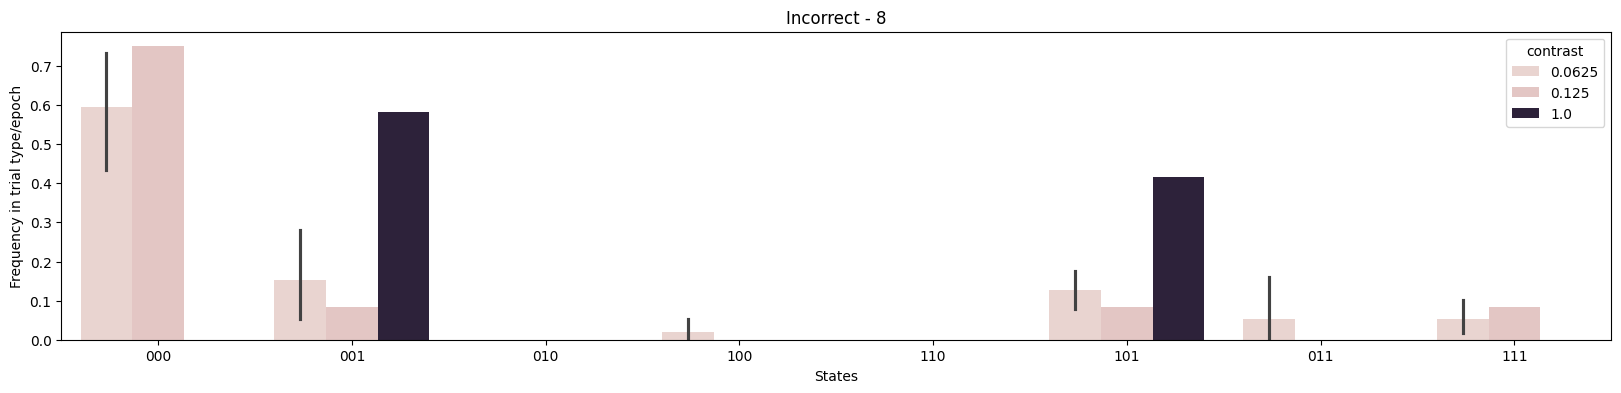

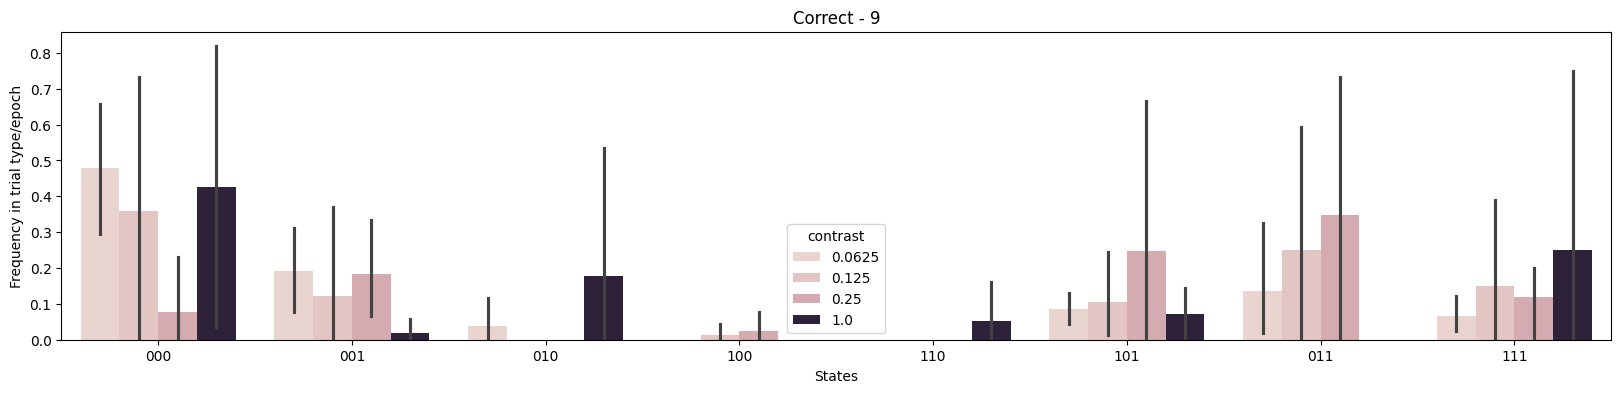

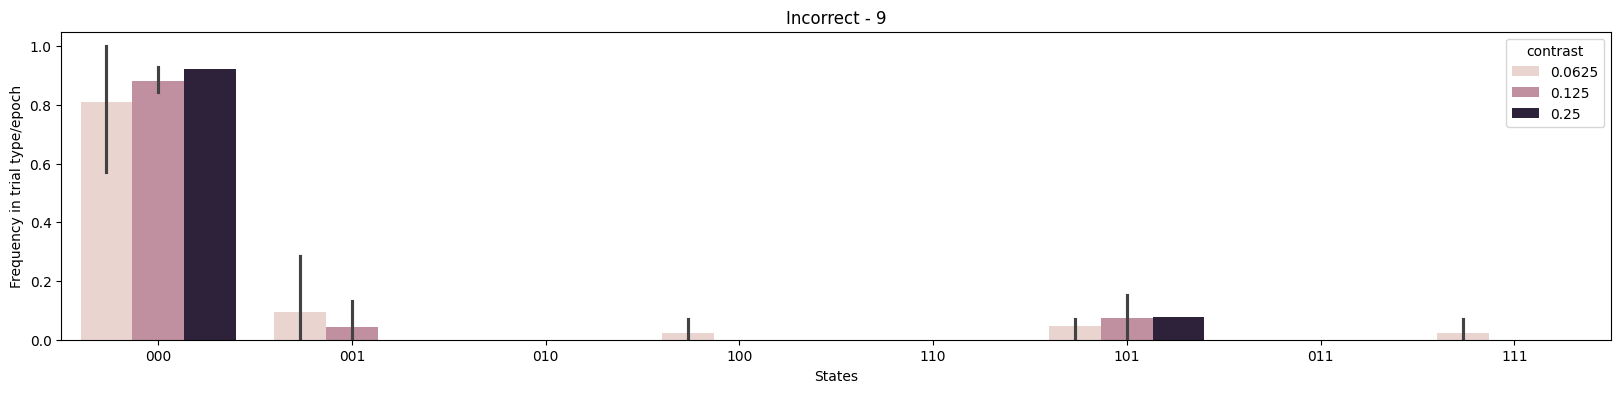

In [89]:
trial_epoch = np.unique(count['broader_label'])
epoch ='Stimulus'
reaction_bin = count.reaction_bin.unique()
use = count.dropna()
for b, bi in enumerate(reaction_bin):

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==1.) & (use['reaction_bin']==bi)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(x='identifiable_states', y='relative_frequency', hue='contrast', data=data,
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Correct - '+str(b))
    plt.show()

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==0.) & (use['reaction_bin']==bi)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(x='identifiable_states', y='relative_frequency', hue='contrast', data=data, 
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Incorrect - '+str(b))
    plt.show()


In [9]:
# Step 1: Group and count occurrences
count = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'contrast', 'broader_label', 'correct', 'identifiable_states'])['identifiable_states'].count())  #  'correct',

# Step 2: Reset index to bring the grouping columns back into the DataFrame
count = count.reset_index(level=[0, 1, 2, 3, 4])

# Rename the count column
count.rename(columns={'identifiable_states': 'count'}, inplace=True)

# Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
count['total'] = count.groupby(['mouse_name', 'session', 'contrast', 'broader_label', 'correct'])['count'].transform('sum')  # 'broader_label'

# Step 4: Compute the relative frequency
count['relative_frequency'] = count['count'] / count['total']

# Drop the 'total' column if it's no longer needed
count = count.drop(columns=['total'])

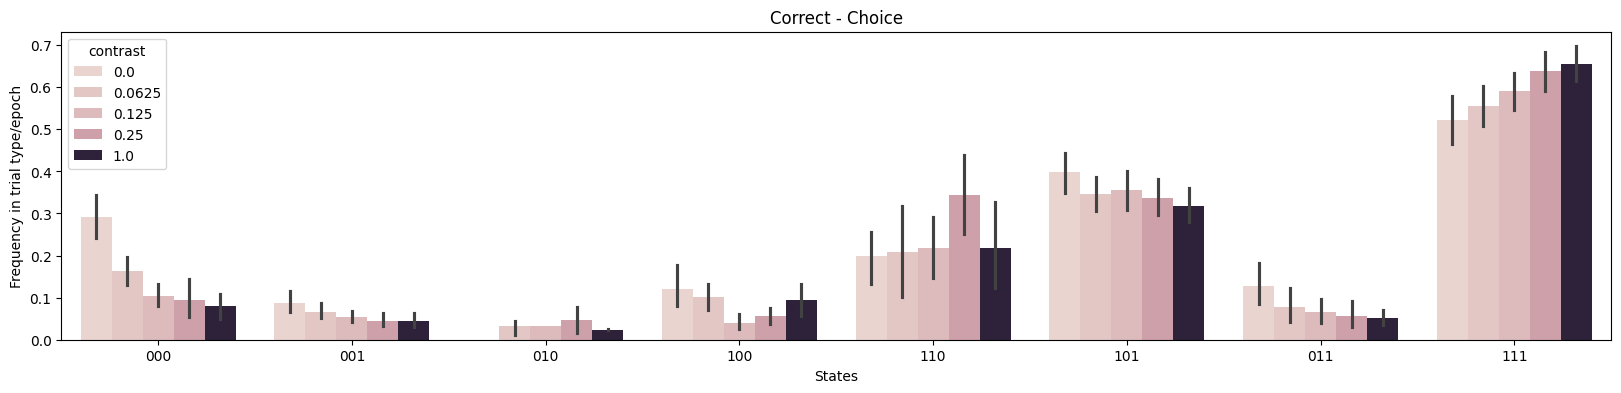

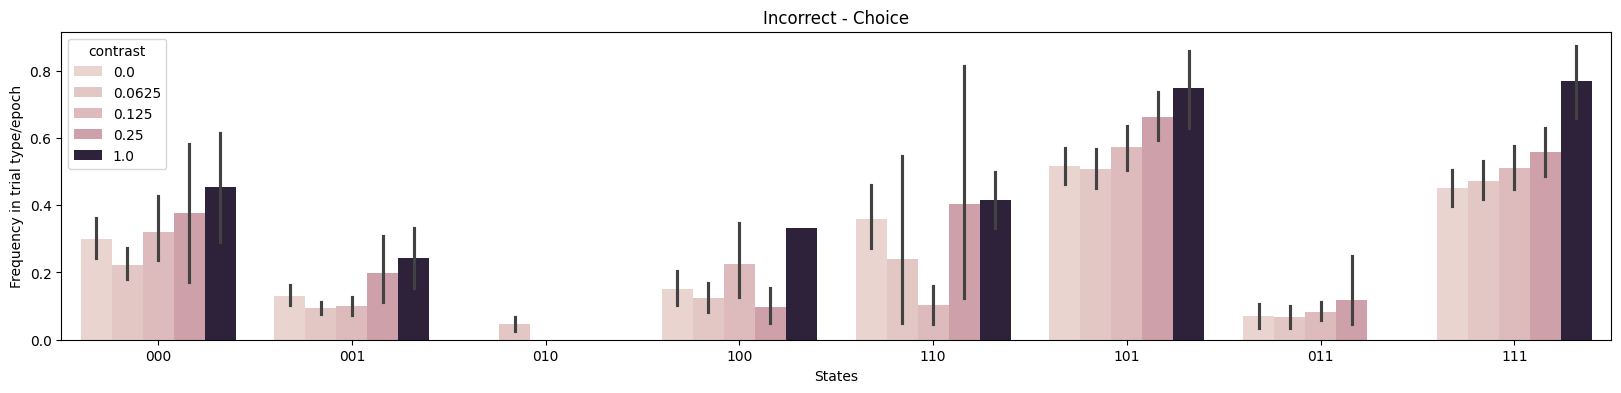

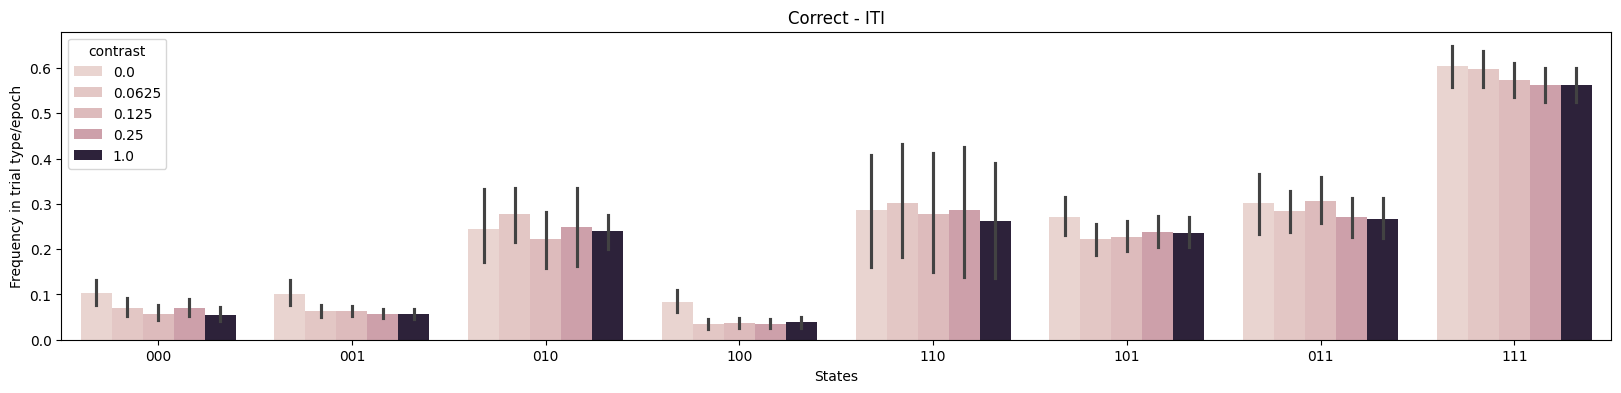

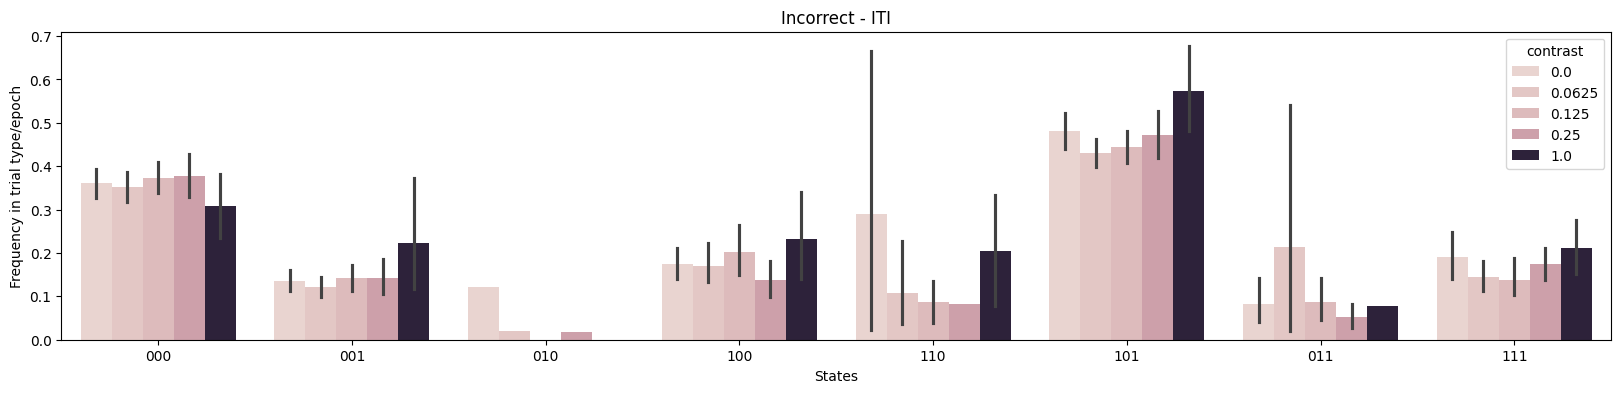

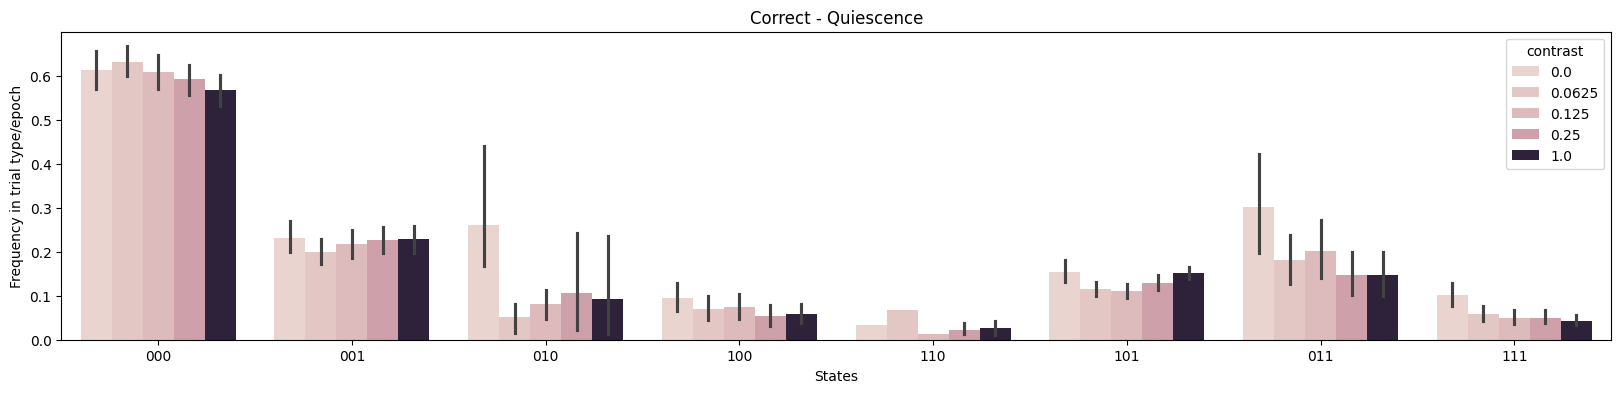

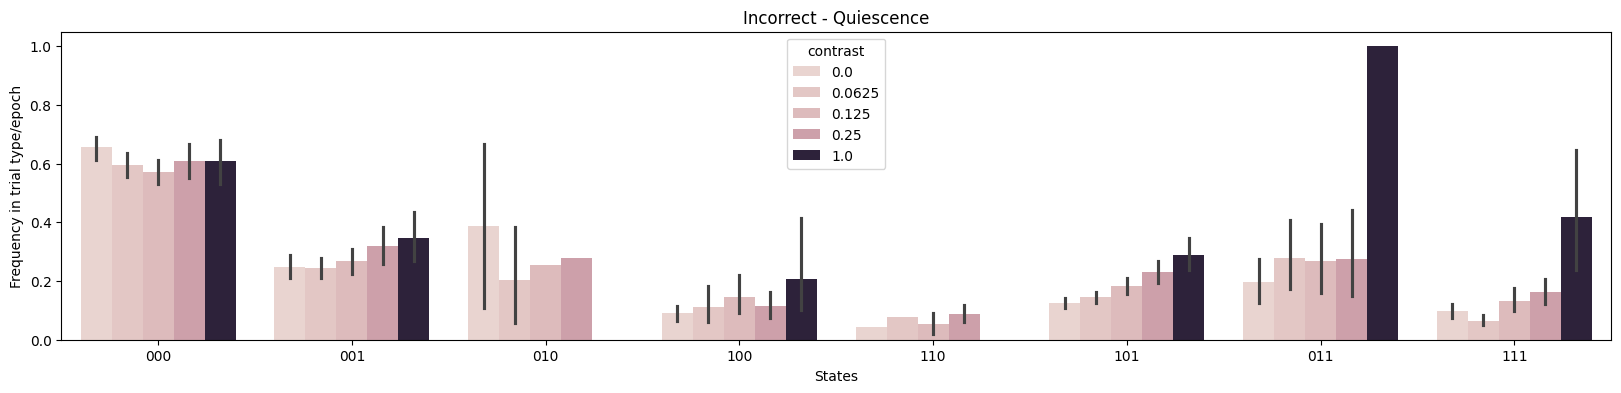

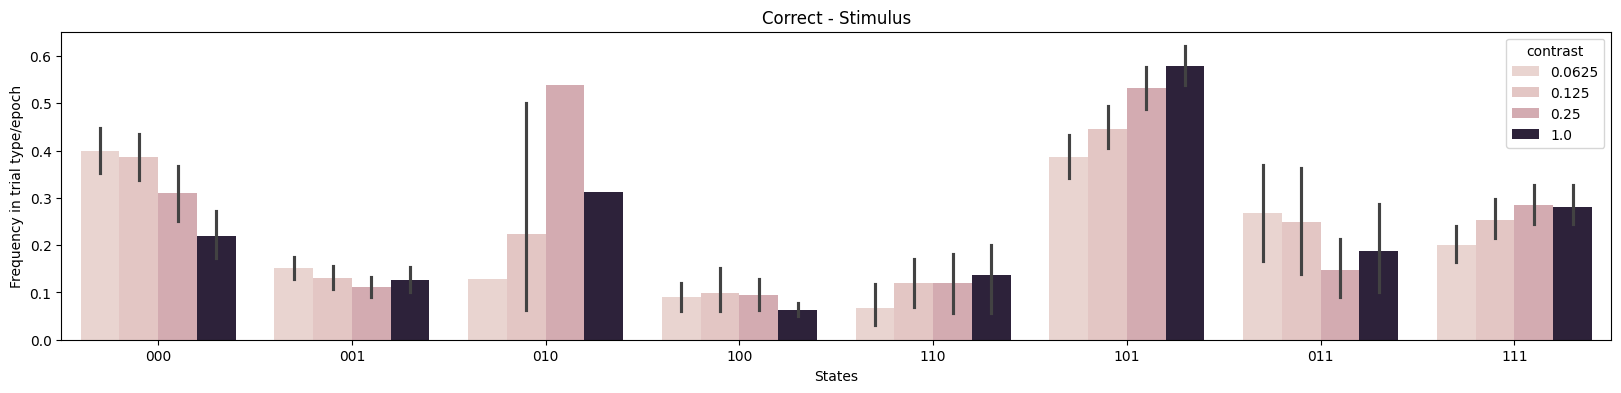

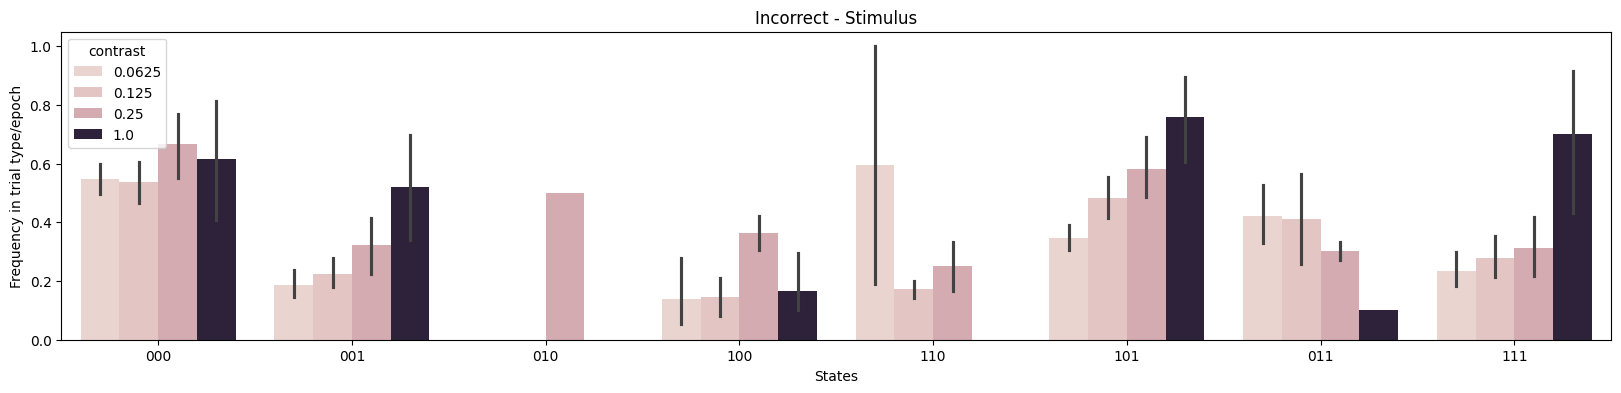

In [16]:
trial_epoch = np.unique(count['broader_label'])
epoch ='Quiescence'
contrasts = count.contrast.unique()

for epoch in trial_epoch:

    data = count.loc[(count['broader_label']==epoch) & (count['correct']==1.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='contrast', y='relative_frequency', x='identifiable_states', data=data, 
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Correct - '+epoch)
    plt.show()

    data = count.loc[(count['broader_label']==epoch) & (count['correct']==0.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='contrast', y='relative_frequency', x='identifiable_states', data=data, 
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Incorrect - '+epoch)
    plt.show()


In [ ]:
plt.figure(figsize=[20, 4])
sns.barplot(x='identifiable_states', y='relative_frequency', hue='identifiable_states', data=count, 
            palette='viridis', hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])

In [22]:
# Step 1: Group and count occurrences
count = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'broader_label', 'identifiable_states'])['identifiable_states'].count())  #  'correct',

# Step 2: Reset index to bring the grouping columns back into the DataFrame
count = count.reset_index(level=[0, 1, 2])

# Rename the count column
count.rename(columns={'identifiable_states': 'count'}, inplace=True)

# Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
count['total'] = count.groupby(['mouse_name', 'session','broader_label'])['count'].transform('sum')  # 'broader_label'

# Step 4: Compute the relative frequency
count['relative_frequency'] = count['count'] / count['total']

# Drop the 'total' column if it's no longer needed
count = count.drop(columns=['total'])

Text(0, 0.5, 'Relative frequency')

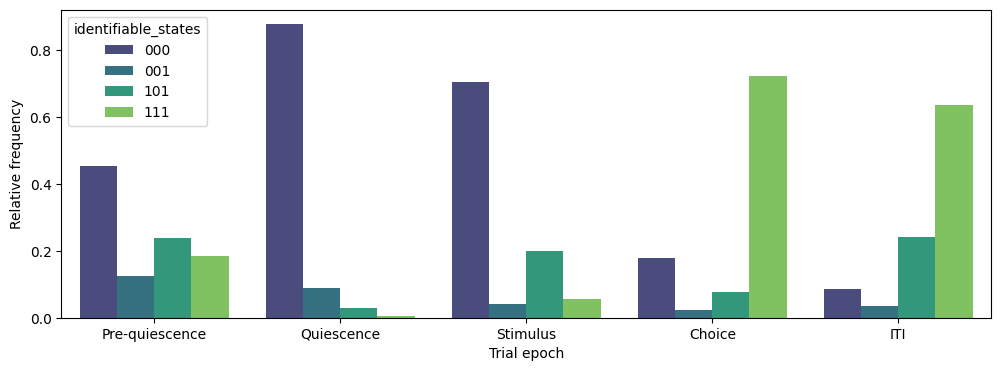

In [23]:
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], palette='viridis') # , hue_order=['000', '001', '101', '111']
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')

In [10]:
# Step 1: Group and count occurrences
count = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'broader_label', 'identifiable_states'])['identifiable_states'].count())  #  'correct',

# Step 2: Reset index to bring the grouping columns back into the DataFrame
count = count.reset_index(level=[0, 1, 2, 3])

# Rename the count column
count.rename(columns={'identifiable_states': 'count'}, inplace=True)

# Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
count['total'] = count.groupby(['mouse_name', 'session', 'correct', 'broader_label'])['count'].transform('sum')  # 'broader_label'

# Step 4: Compute the relative frequency
count['relative_frequency'] = count['count'] / count['total']

# Drop the 'total' column if it's no longer needed
count = count.drop(columns=['total'])

Text(0, 0.5, 'Relative frequency')

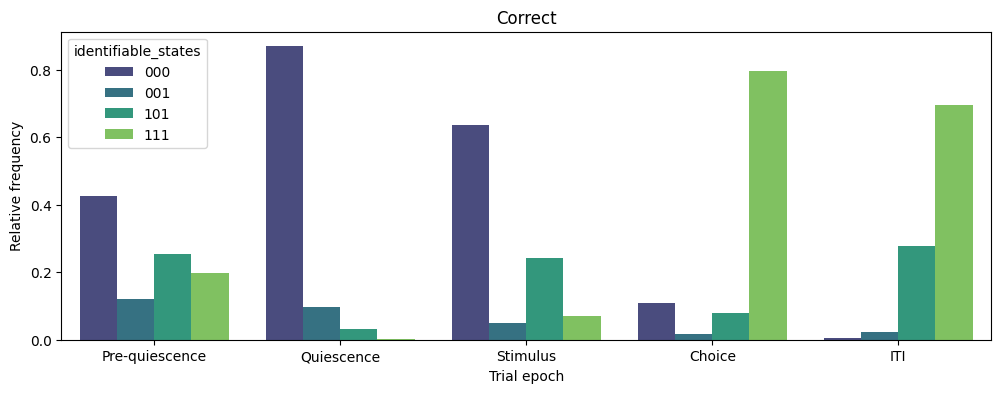

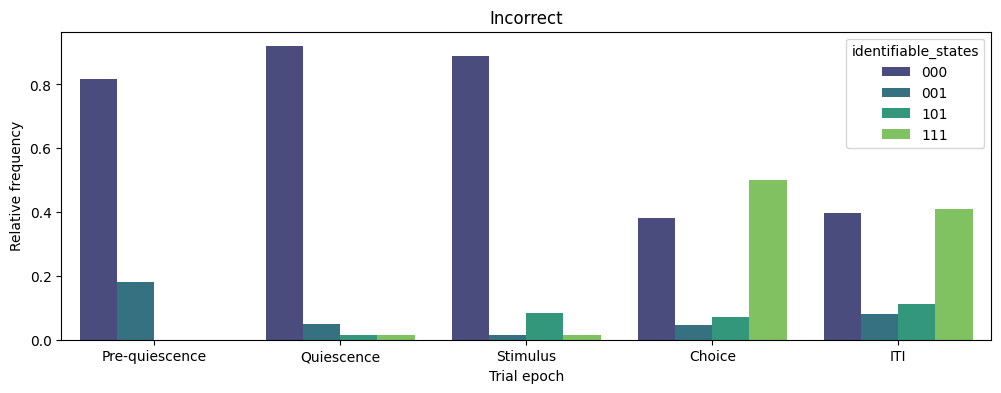

In [18]:
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==1.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], palette='viridis') # , hue_order=['000', '001', '101', '111']
plt.title('Correct')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==0.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], palette='viridis') 
plt.title('Incorrect')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/_base.py:1007: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_data.insert(0, var, comp_col)


ValueError: cannot reindex on an axis with duplicate labels

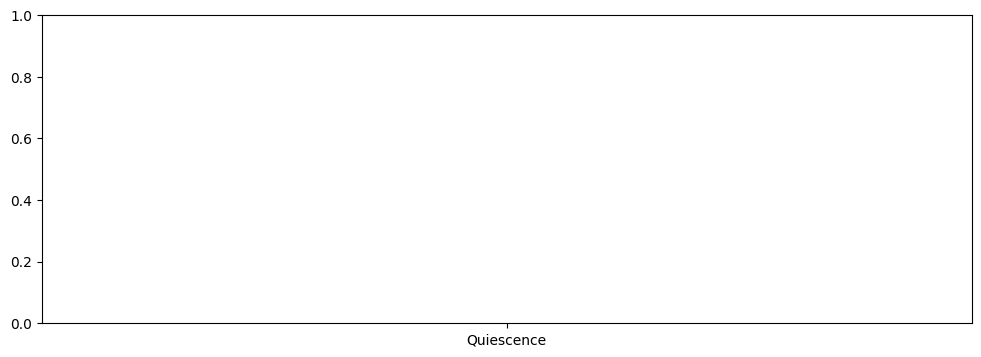

In [11]:
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==1.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Quiescence', 'Stimulus', 'Choice', 'ITI'],
            hue_order=['000', '001', '101', '111'])
plt.title('Correct')
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==0.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Quiescence', 'Stimulus', 'Choice', 'ITI'],
            hue_order=['000', '001', '101', '111'])
plt.title('Incorrect')
# ['Quiescence', 'Stimulus right', 'Stimulus left', 'Left choice',
#                                 'Right choice', 'Correct feedback', 'Incorrect feedback',
#                                 'ITI_correct', 'ITI_incorrect']

In [60]:

use_data.wsls.unique()

array(['wst', 'ls', 'wsh', 'lsh'], dtype=object)

/tmp/ipykernel_23489/1033638356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


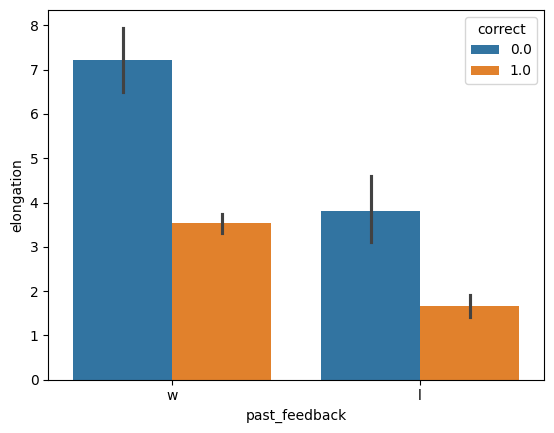

In [61]:

use_data = states_trial_type.loc[states_trial_type['session']=='7416f387-b302-4ca3-8daf-03b585a1b7ec']
use_data['past_feedback'] = use_data['wsls']
use_data.loc[use_data['wsls']=='lsh', 'past_feedback'] = 'l'
use_data.loc[use_data['wsls']=='ls', 'past_feedback'] = 'l'
use_data.loc[use_data['wsls']=='wsh', 'past_feedback'] = 'w'
use_data.loc[use_data['wsls']=='wst', 'past_feedback'] = 'w'
# use_data = session_trials
sns.barplot(y='elongation', hue='correct', x='past_feedback', data=use_data)
# plt.ylim([0, 5])
plt.show()

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


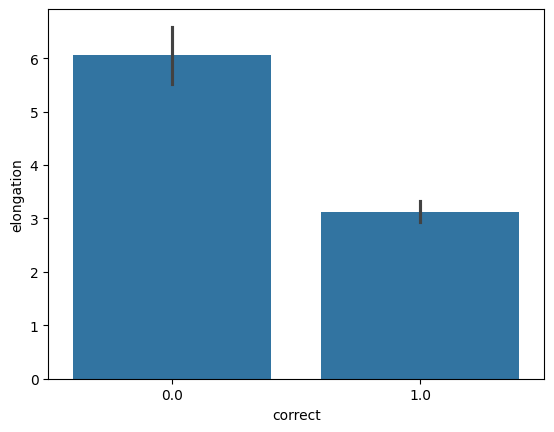

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


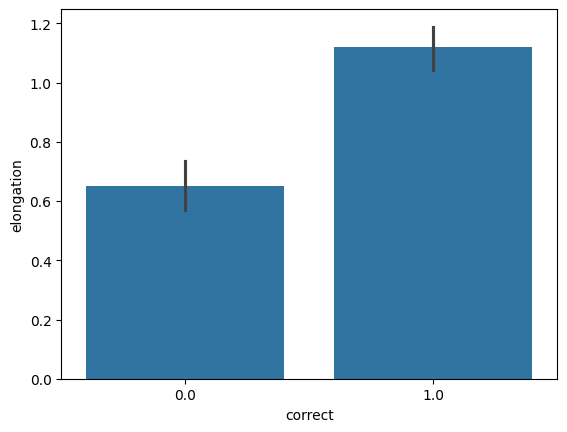

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


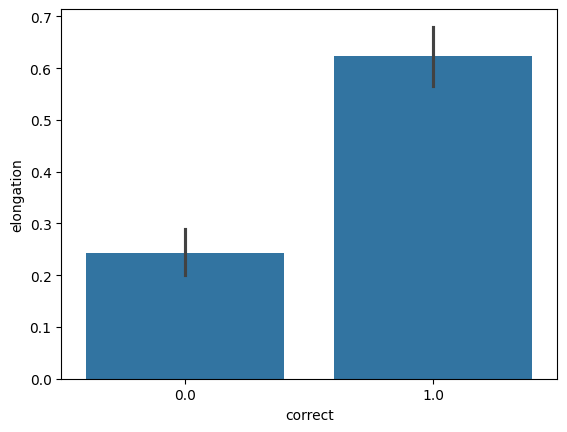

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


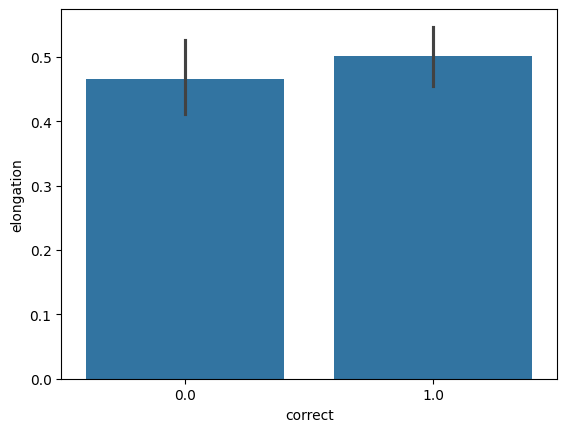

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


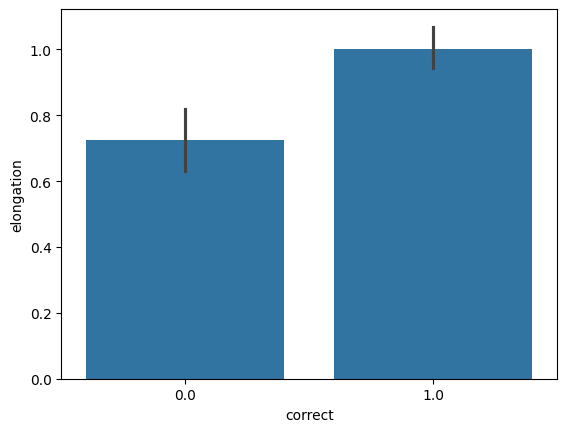

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


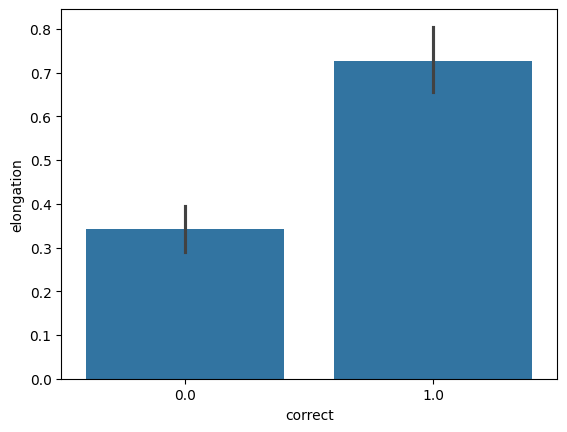

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


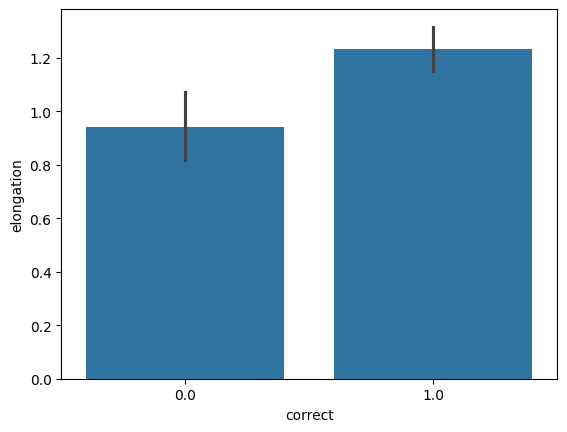

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


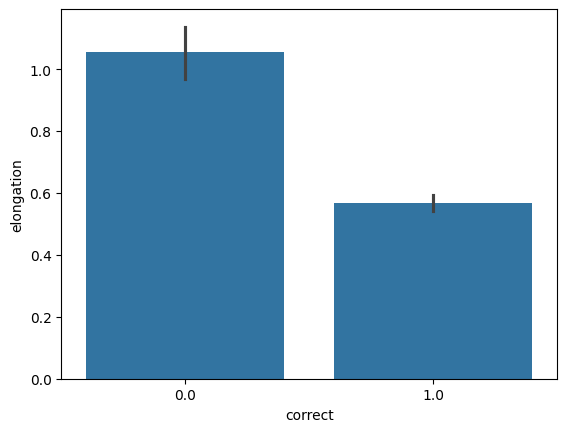

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


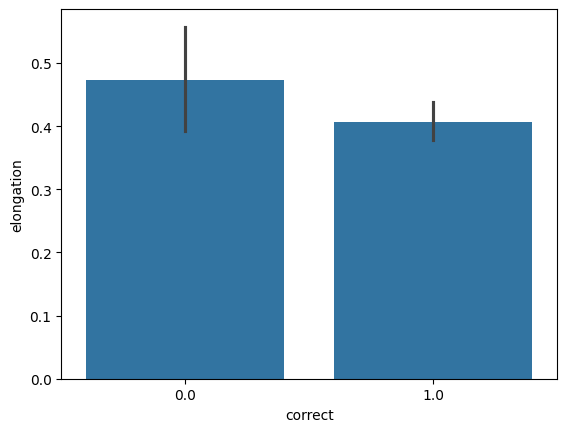

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


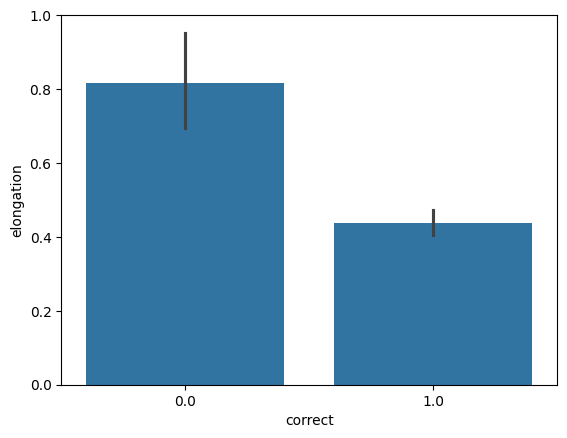

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


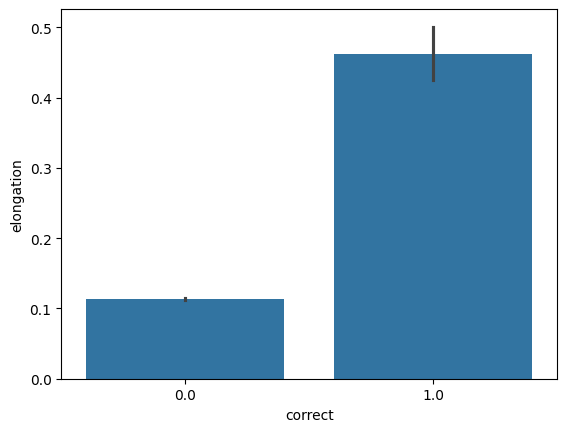

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


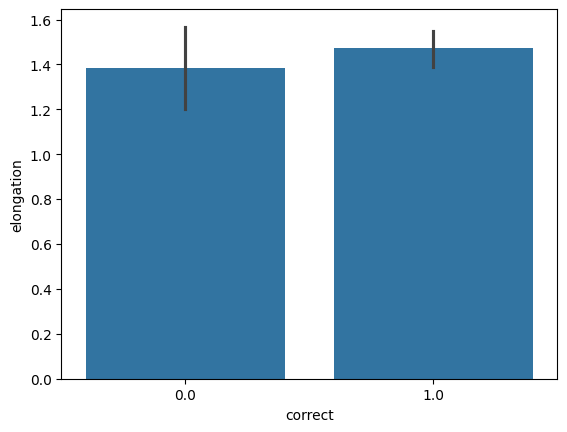

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


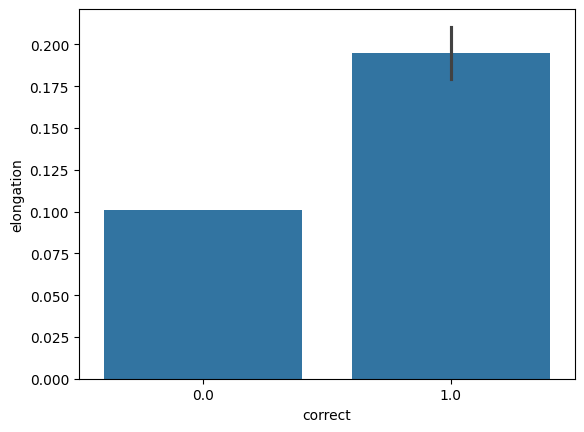

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


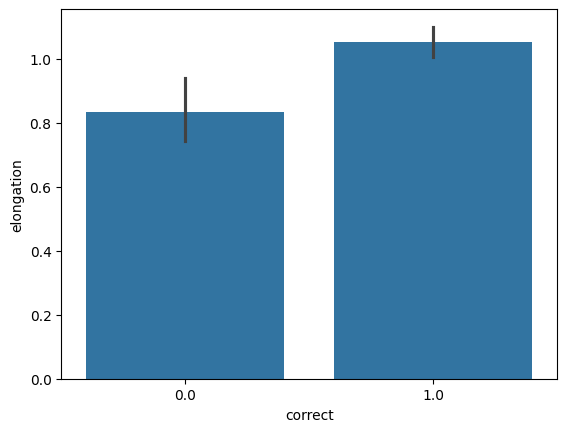

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


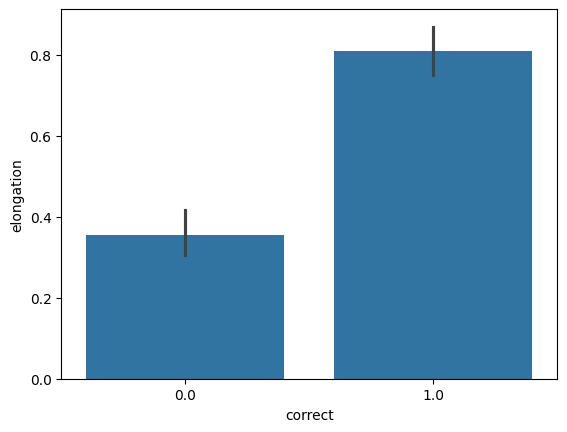

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


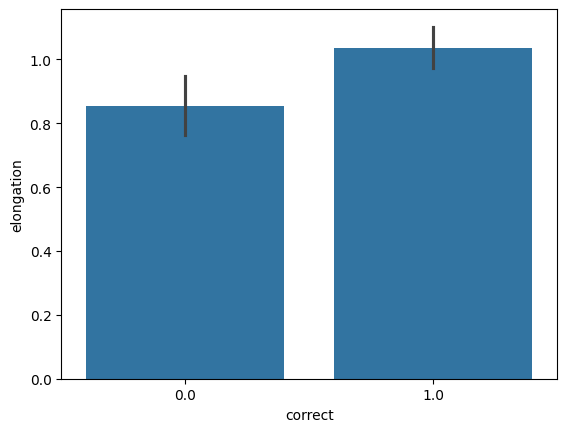

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


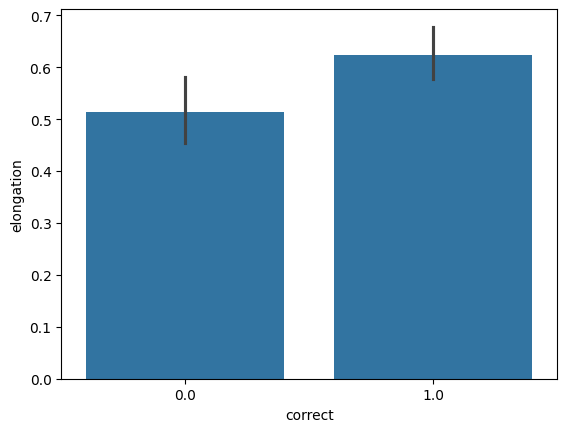

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


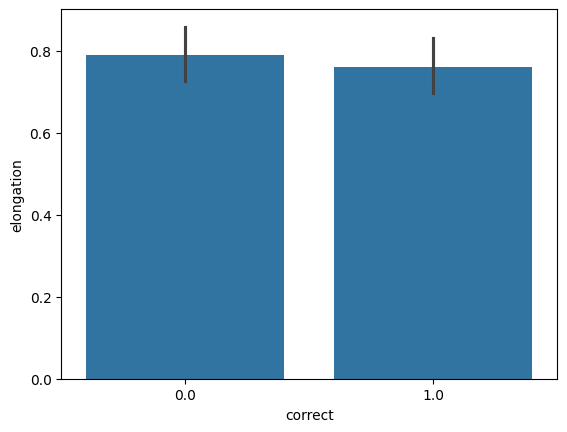

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


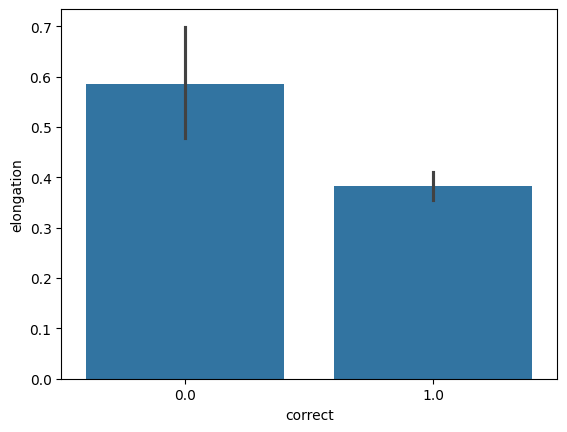

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


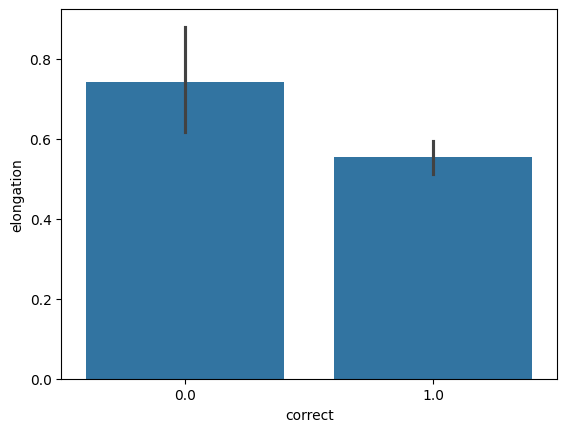

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


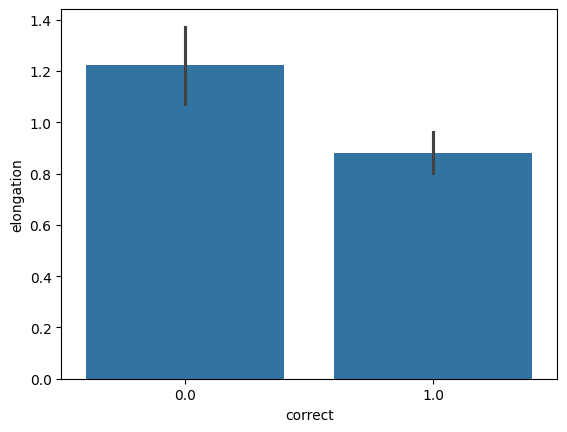

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


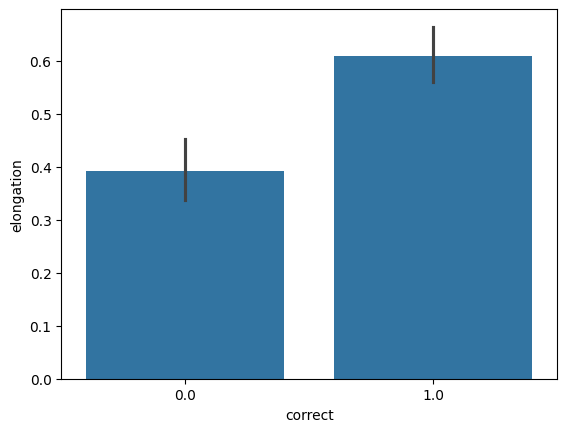

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


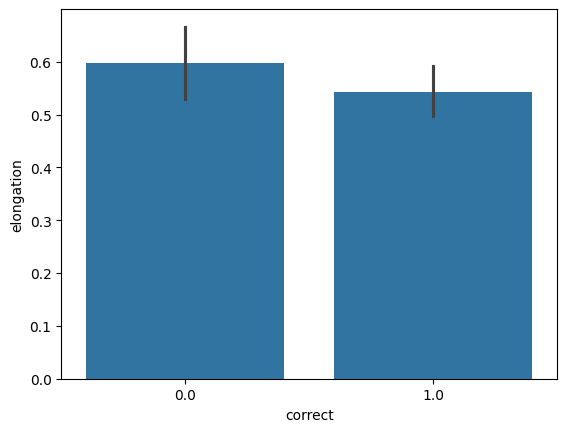

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


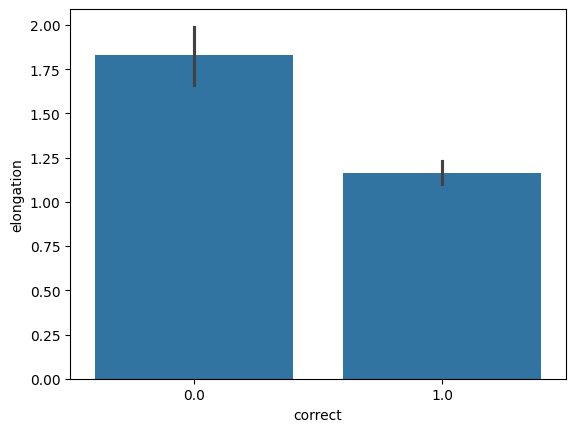

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


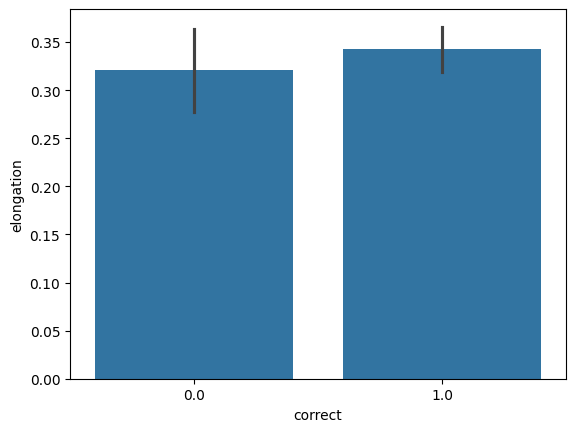

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


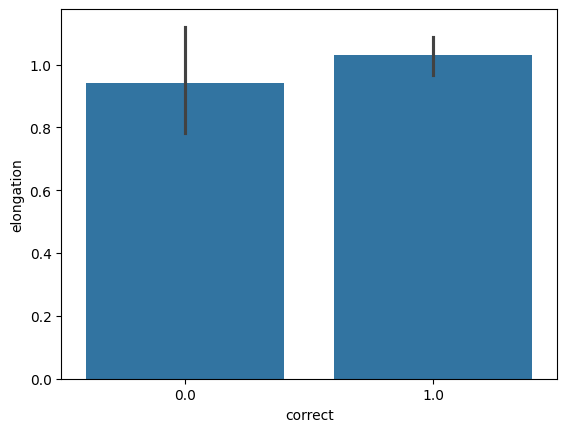

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


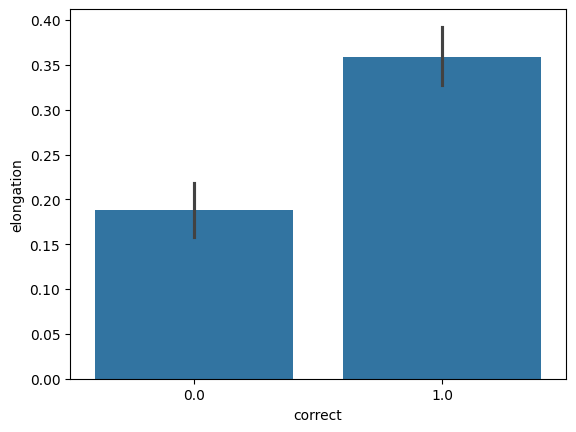

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


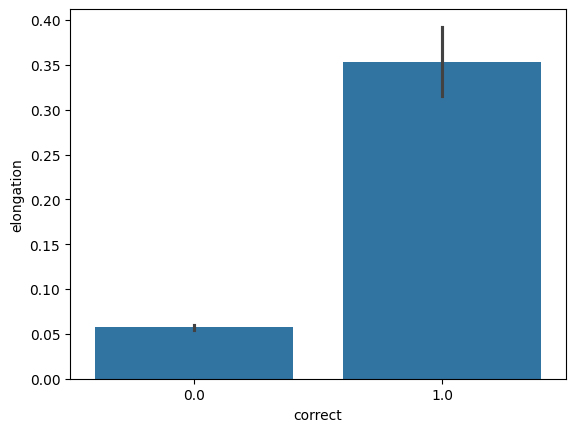

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


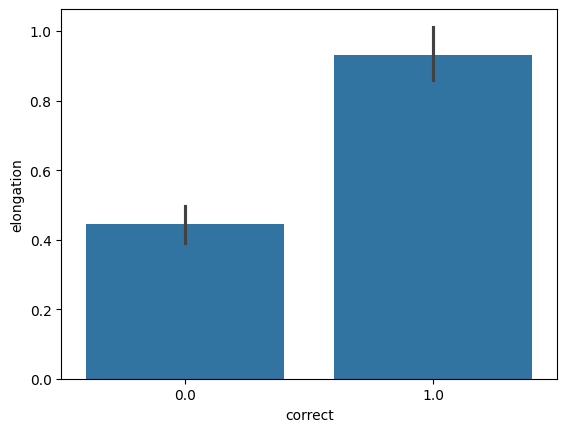

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


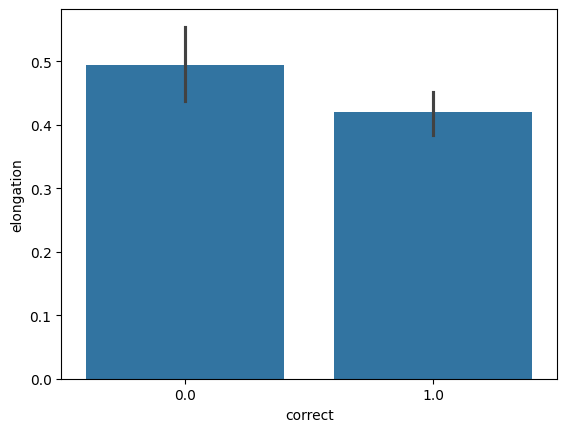

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


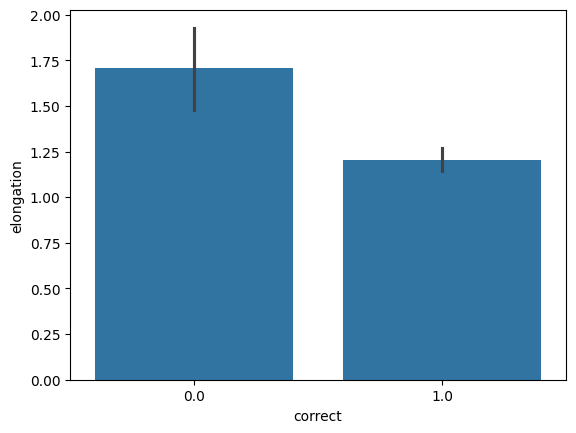

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


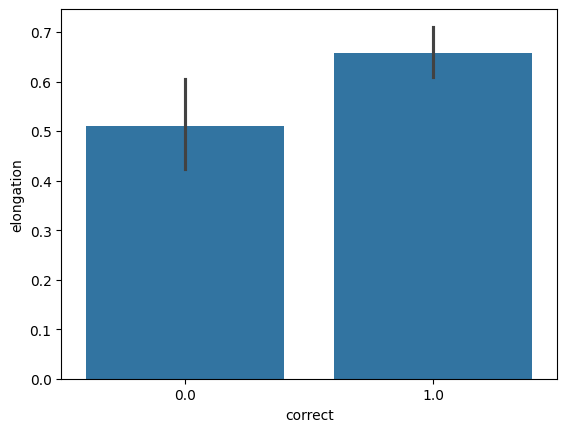

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


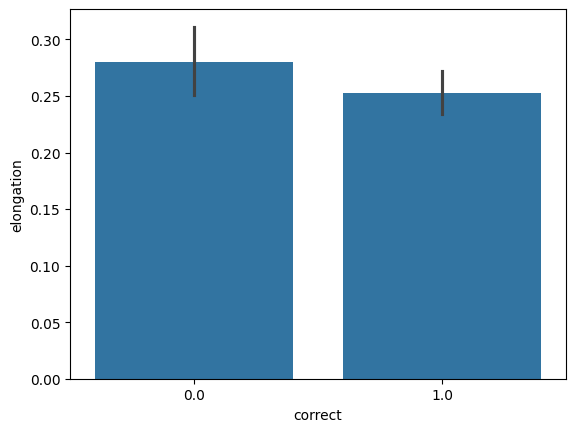

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


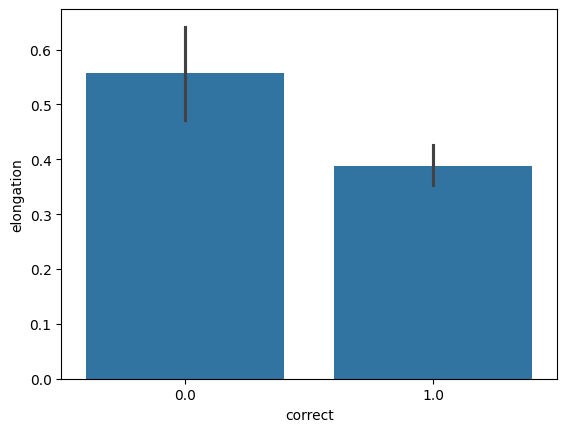

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


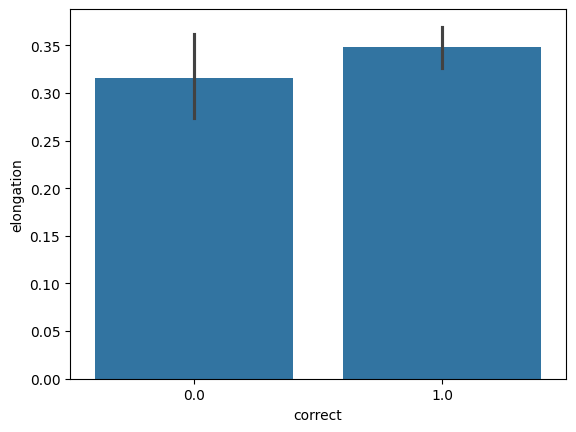

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


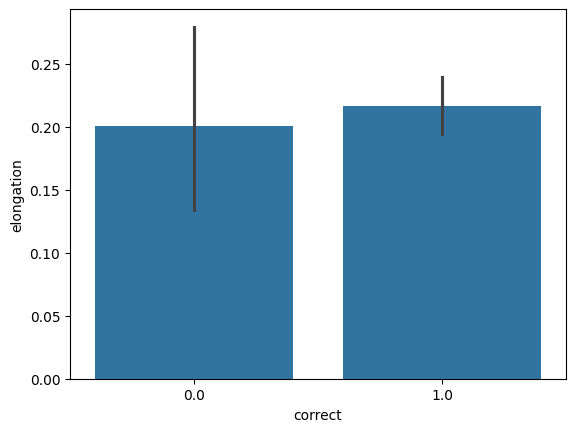

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


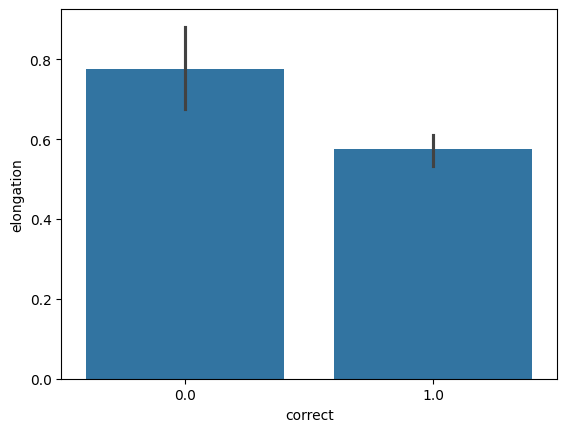

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


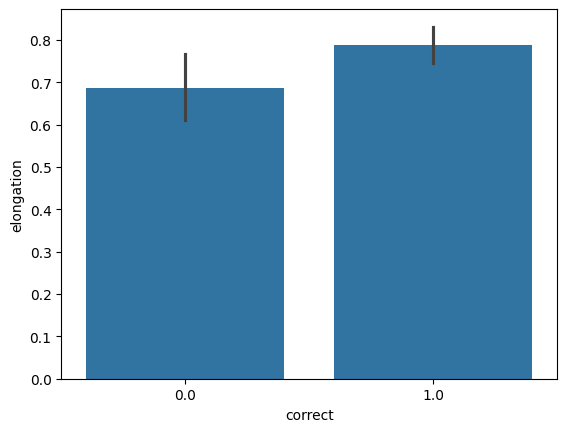

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


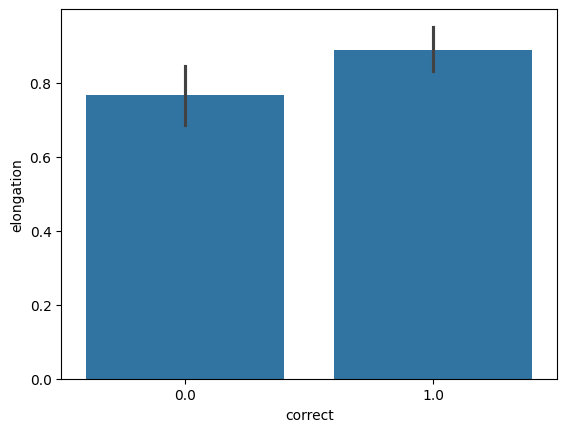

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


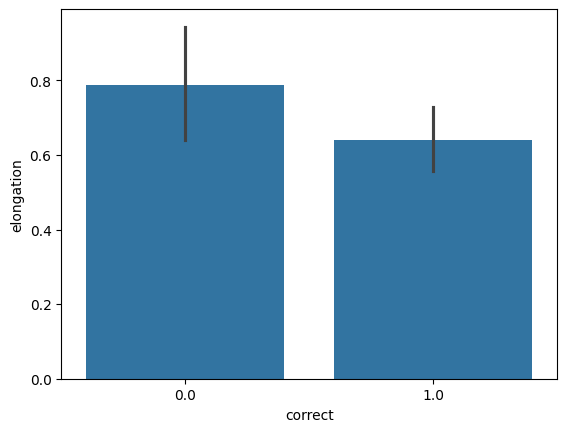

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


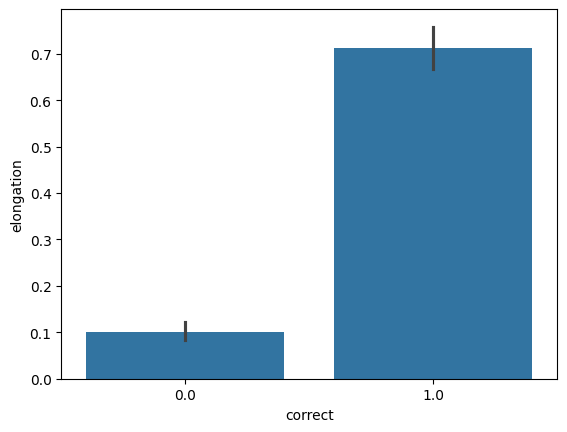

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


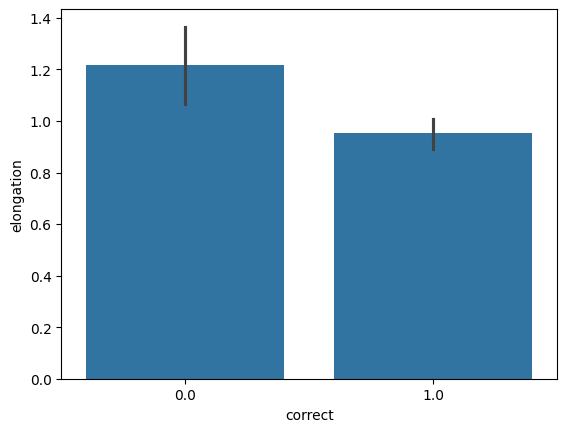

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


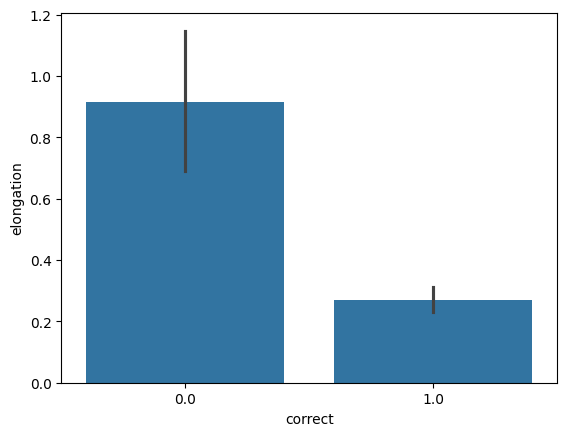

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


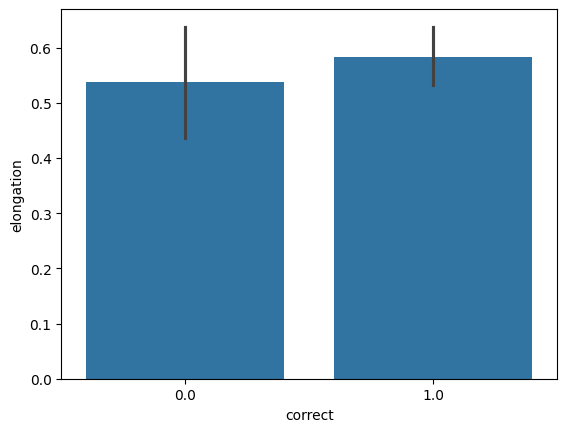

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


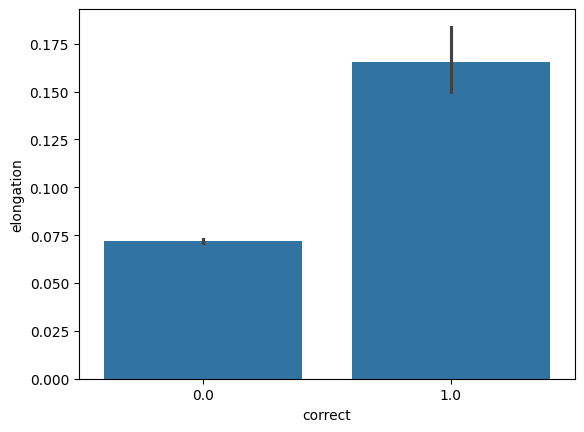

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


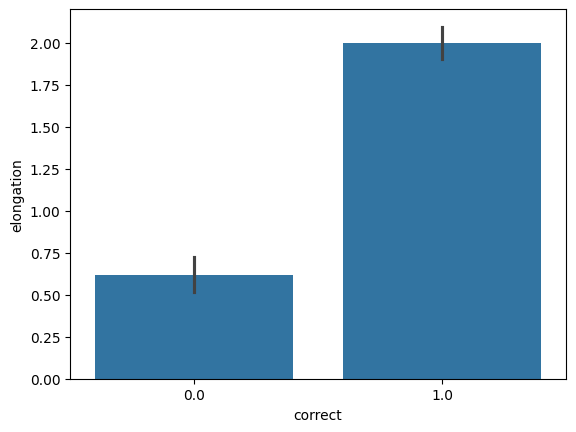

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


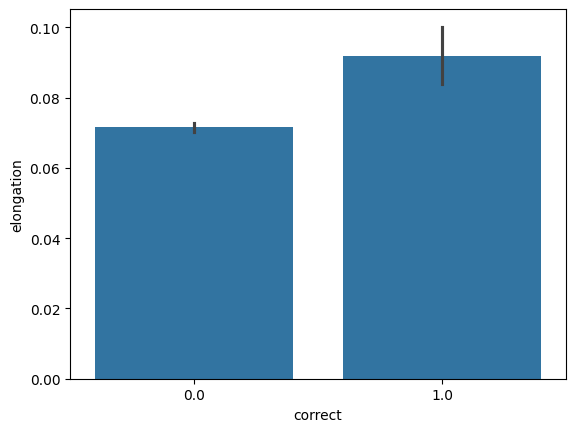

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


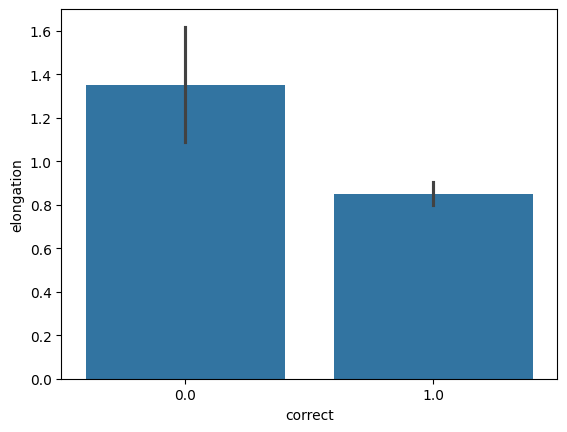

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


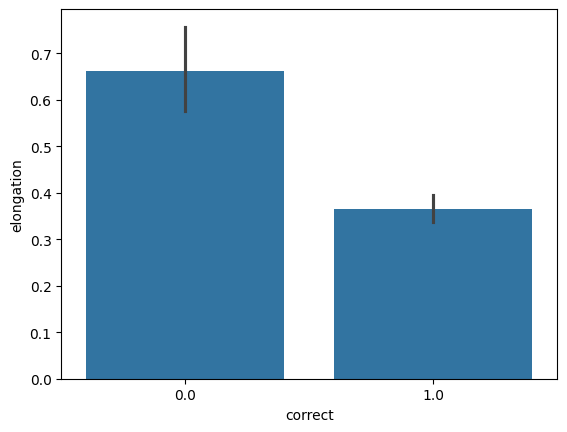

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


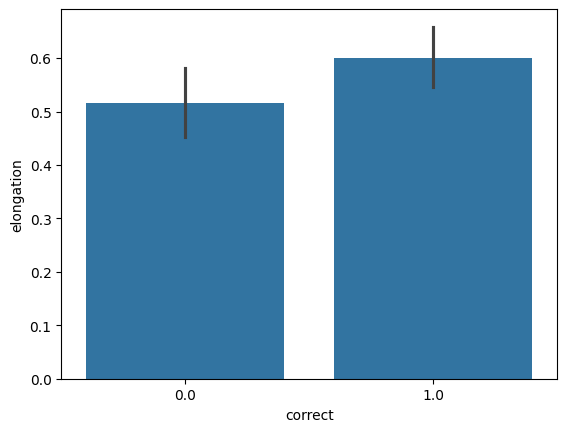

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


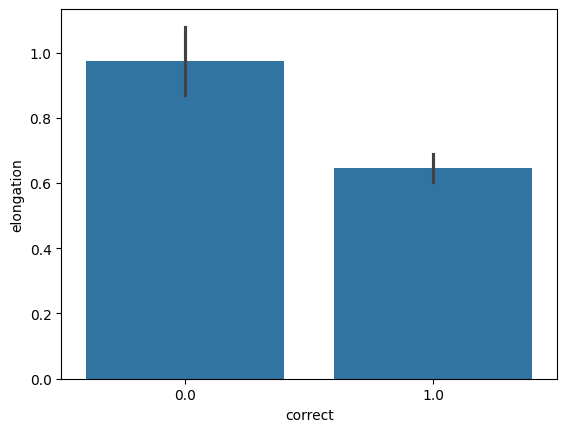

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


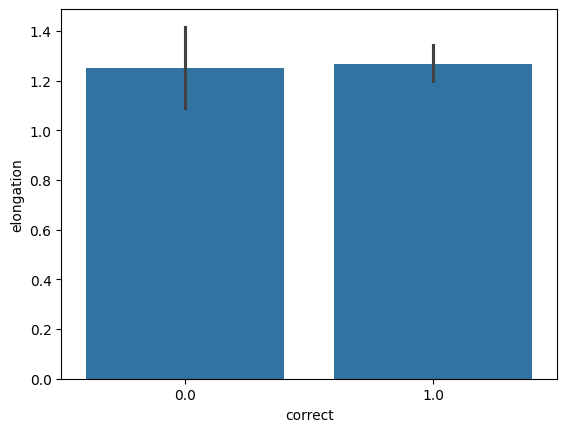

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


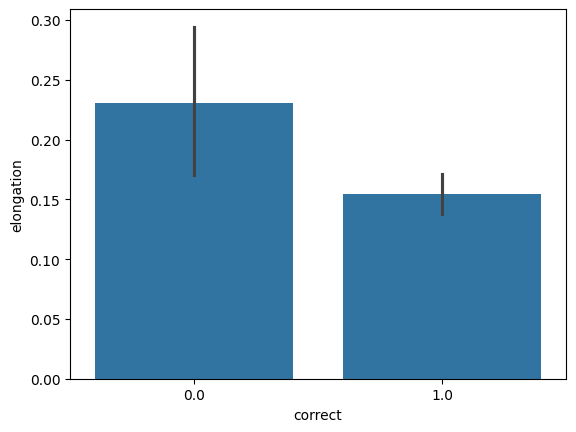

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


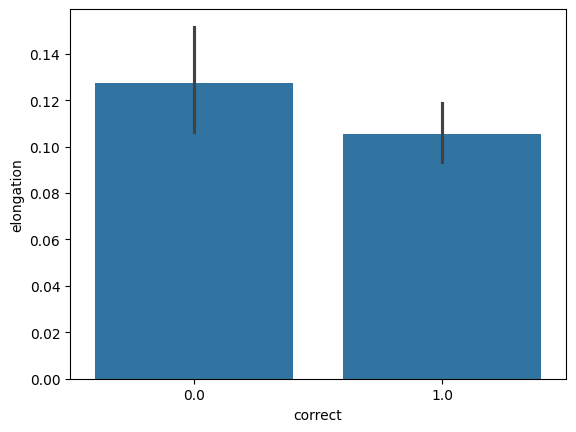

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


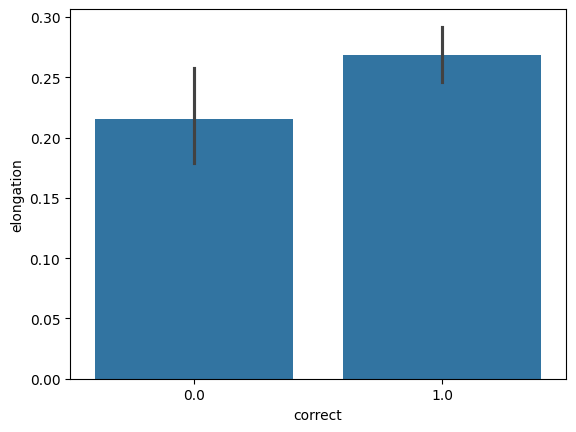

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


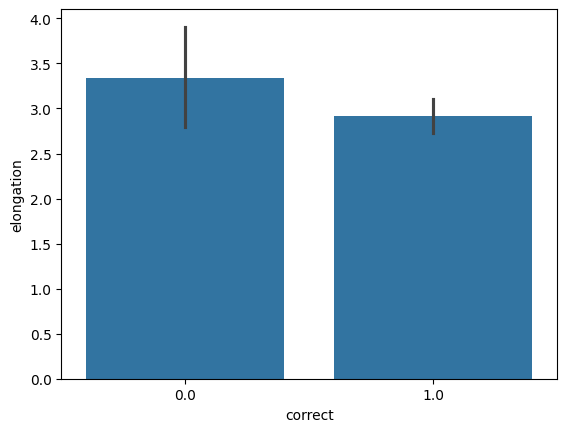

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


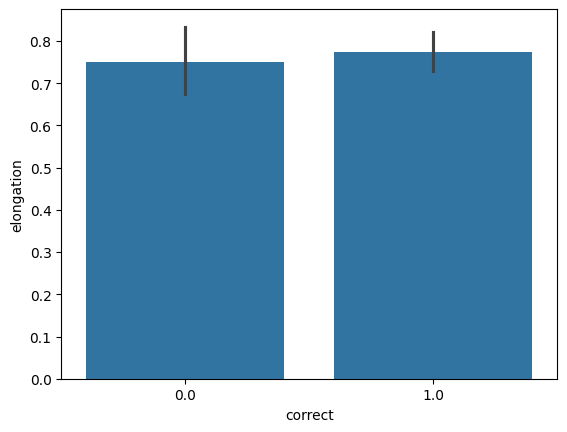

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


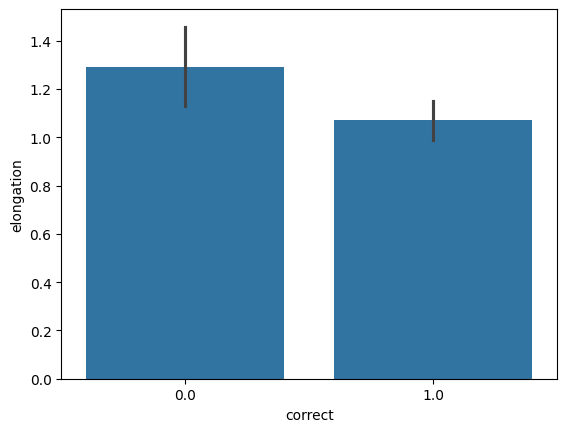

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


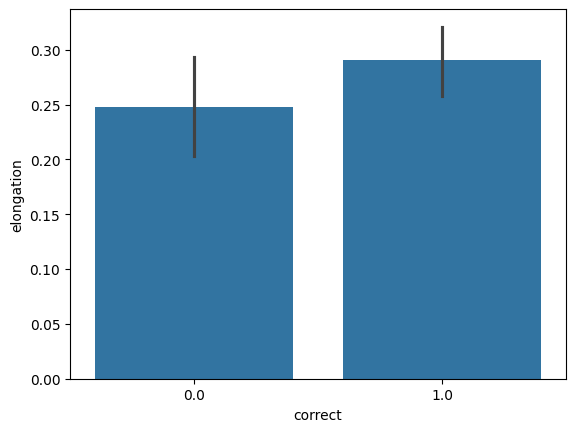

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


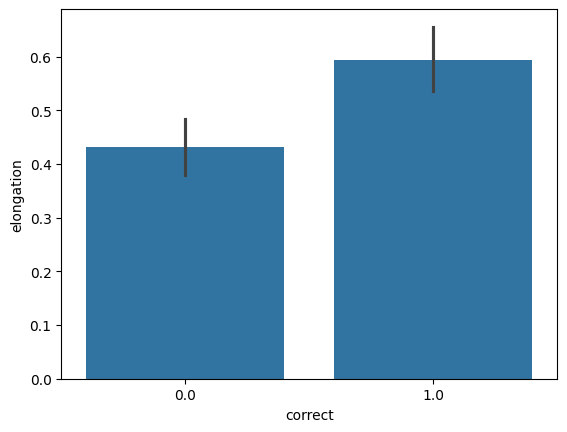

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


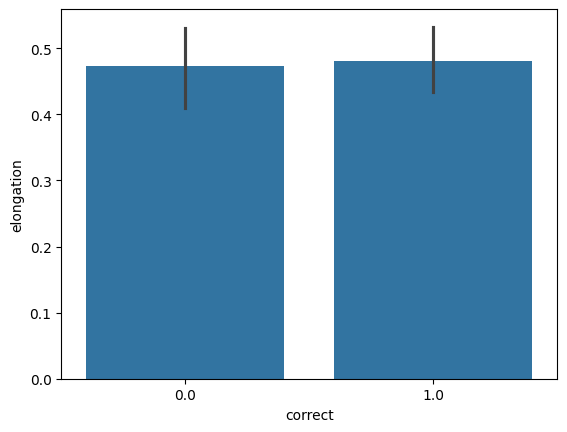

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


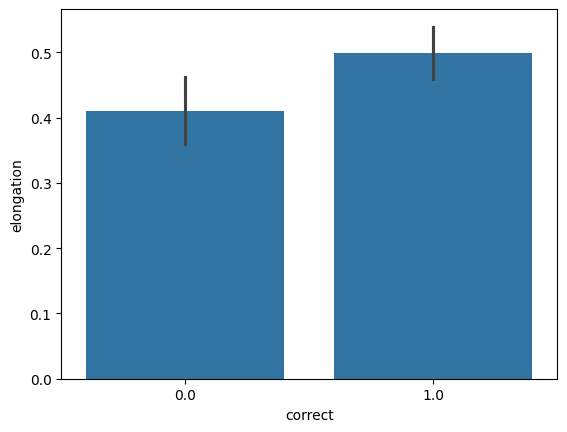

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


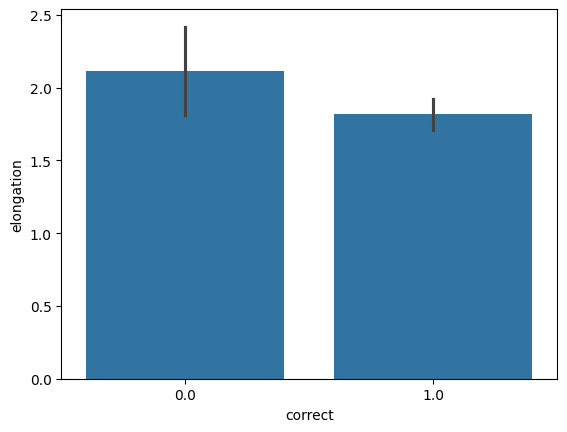

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


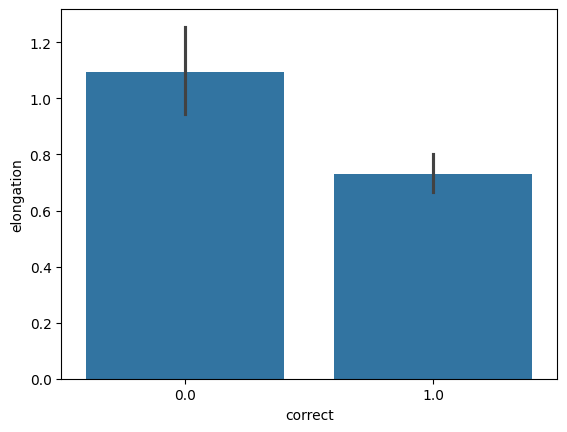

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


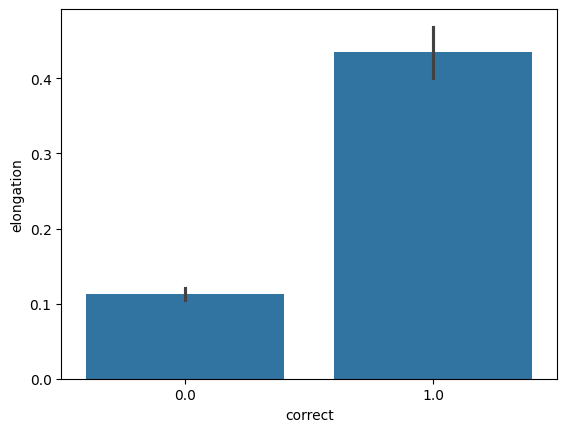

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


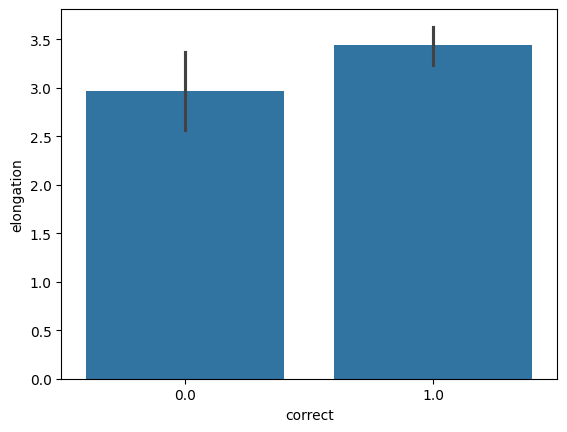

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


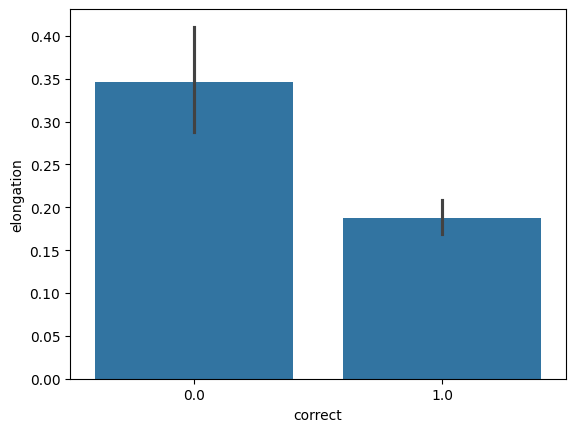

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


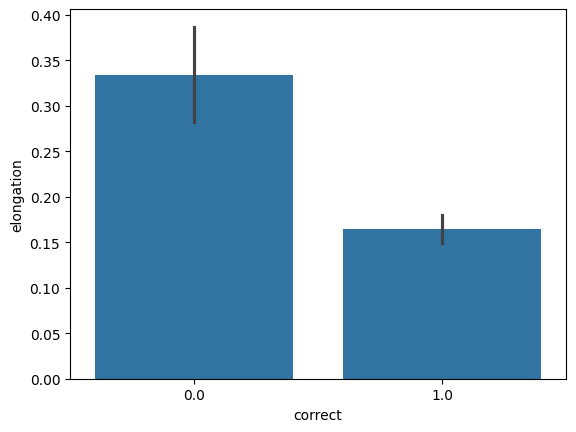

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


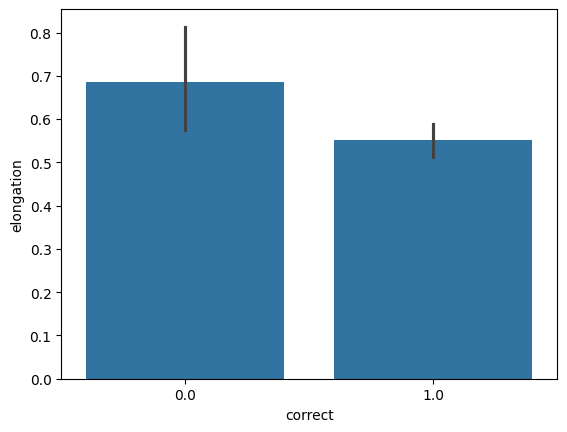

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


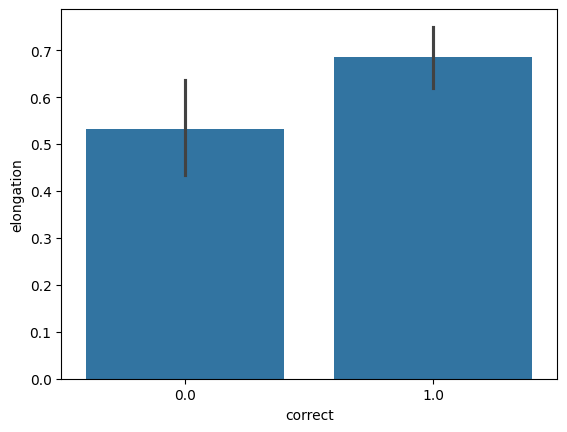

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


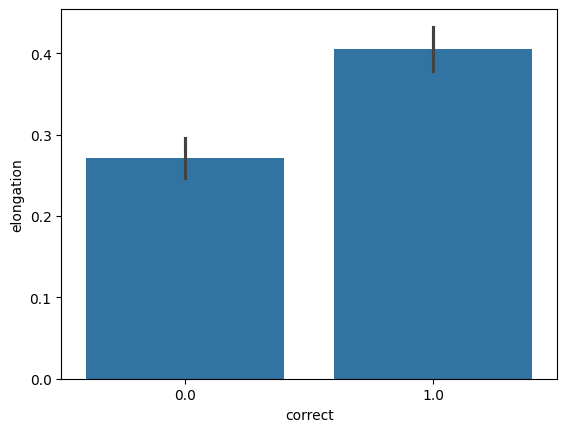

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


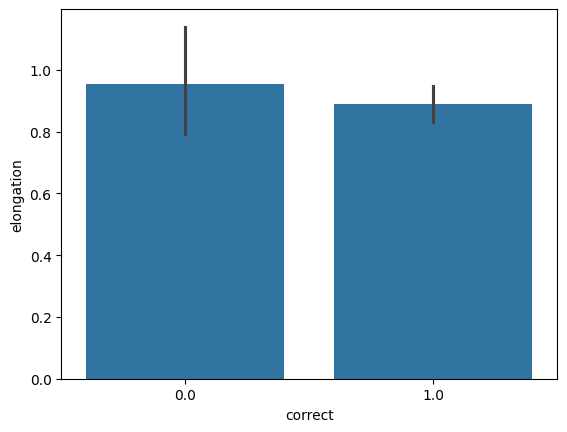

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


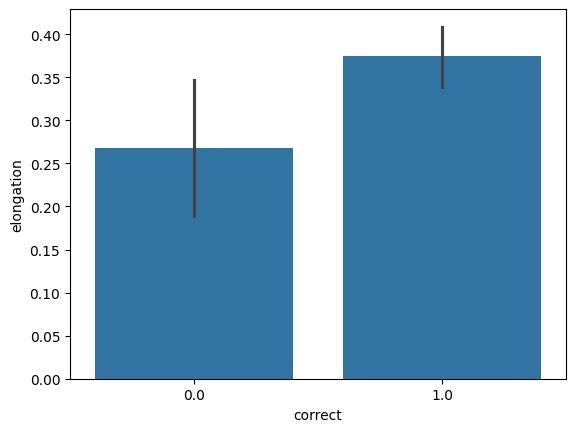

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


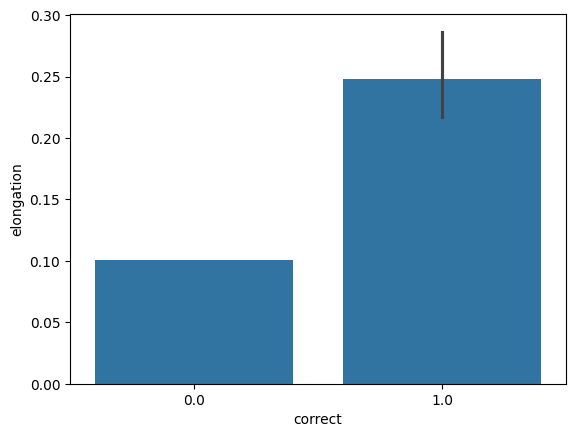

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


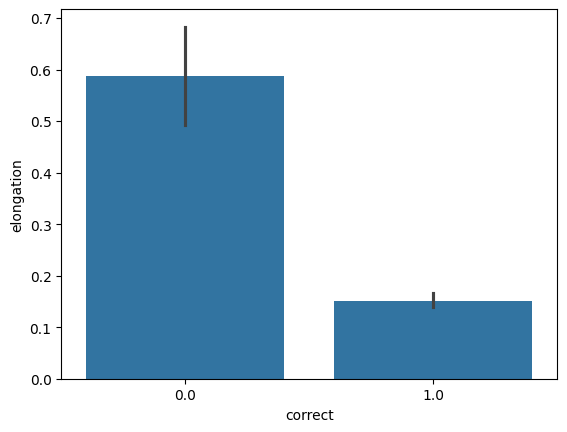

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


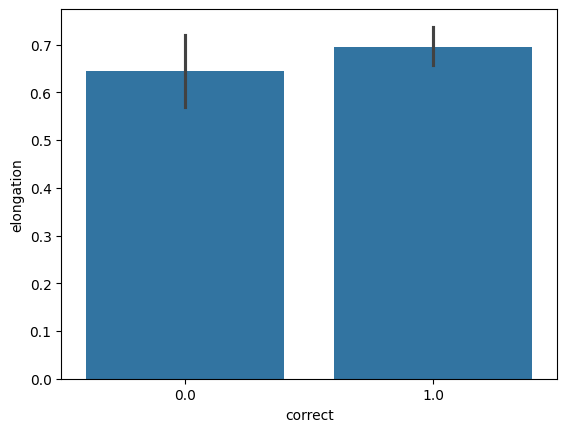

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


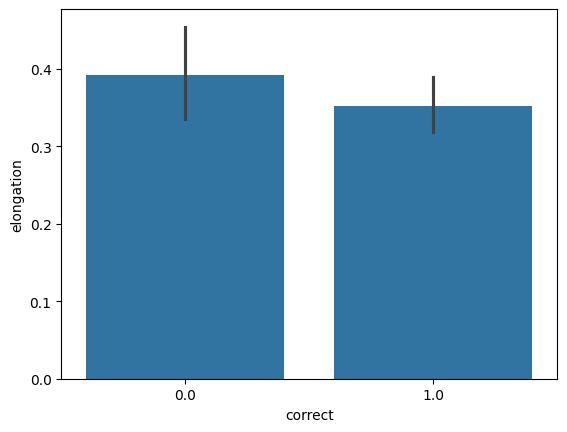

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


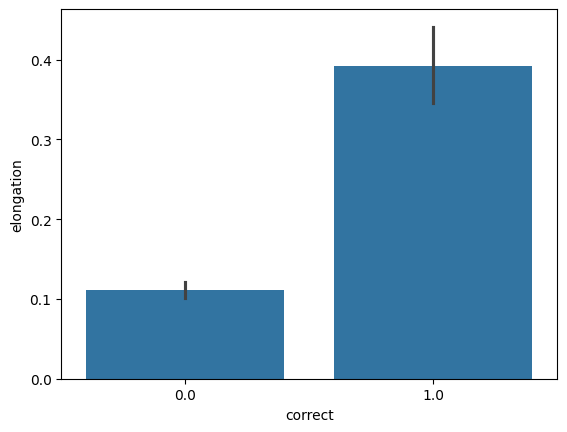

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


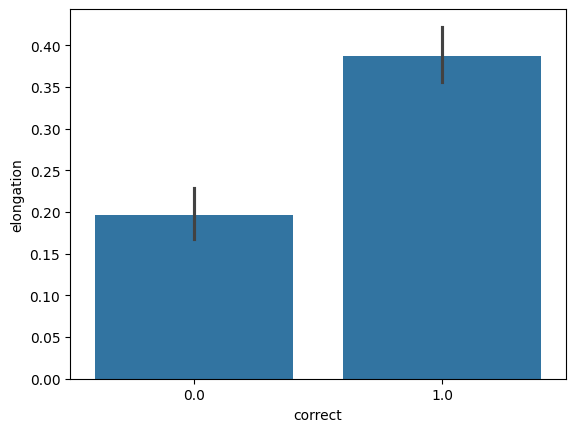

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


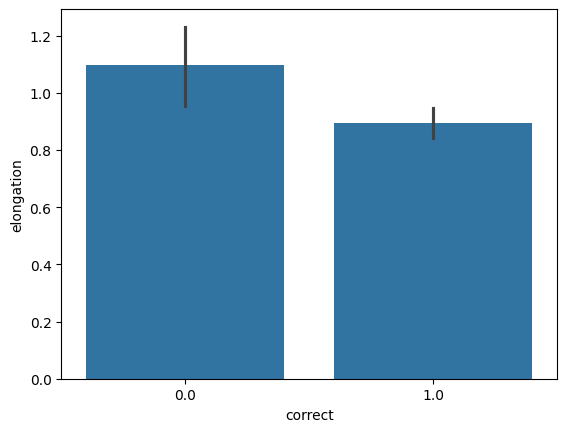

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


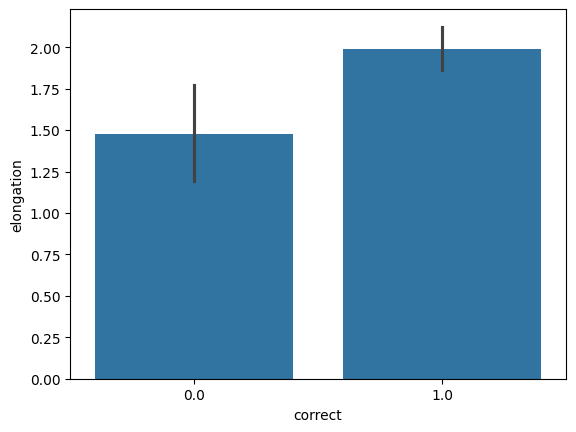

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


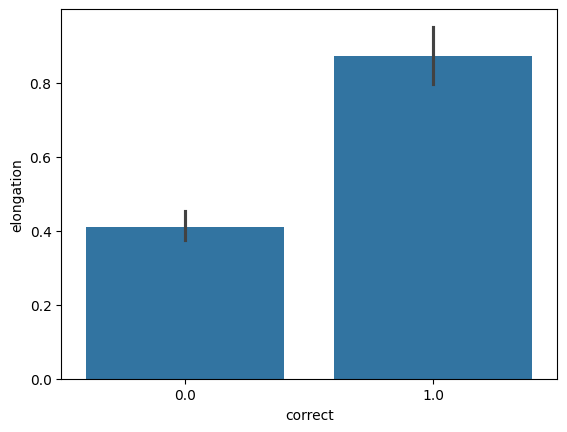

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


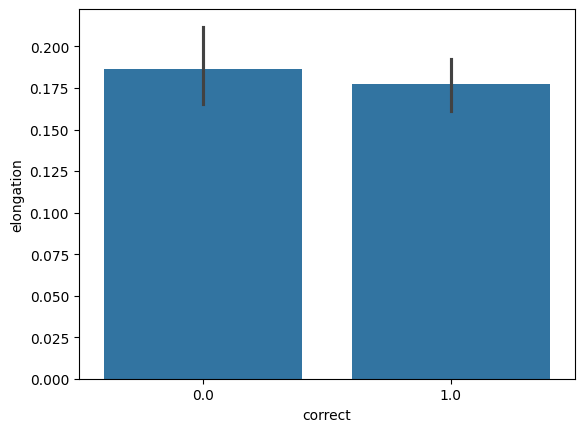

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


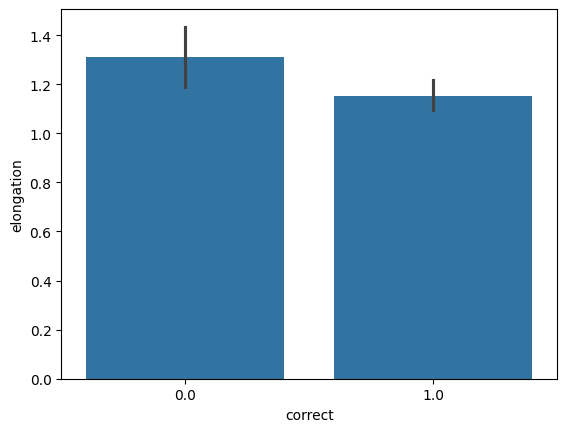

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


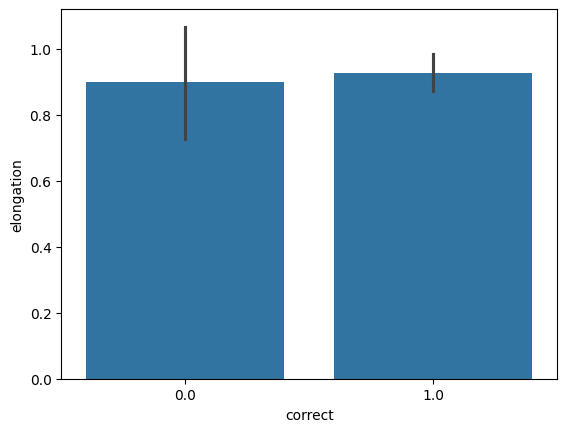

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


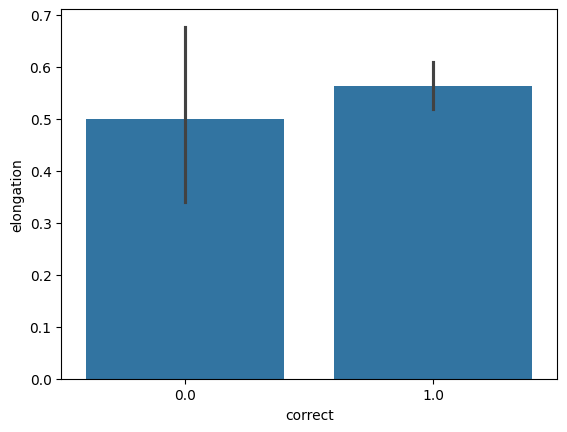

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


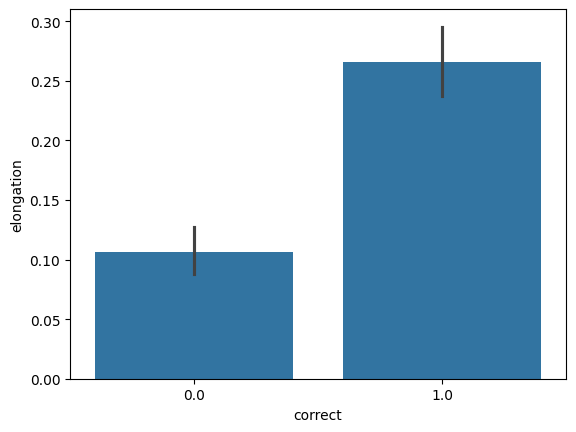

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


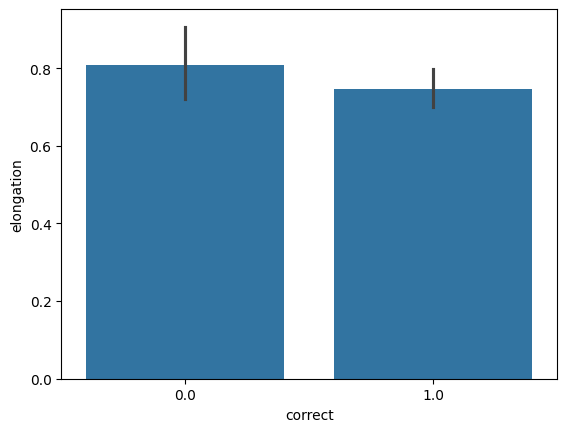

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


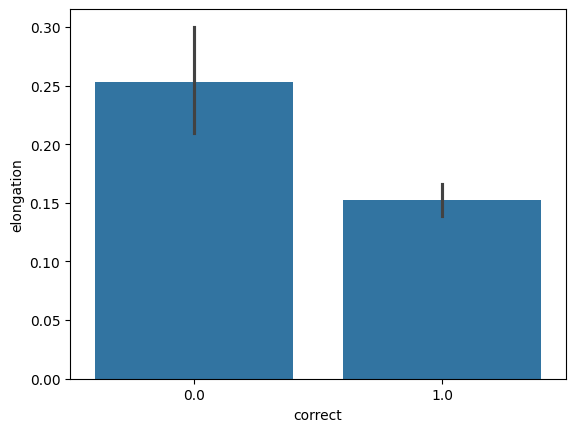

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


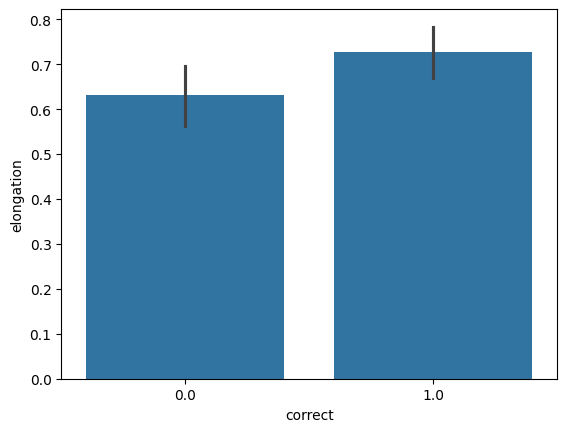

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


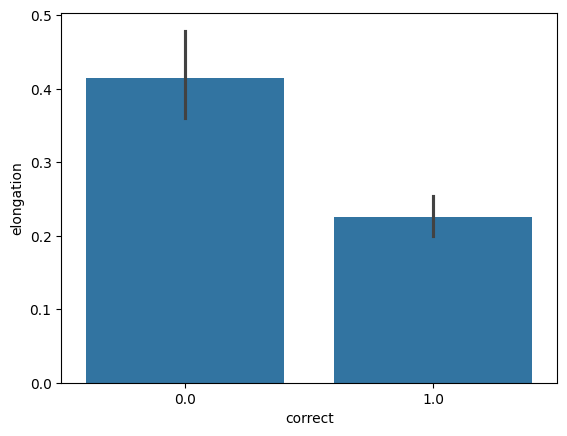

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


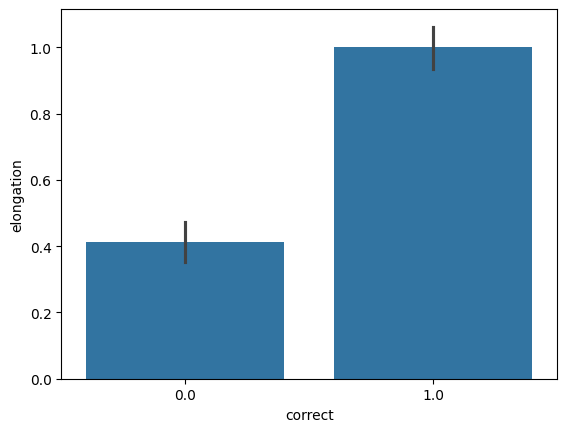

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


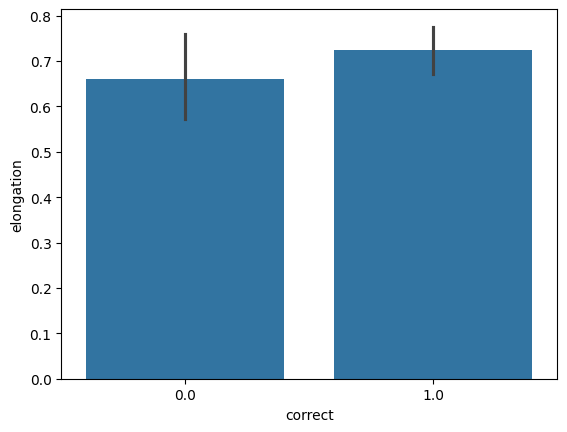

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


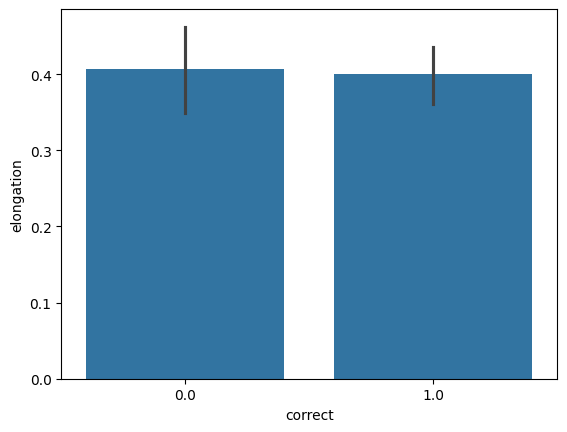

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


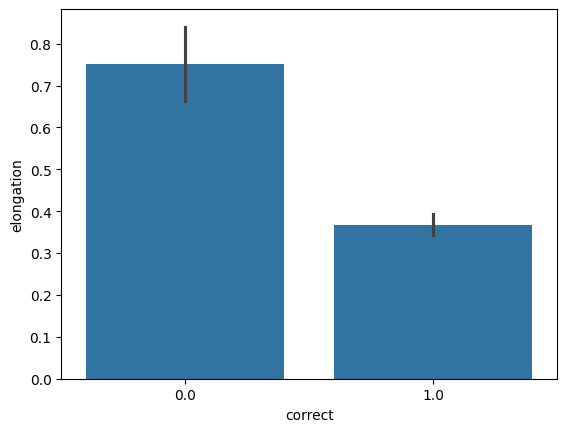

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


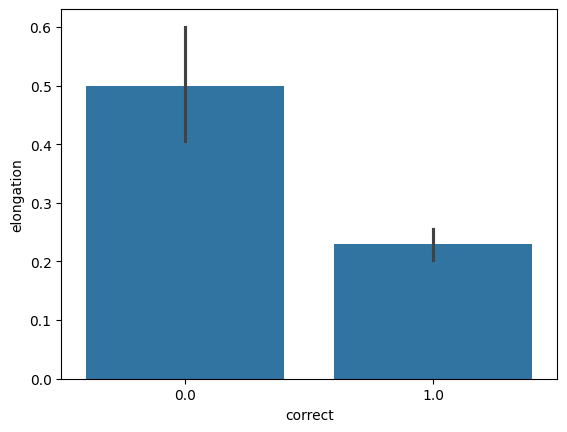

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


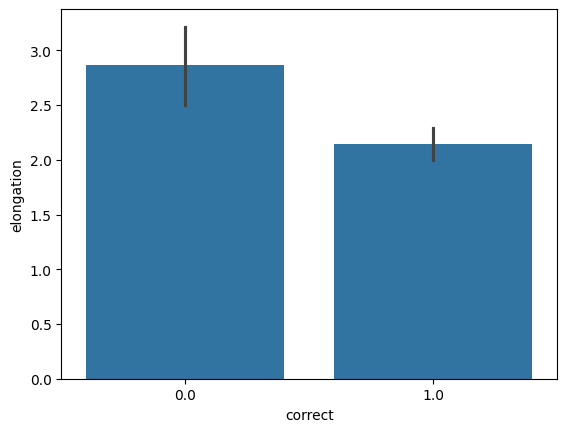

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


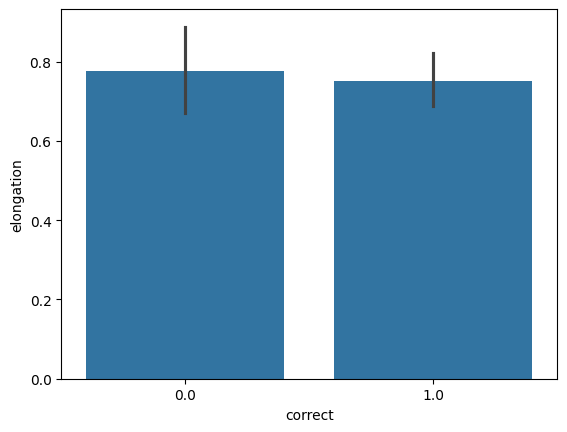

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


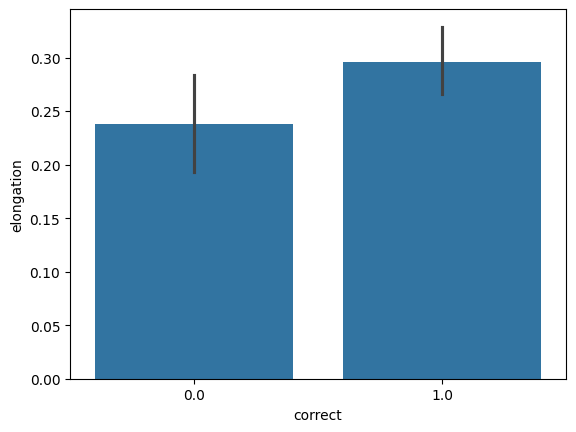

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


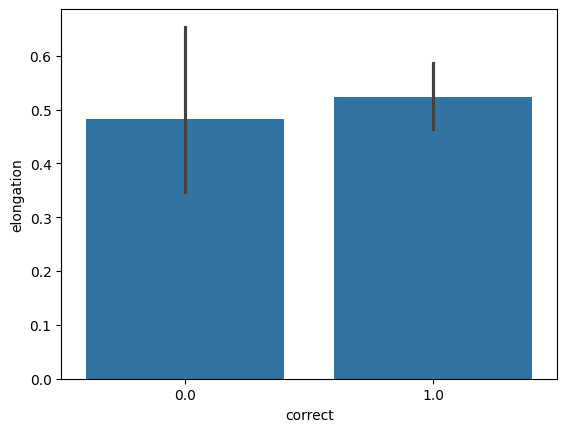

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


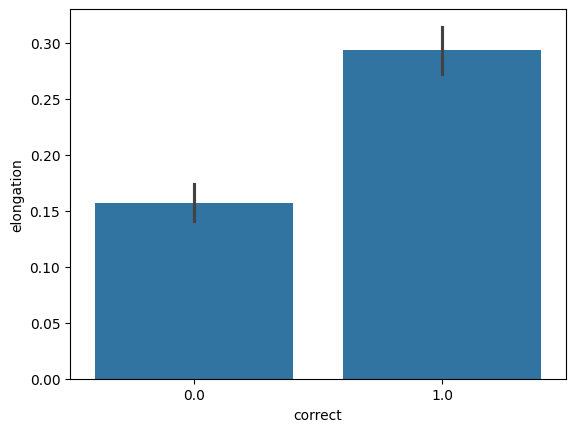

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


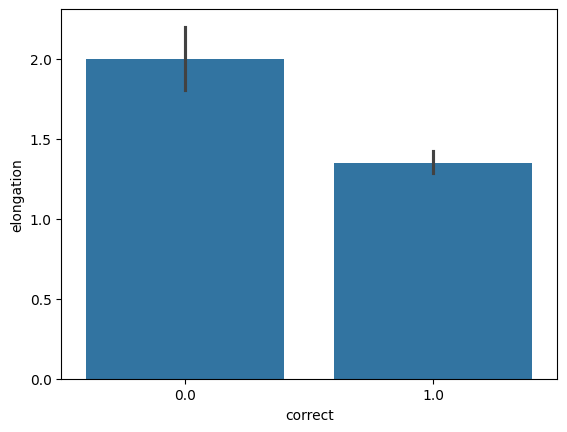

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


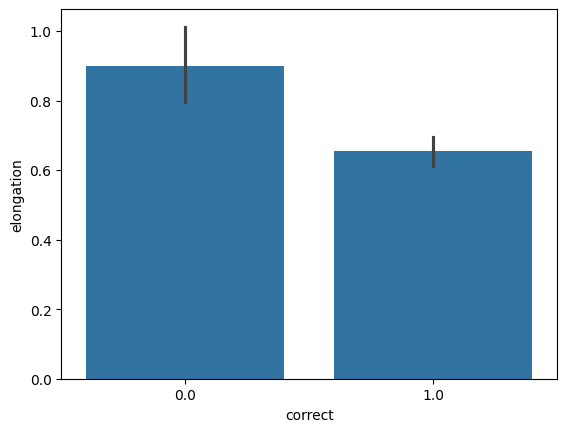

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


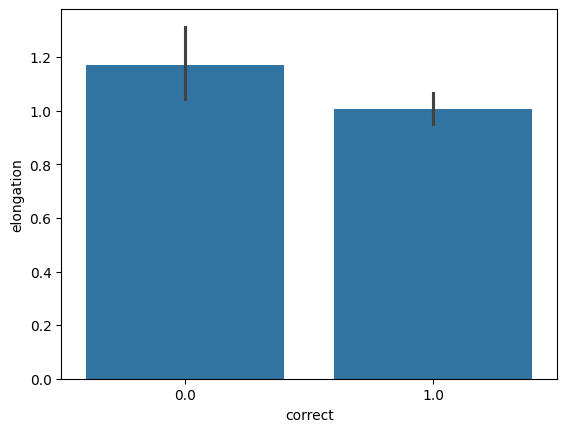

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


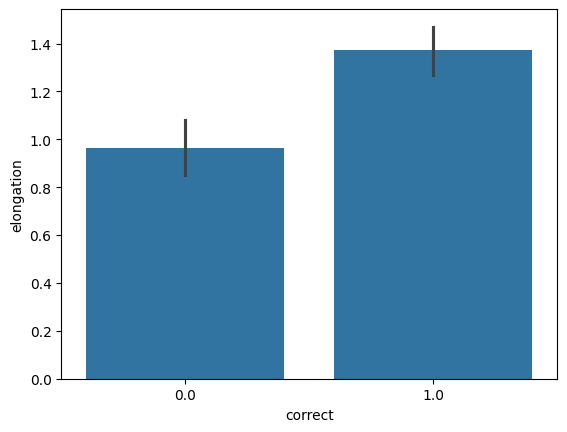

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


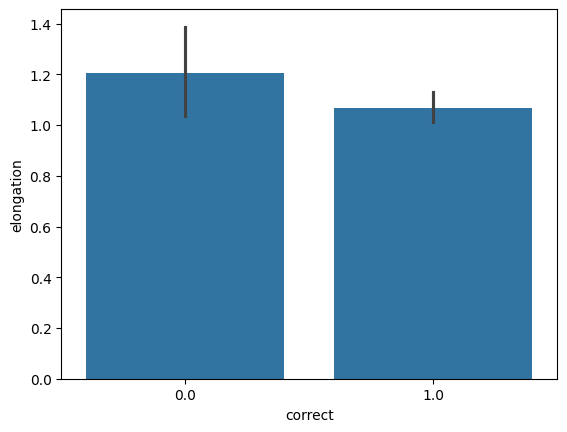

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


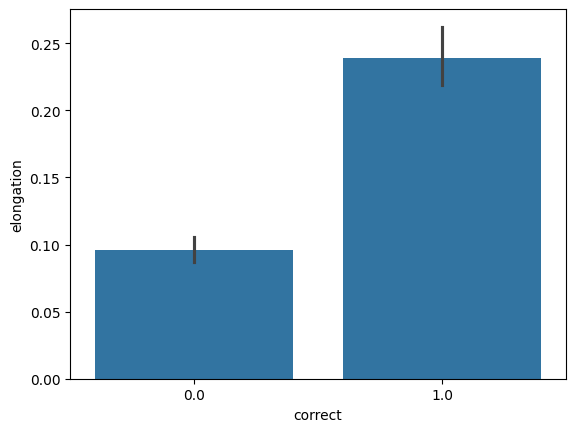

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


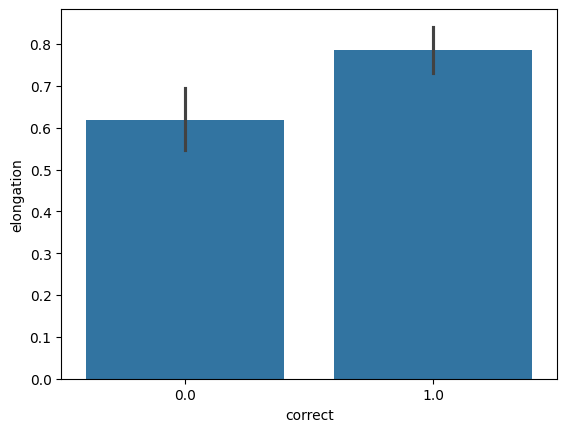

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


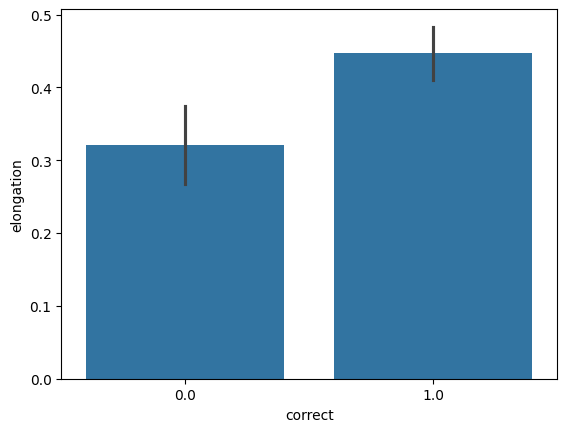

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


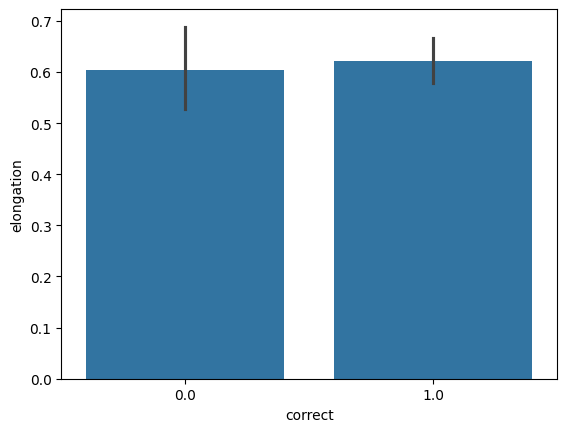

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


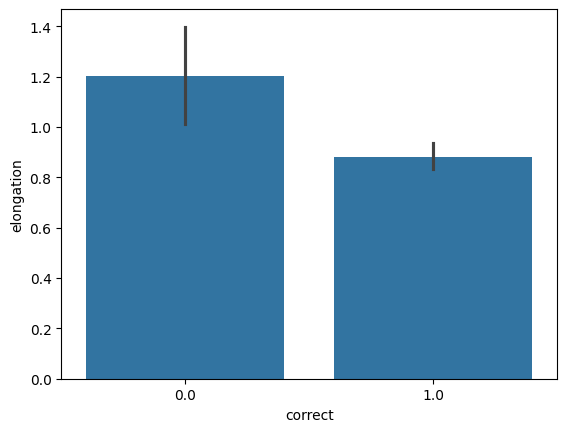

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


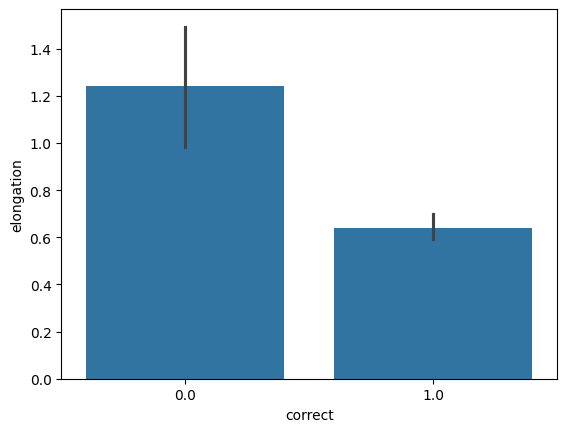

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


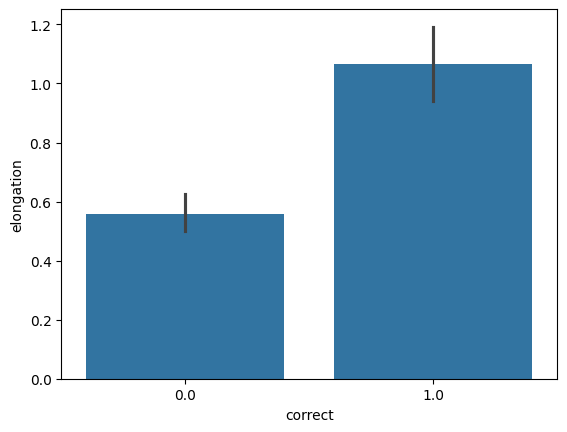

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


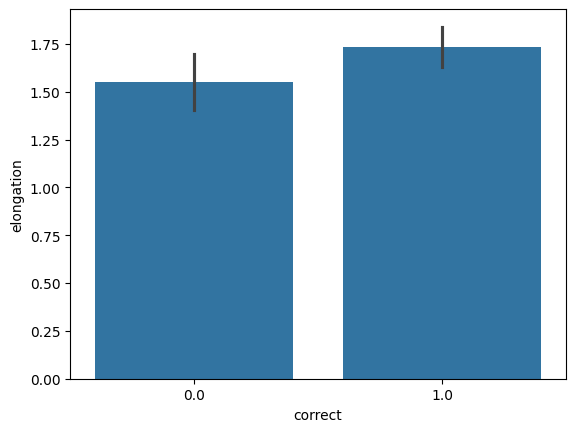

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


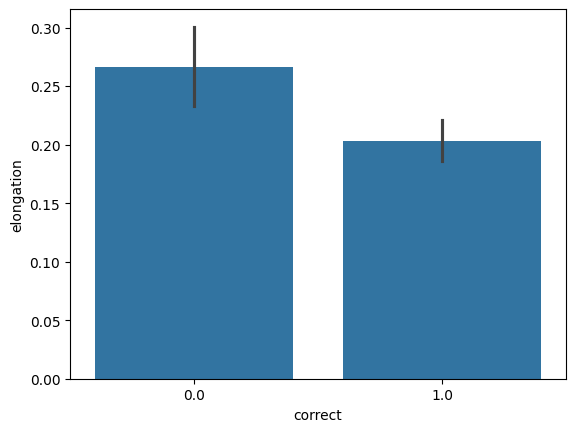

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


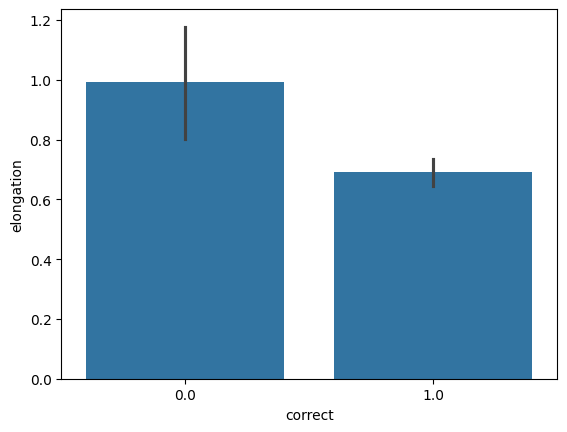

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


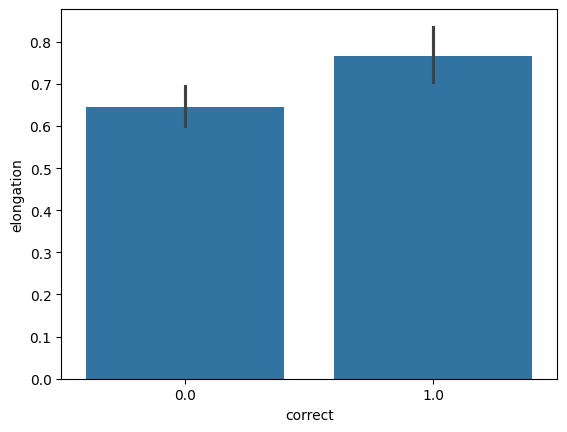

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


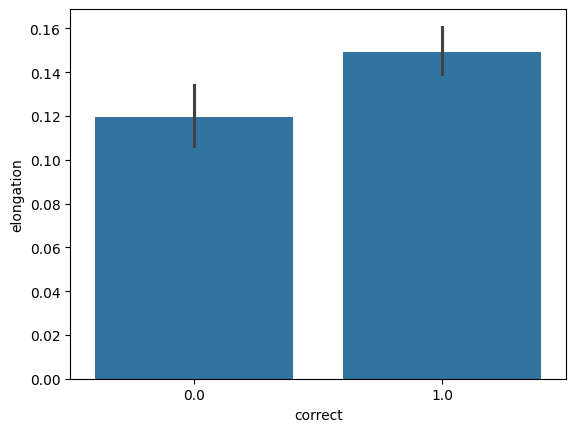

In [65]:
# Plot across sessions

for s, session in enumerate(states_trial_type['session'].unique()):
    use_data = states_trial_type.loc[states_trial_type['session']==session]
    use_data['past_feedback'] = use_data['wsls']
    use_data.loc[use_data['wsls']=='lsh', 'past_feedback'] = 'l'
    use_data.loc[use_data['wsls']=='ls', 'past_feedback'] = 'l'
    use_data.loc[use_data['wsls']=='wsh', 'past_feedback'] = 'w'
    use_data.loc[use_data['wsls']=='wst', 'past_feedback'] = 'w'
    sns.barplot(y='elongation', x='correct', data=use_data)
    # plt.ylim([0, 5])
    plt.show()

/tmp/ipykernel_23489/2459701915.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())


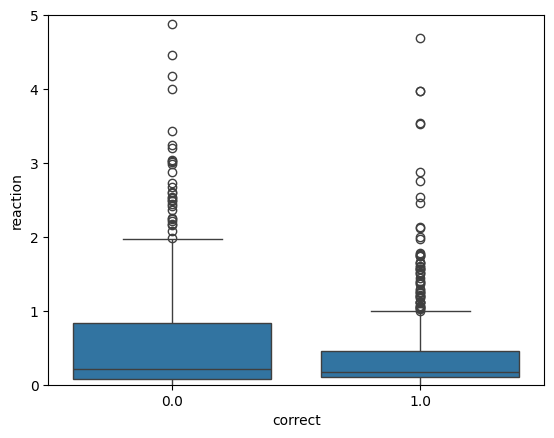

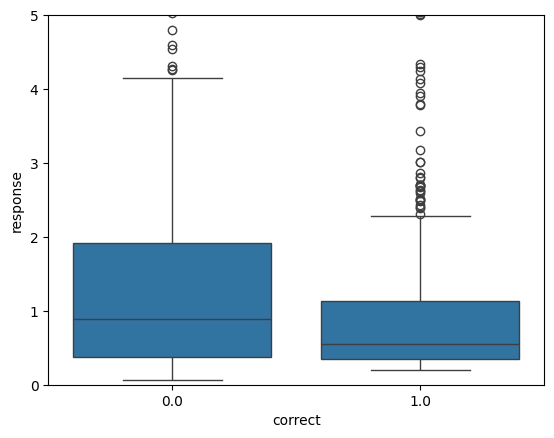

(0.0, 5.0)

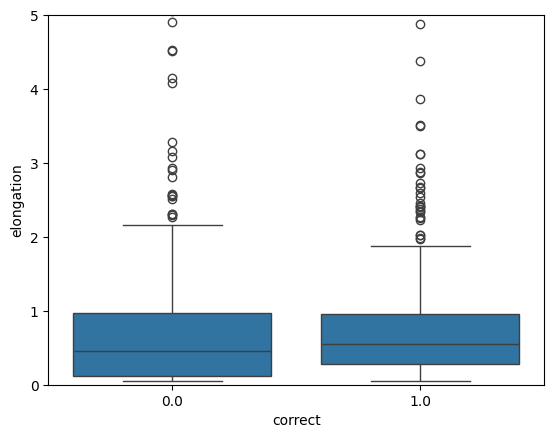

In [9]:
# Plot across sessions
reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())
reduced = reduced.reset_index(level=[0, 1, 2, 3])

sns.boxplot(y='reaction', x='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot(y='response', x='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot( y='elongation', x='correct', data=reduced)
plt.ylim([0, 5])

/tmp/ipykernel_23489/986400432.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())


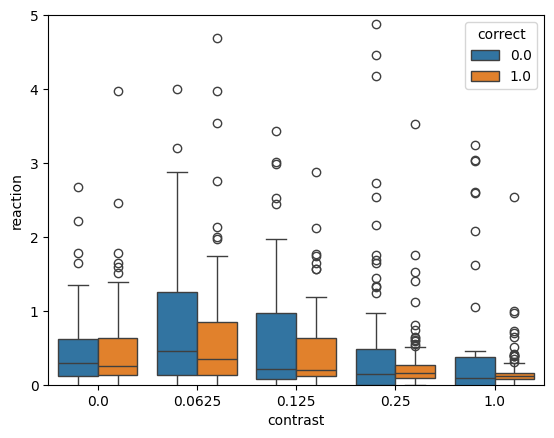

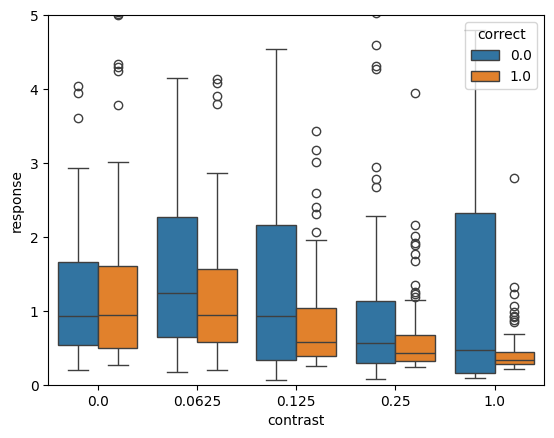

(0.0, 5.0)

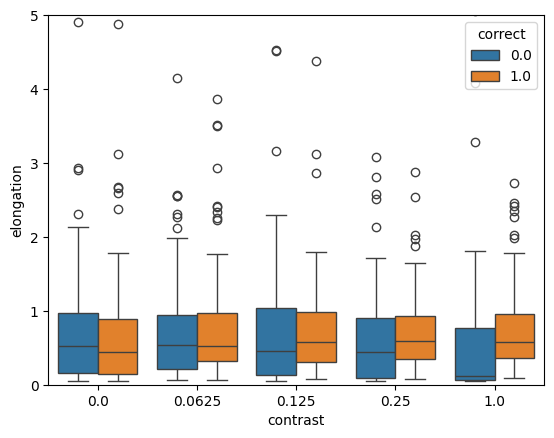

In [14]:
# Plot across sessions
reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())
reduced = reduced.reset_index(level=[0, 1, 2, 3])

sns.boxplot(x='contrast', y='reaction', hue='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot(x='contrast', y='response', hue='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot(x='contrast', y='elongation', hue='correct', data=reduced)
plt.ylim([0, 5])